# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [10]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [11]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [12]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [13]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [14]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [15]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [16]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [17]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [18]:
def train_model(current_train_size, train_indices, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [19]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def least_confidence_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    
    uncertainties = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits

        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

In [21]:
def monte_carlo_dropout_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, mc_passes=3, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.train()
    start_time = time.time()

    confidences = []
    for data in dataloader:
        # Collect multiple predictions to calculate uncertainty
        batch_probs = []
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)

        for _ in range(mc_passes):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)
    
    uncertainties = np.array(confidences)
    sorted_unc = np.argsort(confidences)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(confidences, 90)
        items_greater_than_average = uncertainties[confidences >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            most_uncertain_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in most_uncertain_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in most_uncertain_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(most_uncertain_indices))
        print(f"Sampling duration: {duration} seconds")

In [22]:
def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, filename, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    model.eval()
    start_time = time.time()
    embeddings = []
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        target_samples = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(embeddings)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'HS': [y_train[i][0] for i in temp],
                    'Abusive': [y_train[i][1] for i in temp],
                    'HS_Individual': [y_train[i][2] for i in temp],
                    'HS_Group': [y_train[i][3] for i in temp],
                    'HS_Religion': [y_train[i][4] for i in temp],
                    'HS_Race': [y_train[i][5] for i in temp],
                    'HS_Physical': [y_train[i][6] for i in temp],
                    'HS_Gender': [y_train[i][7] for i in temp],
                    'HS_Other': [y_train[i][8] for i in temp],
                    'HS_Weak': [y_train[i][9] for i in temp],
                    'HS_Moderate': [y_train[i][10] for i in temp],
                    'HS_Strong': [y_train[i][11] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

In [23]:
def coreset_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        shuffle=False,
    )
    farthest_data = dict(farthest_point)
    
    model.eval()
    start_time = time.time()
    embeddings = []
    
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
        embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Use pairwise distances to compute a distance matrix for Coreset selection
        distance_matrix = pairwise_distances(embeddings)    
        selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
        
        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
        farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']
                
        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

In [24]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend([remaining_indices[i] for i in random_indices])
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'HS': [y_train[i][0] for i in temp],
            'Abusive': [y_train[i][1] for i in temp],
            'HS_Individual': [y_train[i][2] for i in temp],
            'HS_Group': [y_train[i][3] for i in temp],
            'HS_Religion': [y_train[i][4] for i in temp],
            'HS_Race': [y_train[i][5] for i in temp],
            'HS_Physical': [y_train[i][6] for i in temp],
            'HS_Gender': [y_train[i][7] for i in temp],
            'HS_Other': [y_train[i][8] for i in temp],
            'HS_Weak': [y_train[i][9] for i in temp],
            'HS_Moderate': [y_train[i][10] for i in temp],
            'HS_Strong': [y_train[i][11] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [25]:
def active_learning(seed, i, sampling_strategy, init_size):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    farthest_point = manager.dict()
    filename = f'hsd-{sampling_strategy}-init-{init_size}'

    set_seed(seed)
    
    print("===============================================")
    print("Init Size: {}".format(init_size))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model-{percentage}')
        
        # Perform query strategy to select new samples
        new_samples = manager.list()
        if sampling_strategy == 'lc':
            print("LC")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'mc':
            print("MC")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(monte_carlo_dropout_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'kmeans':
            print("KMeans")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i, filename)
            notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'coreset':
            print("Coreset")
            sampling_args = (model, farthest_point, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'random':
            print("Random")
            random_sampling(current_train_size, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)
    print(f"Result saved to results/{filename}-{i+1}-results.csv")

# LEAST CONFIDENCE

Init Size: 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6814, Accuracy: 0.7312, F1 Micro: 0.2228, F1 Macro: 0.123
Epoch 2/10, Train Loss: 0.5938, Accuracy: 0.8056, F1 Micro: 0.1568, F1 Macro: 0.0557
Epoch 3/10, Train Loss: 0.5257, Accuracy: 0.8219, F1 Micro: 0.0493, F1 Macro: 0.0222
Epoch 4/10, Train Loss: 0.4783, Accuracy: 0.8273, F1 Micro: 0.0025, F1 Macro: 0.0014
Epoch 5/10, Train Loss: 0.4275, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 6/10, Train Loss: 0.3998, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 7/10, Train Loss: 0.3716, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 8/10, Train Loss: 0.3814, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 9/10, Train Loss: 0.4033, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 10/10, Train Loss: 0.3566, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Iteration 131: Accuracy: 0.7312, F1 Micro: 0.2228, F1 Macro: 0.123
               precision    recall  f1-score   support

           HS       0.38      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5724, Accuracy: 0.8142, F1 Micro: 0.2851, F1 Macro: 0.0635
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4557, Accuracy: 0.821, F1 Micro: 0.2969, F1 Macro: 0.065
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4327, Accuracy: 0.8411, F1 Micro: 0.3777, F1 Macro: 0.1074
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3961, Accuracy: 0.8623, F1 Micro: 0.5533, F1 Macro: 0.2441
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3621, Accuracy: 0.8781, F1 Micro: 0.5729, F1 Macro: 0.2914
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3249, Accuracy: 0.8826, F1 Micro: 0.6185, F1 Macro: 0.3751
Epoch 7/10, Train Loss: 0.2912, Accuracy: 0.8866, F1 Micro: 0.6055, F1 Macro: 0.414
Epoch 8/10, Train Loss: 0.2638, Accuracy: 0.8864, F1 Micro: 0.5873, F1 Macro: 0.3957
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2337, Accuracy: 0.8908, F1 Micro: 0.6432, F1 Macro: 0.4496
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4725, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3281, Accuracy: 0.8384, F1 Micro: 0.22, F1 Macro: 0.0695
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2827, Accuracy: 0.8633, F1 Micro: 0.4858, F1 Macro: 0.2189
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2433, Accuracy: 0.8703, F1 Micro: 0.5065, F1 Macro: 0.2431
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2137, Accuracy: 0.8801, F1 Micro: 0.5577, F1 Macro: 0.2966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.188, Accuracy: 0.8843, F1 Micro: 0.5896, F1 Macro: 0.3725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1714, Accuracy: 0.8894, F1 Micro: 0.6405, F1 Macro: 0.425
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1503, Accuracy: 0.8883, F1 Micro: 0.661, F1 Macro: 0.4983
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1302, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4203, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2789, Accuracy: 0.8423, F1 Micro: 0.2382, F1 Macro: 0.0965
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2255, Accuracy: 0.8612, F1 Micro: 0.4099, F1 Macro: 0.1831
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1828, Accuracy: 0.8674, F1 Micro: 0.4556, F1 Macro: 0.206
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1715, Accuracy: 0.8813, F1 Micro: 0.565, F1 Macro: 0.3262
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.148, Accuracy: 0.8872, F1 Micro: 0.6275, F1 Macro: 0.3927
Epoch 7/10, Train Loss: 0.1297, Accuracy: 0.8883, F1 Micro: 0.6182, F1 Macro: 0.3724
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1069, Accuracy: 0.8902, F1 Micro: 0.6598, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0965, Accuracy: 0.892, F1 Micro: 0.6755

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3897, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2514, Accuracy: 0.8357, F1 Micro: 0.1149, F1 Macro: 0.0461
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2047, Accuracy: 0.8623, F1 Micro: 0.456, F1 Macro: 0.2132
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1764, Accuracy: 0.876, F1 Micro: 0.5317, F1 Macro: 0.2555
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1537, Accuracy: 0.8859, F1 Micro: 0.6127, F1 Macro: 0.3655
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1321, Accuracy: 0.8894, F1 Micro: 0.6402, F1 Macro: 0.4323
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.115, Accuracy: 0.8867, F1 Micro: 0.6798, F1 Macro: 0.5094
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.8922, F1 Micro: 0.6575, F1 Macro: 0.472
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0863, Accuracy: 0.8963, F1 Micro: 0.6862,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3631, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2416, Accuracy: 0.8488, F1 Micro: 0.3382, F1 Macro: 0.1607
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.19, Accuracy: 0.8618, F1 Micro: 0.4095, F1 Macro: 0.1875
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.8825, F1 Micro: 0.5794, F1 Macro: 0.2864
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.8834, F1 Micro: 0.5728, F1 Macro: 0.3318
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1201, Accuracy: 0.8801, F1 Micro: 0.6734, F1 Macro: 0.4787
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.8912, F1 Micro: 0.6725, F1 Macro: 0.5004
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.8926, F1 Micro: 0.6864, F1 Macro: 0.5153
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.8966, F1 Micro: 0.6608, F1 Macro: 0.4854
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3475, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2339, Accuracy: 0.8474, F1 Micro: 0.2578, F1 Macro: 0.1168
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.8702, F1 Micro: 0.5089, F1 Macro: 0.2501
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.162, Accuracy: 0.887, F1 Micro: 0.6276, F1 Macro: 0.3721
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.8896, F1 Micro: 0.6263, F1 Macro: 0.3811
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.8958, F1 Micro: 0.6645, F1 Macro: 0.468
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0959, Accuracy: 0.8985, F1 Micro: 0.6819, F1 Macro: 0.4963
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.8956, F1 Micro: 0.7028, F1 Macro: 0.5395
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.9002, F1 Micro: 0.714

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3422, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2361, Accuracy: 0.8513, F1 Micro: 0.3076, F1 Macro: 0.1433
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1913, Accuracy: 0.8774, F1 Micro: 0.5513, F1 Macro: 0.2777
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.8891, F1 Micro: 0.6413, F1 Macro: 0.4174
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1338, Accuracy: 0.8907, F1 Micro: 0.6684, F1 Macro: 0.3691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.8961, F1 Micro: 0.6782, F1 Macro: 0.4764
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.8981, F1 Micro: 0.7041, F1 Macro: 0.5164
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.9037, F1 Micro: 0.708, F1 Macro: 0.527
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0726,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3424, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.24, Accuracy: 0.8667, F1 Micro: 0.4956, F1 Macro: 0.2291
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1966, Accuracy: 0.8863, F1 Micro: 0.6068, F1 Macro: 0.3277
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.8945, F1 Micro: 0.671, F1 Macro: 0.4238
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1355, Accuracy: 0.8903, F1 Micro: 0.6979, F1 Macro: 0.5124
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.9021, F1 Micro: 0.6827, F1 Macro: 0.4628
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.9059, F1 Micro: 0.7116, F1 Macro: 0.5273
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0801, Accuracy: 0.9035, F1 Micro: 0.7272, F1 Macro: 0.5624
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9089, F1 Micro: 0.7132, F1 Macro: 0.5481
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3533, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2525, Accuracy: 0.8667, F1 Micro: 0.4224, F1 Macro: 0.203
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.195, Accuracy: 0.892, F1 Micro: 0.6212, F1 Macro: 0.3942
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9, F1 Micro: 0.7014, F1 Macro: 0.5357
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9051, F1 Micro: 0.7208, F1 Macro: 0.5337
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1143, Accuracy: 0.9059, F1 Micro: 0.7292, F1 Macro: 0.5654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9031, F1 Micro: 0.7339, F1 Macro: 0.5766
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.9135, F1 Micro: 0.7447, F1 Macro: 0.5858
Epoch 9/10, Train Loss: 0.0696, Accuracy: 0.9132, F1 Micro: 0.7444, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.355, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2547, Accuracy: 0.8741, F1 Micro: 0.5232, F1 Macro: 0.2955
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.8924, F1 Micro: 0.6247, F1 Macro: 0.3726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.8958, F1 Micro: 0.6315, F1 Macro: 0.4113
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1393, Accuracy: 0.9054, F1 Micro: 0.7032, F1 Macro: 0.5288
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1119, Accuracy: 0.9076, F1 Micro: 0.7287, F1 Macro: 0.5575
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.9064, F1 Micro: 0.7369, F1 Macro: 0.5736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9146, F1 Micro: 0.7456, F1 Macro: 0.6003
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0645

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.364, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2503, Accuracy: 0.8792, F1 Micro: 0.522, F1 Macro: 0.3228
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.8994, F1 Micro: 0.6816, F1 Macro: 0.462
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.9068, F1 Micro: 0.7178, F1 Macro: 0.5639
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9086, F1 Micro: 0.7284, F1 Macro: 0.5804
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.9103, F1 Micro: 0.741, F1 Macro: 0.5864
Epoch 7/10, Train Loss: 0.0993, Accuracy: 0.9083, F1 Micro: 0.7349, F1 Macro: 0.5987
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.9119, F1 Micro: 0.741, F1 Macro: 0.5991
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0662, Accuracy: 0.9151, F1 Micro: 0.7486,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3721, Accuracy: 0.8411, F1 Micro: 0.1624, F1 Macro: 0.0568
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2524, Accuracy: 0.8872, F1 Micro: 0.5885, F1 Macro: 0.3951
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2043, Accuracy: 0.8997, F1 Micro: 0.6566, F1 Macro: 0.4711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9111, F1 Micro: 0.7167, F1 Macro: 0.5588
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9112, F1 Micro: 0.745, F1 Macro: 0.597
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9129, F1 Micro: 0.7425, F1 Macro: 0.6036
Epoch 7/10, Train Loss: 0.0969, Accuracy: 0.9142, F1 Micro: 0.7383, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.9157, F1 Micro: 0.7505, F1 Macro: 0.6012
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.9161, F1 Micro: 0.7548, F1 Macro: 0.6076
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3734, Accuracy: 0.8511, F1 Micro: 0.2785, F1 Macro: 0.1017
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2541, Accuracy: 0.8935, F1 Micro: 0.6288, F1 Macro: 0.3848
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2075, Accuracy: 0.9054, F1 Micro: 0.6973, F1 Macro: 0.5249
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.9097, F1 Micro: 0.733, F1 Macro: 0.5659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.9162, F1 Micro: 0.7464, F1 Macro: 0.5886
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1155, Accuracy: 0.9165, F1 Micro: 0.7517, F1 Macro: 0.6082
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.9163, F1 Micro: 0.7488, F1 Macro: 0.5953
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0815, Accuracy: 0.918, F1 Micro: 0.7579, F1 Macro: 0.6153
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9122, F1 Micro: 0.7411, F1 Macro: 0.6014
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3724, Accuracy: 0.8566, F1 Micro: 0.3381, F1 Macro: 0.1416
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2522, Accuracy: 0.8942, F1 Micro: 0.6354, F1 Macro: 0.4389
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.9078, F1 Micro: 0.7197, F1 Macro: 0.5686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9129, F1 Micro: 0.7415, F1 Macro: 0.571
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.9133, F1 Micro: 0.753, F1 Macro: 0.6031
Epoch 6/10, Train Loss: 0.1107, Accuracy: 0.9173, F1 Micro: 0.745, F1 Macro: 0.59
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0953, Accuracy: 0.9149, F1 Micro: 0.7565, F1 Macro: 0.5962
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9182, F1 Micro: 0.7621, F1 Macro: 0.6126
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9179, F1 Micro: 0.7526, F1 Macro: 0.6141
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3761, Accuracy: 0.8646, F1 Micro: 0.4171, F1 Macro: 0.1928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2564, Accuracy: 0.8985, F1 Micro: 0.6649, F1 Macro: 0.4574
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1997, Accuracy: 0.9087, F1 Micro: 0.6947, F1 Macro: 0.5111
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1712, Accuracy: 0.916, F1 Micro: 0.7482, F1 Macro: 0.5954
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.9167, F1 Micro: 0.7524, F1 Macro: 0.5974
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.9176, F1 Micro: 0.7369, F1 Macro: 0.5945
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.9151, F1 Micro: 0.7544, F1 Macro: 0.607
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.9179, F1 Micro: 0.7486, F1 Macro: 0.6061
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9106, F1 Micro: 0.7466, F1 Macro: 0.6061
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3792, Accuracy: 0.8748, F1 Micro: 0.5235, F1 Macro: 0.2472
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.251, Accuracy: 0.901, F1 Micro: 0.6955, F1 Macro: 0.4913
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.9094, F1 Micro: 0.7203, F1 Macro: 0.5392
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9176, F1 Micro: 0.7529, F1 Macro: 0.6016
Epoch 5/10, Train Loss: 0.141, Accuracy: 0.9184, F1 Micro: 0.7445, F1 Macro: 0.5908
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1127, Accuracy: 0.9187, F1 Micro: 0.7545, F1 Macro: 0.5976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0984, Accuracy: 0.9165, F1 Micro: 0.7621, F1 Macro: 0.6114
Epoch 8/10, Train Loss: 0.0812, Accuracy: 0.918, F1 Micro: 0.7519, F1 Macro: 0.5914
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9178, F1 Micro: 0.7632, F1 Macro: 0.6198
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3773, Accuracy: 0.8774, F1 Micro: 0.5969, F1 Macro: 0.3008
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2503, Accuracy: 0.9011, F1 Micro: 0.689, F1 Macro: 0.5048
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1981, Accuracy: 0.9061, F1 Micro: 0.7321, F1 Macro: 0.5766
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1601, Accuracy: 0.9153, F1 Micro: 0.7546, F1 Macro: 0.5985
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.9187, F1 Micro: 0.7573, F1 Macro: 0.6081
Epoch 6/10, Train Loss: 0.1138, Accuracy: 0.9195, F1 Micro: 0.7554, F1 Macro: 0.5935
Epoch 7/10, Train Loss: 0.0983, Accuracy: 0.9186, F1 Micro: 0.7567, F1 Macro: 0.6147
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.9197, F1 Micro: 0.7638, F1 Macro: 0.6326
Epoch 9/10, Train Loss: 0.07, Accuracy: 0.9177, F1 Micro: 0.7541, F1 Macro: 0.622
Epoch 10/10, Train Loss: 0.0622, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3766, Accuracy: 0.8788, F1 Micro: 0.5547, F1 Macro: 0.2783
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.8981, F1 Micro: 0.6456, F1 Macro: 0.4269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.9126, F1 Micro: 0.7205, F1 Macro: 0.5361
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9177, F1 Micro: 0.7526, F1 Macro: 0.5972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1392, Accuracy: 0.9194, F1 Micro: 0.7539, F1 Macro: 0.5959
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.9213, F1 Micro: 0.7638, F1 Macro: 0.6051
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.9167, F1 Micro: 0.76, F1 Macro: 0.6069
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9184, F1 Micro: 0.7606, F1 Macro: 0.612
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07, Accuracy: 0.9195, F1 Micro: 0.7653, F1 Macro: 0.6404
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3752, Accuracy: 0.8807, F1 Micro: 0.5488, F1 Macro: 0.2644
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2481, Accuracy: 0.8989, F1 Micro: 0.6997, F1 Macro: 0.4569
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.9129, F1 Micro: 0.7218, F1 Macro: 0.561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.9171, F1 Micro: 0.7402, F1 Macro: 0.5799
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9172, F1 Micro: 0.7525, F1 Macro: 0.6048
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.9198, F1 Micro: 0.7664, F1 Macro: 0.6218
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9194, F1 Micro: 0.7645, F1 Macro: 0.6158
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.922, F1 Micro: 0.7623, F1 Macro: 0.6211
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.9221, F1 Micro: 0.7665, F1 Macro: 0.6333
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3815, Accuracy: 0.8807, F1 Micro: 0.5571, F1 Macro: 0.2684
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2487, Accuracy: 0.9007, F1 Micro: 0.6721, F1 Macro: 0.5027
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2004, Accuracy: 0.9121, F1 Micro: 0.7415, F1 Macro: 0.5757
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9184, F1 Micro: 0.753, F1 Macro: 0.5954
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9217, F1 Micro: 0.7591, F1 Macro: 0.6044
Epoch 6/10, Train Loss: 0.1162, Accuracy: 0.9188, F1 Micro: 0.7556, F1 Macro: 0.6186
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0974, Accuracy: 0.9218, F1 Micro: 0.7658, F1 Macro: 0.623
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9236, F1 Micro: 0.7727, F1 Macro: 0.6351
Epoch 9/10, Train Loss: 0.0699, Accuracy: 0.9187, F1 Micro: 0.7649, F1 Macro: 0.6214
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3751, Accuracy: 0.8841, F1 Micro: 0.6046, F1 Macro: 0.3085
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.248, Accuracy: 0.9053, F1 Micro: 0.69, F1 Macro: 0.5035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.201, Accuracy: 0.9097, F1 Micro: 0.7003, F1 Macro: 0.5169
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.166, Accuracy: 0.9133, F1 Micro: 0.7574, F1 Macro: 0.603
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9184, F1 Micro: 0.7573, F1 Macro: 0.6032
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1163, Accuracy: 0.9227, F1 Micro: 0.7721, F1 Macro: 0.6138
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9202, F1 Micro: 0.7683, F1 Macro: 0.6257
Epoch 8/10, Train Loss: 0.0799, Accuracy: 0.9215, F1 Micro: 0.7656, F1 Macro: 0.6291
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9197, F1 Micro: 0.77, F1 Macro: 0.6331
Epoch 10/10, Train Loss: 0.0608, Accuracy: 0.9195, F1 Micro: 0.757, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3757, Accuracy: 0.8764, F1 Micro: 0.5073, F1 Macro: 0.2491
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2446, Accuracy: 0.9054, F1 Micro: 0.6917, F1 Macro: 0.5081
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1977, Accuracy: 0.9127, F1 Micro: 0.7141, F1 Macro: 0.5575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9179, F1 Micro: 0.7646, F1 Macro: 0.6128
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.919, F1 Micro: 0.7632, F1 Macro: 0.6211
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.116, Accuracy: 0.921, F1 Micro: 0.772, F1 Macro: 0.6438
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9215, F1 Micro: 0.7688, F1 Macro: 0.6331
Epoch 8/10, Train Loss: 0.0827, Accuracy: 0.9167, F1 Micro: 0.7659, F1 Macro: 0.6401
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.9219, F1 Micro: 0.7678, F1 Macro: 0.6299
Epoch 10/10, Train Loss: 0.0613, Accuracy: 0.9181, F1 Micro: 0.7637, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.378, Accuracy: 0.8848, F1 Micro: 0.6416, F1 Macro: 0.3314
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2453, Accuracy: 0.9076, F1 Micro: 0.7035, F1 Macro: 0.5091
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.917, F1 Micro: 0.7388, F1 Macro: 0.5683
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9144, F1 Micro: 0.7523, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9209, F1 Micro: 0.7636, F1 Macro: 0.6255
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1159, Accuracy: 0.9234, F1 Micro: 0.7658, F1 Macro: 0.64
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9218, F1 Micro: 0.7657, F1 Macro: 0.6437
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9212, F1 Micro: 0.7701, F1 Macro: 0.6558
Epoch 9/10, Train Loss: 0.0716, Accuracy: 0.9215, F1 Micro: 0.767, F1 Macro: 0.6459
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3754, Accuracy: 0.8836, F1 Micro: 0.5731, F1 Macro: 0.2829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2473, Accuracy: 0.8992, F1 Micro: 0.7116, F1 Macro: 0.5445
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.9152, F1 Micro: 0.7315, F1 Macro: 0.5542
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.9217, F1 Micro: 0.7558, F1 Macro: 0.6075
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.9201, F1 Micro: 0.7651, F1 Macro: 0.6273
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9236, F1 Micro: 0.7742, F1 Macro: 0.6435
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.9224, F1 Micro: 0.767, F1 Macro: 0.6404
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9229, F1 Micro: 0.7703, F1 Macro: 0.6517
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9142, F1 Micro: 0.7584, F1 Macro: 0.6376
Epoch 10/10, Train Loss: 0.0575, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3781, Accuracy: 0.8854, F1 Micro: 0.5866, F1 Macro: 0.2931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2446, Accuracy: 0.9017, F1 Micro: 0.6677, F1 Macro: 0.4377
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2005, Accuracy: 0.9128, F1 Micro: 0.745, F1 Macro: 0.581
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9197, F1 Micro: 0.7581, F1 Macro: 0.6135
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1411, Accuracy: 0.9193, F1 Micro: 0.7685, F1 Macro: 0.6349
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.9228, F1 Micro: 0.7726, F1 Macro: 0.6452
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9227, F1 Micro: 0.7704, F1 Macro: 0.6399
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9203, F1 Micro: 0.768, F1 Macro: 0.6411
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.9211, F1 Micro: 0.768, F1 Macro: 0.665
Epoch 10/10, Train Loss: 0.0598, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3786, Accuracy: 0.8855, F1 Micro: 0.5846, F1 Macro: 0.2905
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2502, Accuracy: 0.9068, F1 Micro: 0.7157, F1 Macro: 0.5008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1997, Accuracy: 0.9151, F1 Micro: 0.7436, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9203, F1 Micro: 0.754, F1 Macro: 0.6146
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9193, F1 Micro: 0.7689, F1 Macro: 0.6426
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1143, Accuracy: 0.9231, F1 Micro: 0.7766, F1 Macro: 0.6482
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.9222, F1 Micro: 0.7617, F1 Macro: 0.6421
Epoch 8/10, Train Loss: 0.0804, Accuracy: 0.924, F1 Micro: 0.7744, F1 Macro: 0.6684
Epoch 9/10, Train Loss: 0.0716, Accuracy: 0.923, F1 Micro: 0.7737, F1 Macro: 0.6734
Epoch 10/10, Train Loss: 0.0624, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3722, Accuracy: 0.8889, F1 Micro: 0.6297, F1 Macro: 0.311
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2499, Accuracy: 0.9051, F1 Micro: 0.7169, F1 Macro: 0.5463
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2036, Accuracy: 0.9133, F1 Micro: 0.7462, F1 Macro: 0.5594
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1697, Accuracy: 0.9203, F1 Micro: 0.7573, F1 Macro: 0.6025
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9215, F1 Micro: 0.7675, F1 Macro: 0.6196
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1198, Accuracy: 0.9203, F1 Micro: 0.7682, F1 Macro: 0.6635
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9211, F1 Micro: 0.7683, F1 Macro: 0.6677
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0797, Accuracy: 0.9223, F1 Micro: 0.7719, F1 Macro: 0.6957
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3753, Accuracy: 0.8882, F1 Micro: 0.64, F1 Macro: 0.3378
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2463, Accuracy: 0.9096, F1 Micro: 0.7163, F1 Macro: 0.5268
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2032, Accuracy: 0.918, F1 Micro: 0.7397, F1 Macro: 0.5645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9194, F1 Micro: 0.7531, F1 Macro: 0.6203
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.9204, F1 Micro: 0.7695, F1 Macro: 0.6591
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1182, Accuracy: 0.922, F1 Micro: 0.7785, F1 Macro: 0.6699
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.924, F1 Micro: 0.7732, F1 Macro: 0.6731
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9238, F1 Micro: 0.7716, F1 Macro: 0.6896
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.9235, F1 Micro: 0.7639, F1 Macro: 0.6884
Epoch 10/10, Train Loss: 0.0598, Accuracy:

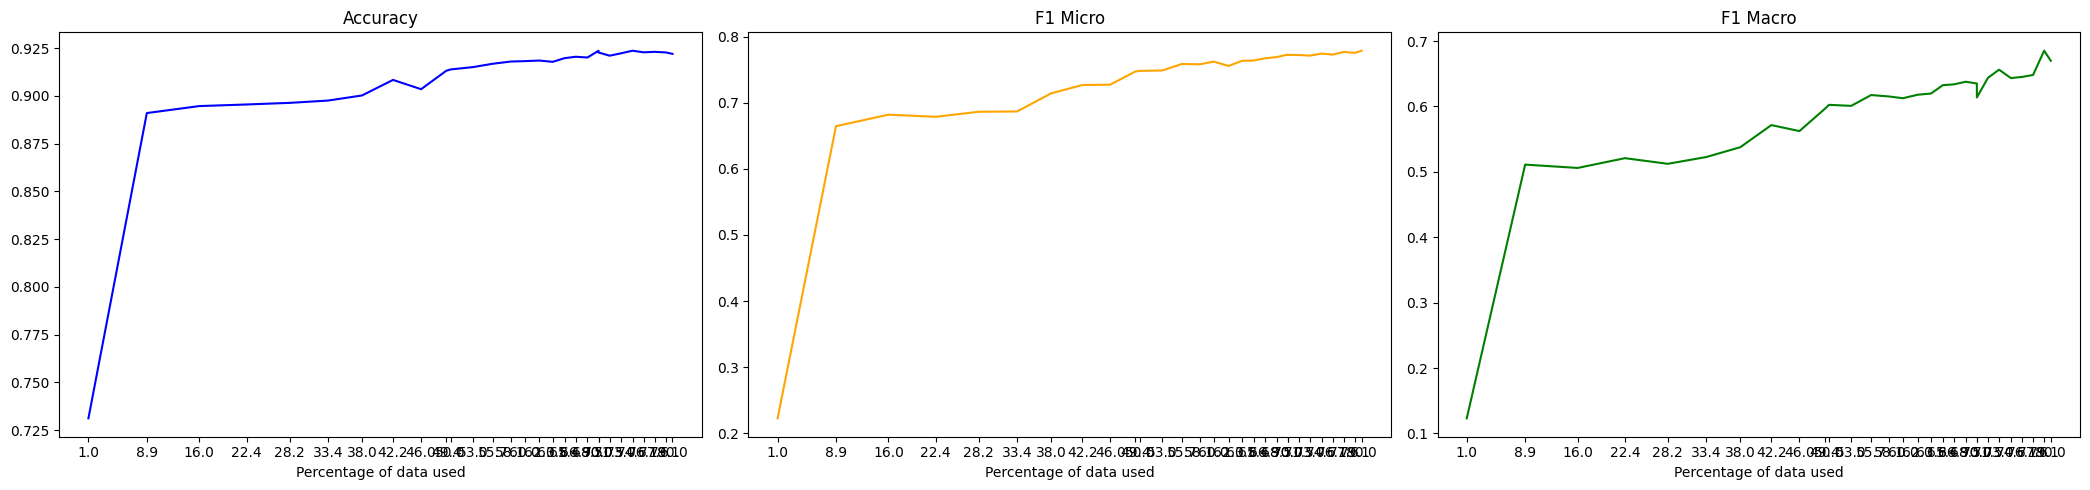

Result saved to results/hsd-lc-init-1-1-results.csv


In [26]:
initial_train_size = int(0.01 * total_data)
active_learning(50, 0, 'lc', 1)

Init Size: 10
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5474, Accuracy: 0.8279, F1 Micro: 0.0032, F1 Macro: 0.0013
Epoch 2/10, Train Loss: 0.4068, Accuracy: 0.8279, F1 Micro: 0.0018, F1 Macro: 0.0008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3684, Accuracy: 0.8403, F1 Micro: 0.161, F1 Macro: 0.0593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3529, Accuracy: 0.859, F1 Micro: 0.3835, F1 Macro: 0.1446
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3238, Accuracy: 0.8755, F1 Micro: 0.5261, F1 Macro: 0.2466
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2939, Accuracy: 0.8816, F1 Micro: 0.612, F1 Macro: 0.3107
Epoch 7/10, Train Loss: 0.2625, Accuracy: 0.8851, F1 Micro: 0.6102, F1 Macro: 0.3322
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.227, Accuracy: 0.887, F1 Micro: 0.6172, F1 Macro: 0.3778
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2146, Accuracy: 0.8885, F1 Micro: 0.6626, F1 Macro: 0.4638
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4577, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3015, Accuracy: 0.8285, F1 Micro: 0.0082, F1 Macro: 0.0038
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2711, Accuracy: 0.8543, F1 Micro: 0.4046, F1 Macro: 0.1726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2359, Accuracy: 0.8645, F1 Micro: 0.4356, F1 Macro: 0.1993
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.209, Accuracy: 0.8779, F1 Micro: 0.5674, F1 Macro: 0.2768
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1774, Accuracy: 0.8816, F1 Micro: 0.586, F1 Macro: 0.2999
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1507, Accuracy: 0.8848, F1 Micro: 0.6478, F1 Macro: 0.3696
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1408, Accuracy: 0.887, F1 Micro: 0.6532, F1 Macro: 0.4369
Epoch 9/10, Train Loss: 0.1284, Accuracy: 0.8891, F1 Micro: 0.620

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4039, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2559, Accuracy: 0.8294, F1 Micro: 0.0189, F1 Macro: 0.0085
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.221, Accuracy: 0.8628, F1 Micro: 0.4859, F1 Macro: 0.2146
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1891, Accuracy: 0.8675, F1 Micro: 0.4861, F1 Macro: 0.2267
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1542, Accuracy: 0.8789, F1 Micro: 0.5843, F1 Macro: 0.2843
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1376, Accuracy: 0.882, F1 Micro: 0.6228, F1 Macro: 0.3424
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1237, Accuracy: 0.8854, F1 Micro: 0.6594, F1 Macro: 0.4142
Epoch 8/10, Train Loss: 0.116, Accuracy: 0.8874, F1 Micro: 0.6394, F1 Macro: 0.4408
Epoch 9/10, Train Loss: 0.0949, Accuracy: 0.8894, F1 Micro: 0.6499, F1 Macro: 0.3946
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3668, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2328, Accuracy: 0.8288, F1 Micro: 0.0118, F1 Macro: 0.0054
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1943, Accuracy: 0.863, F1 Micro: 0.4692, F1 Macro: 0.2178
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1585, Accuracy: 0.8724, F1 Micro: 0.5115, F1 Macro: 0.24
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1444, Accuracy: 0.878, F1 Micro: 0.5491, F1 Macro: 0.2784
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1185, Accuracy: 0.8872, F1 Micro: 0.6444, F1 Macro: 0.401
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.8767, F1 Micro: 0.6708, F1 Macro: 0.443
Epoch 8/10, Train Loss: 0.0924, Accuracy: 0.8882, F1 Micro: 0.6694, F1 Macro: 0.441
Epoch 9/10, Train Loss: 0.0793, Accuracy: 0.8923, F1 Micro: 0.6627, F1 Macro: 0.4495
Higher F1 achieve

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3499, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2295, Accuracy: 0.8322, F1 Micro: 0.0552, F1 Macro: 0.0231
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1964, Accuracy: 0.8653, F1 Micro: 0.5563, F1 Macro: 0.2714
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.8791, F1 Micro: 0.5802, F1 Macro: 0.2975
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1355, Accuracy: 0.8844, F1 Micro: 0.5935, F1 Macro: 0.3164
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1116, Accuracy: 0.8884, F1 Micro: 0.6504, F1 Macro: 0.3936
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0977, Accuracy: 0.8894, F1 Micro: 0.6685, F1 Macro: 0.425
Epoch 8/10, Train Loss: 0.0812, Accuracy: 0.8904, F1 Micro: 0.6595, F1 Macro: 0.4476
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.8901, F1 Micro: 0.6

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3419, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2278, Accuracy: 0.832, F1 Micro: 0.0491, F1 Macro: 0.0207
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.8721, F1 Micro: 0.5285, F1 Macro: 0.2512
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.8804, F1 Micro: 0.557, F1 Macro: 0.2716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1375, Accuracy: 0.8903, F1 Micro: 0.6749, F1 Macro: 0.4165
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1134, Accuracy: 0.8924, F1 Micro: 0.6881, F1 Macro: 0.4734
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.8944, F1 Micro: 0.6856, F1 Macro: 0.4564
Epoch 8/10, Train Loss: 0.0827, Accuracy: 0.8953, F1 Micro: 0.6734, F1 Macro: 0.4448
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.897, F1 Micro: 0.6642, F1 Macro: 0.4778
Higher F1 achieved, saving model
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3308, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2348, Accuracy: 0.8392, F1 Micro: 0.1345, F1 Macro: 0.0557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.8765, F1 Micro: 0.5343, F1 Macro: 0.2703
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.8888, F1 Micro: 0.6334, F1 Macro: 0.3536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1367, Accuracy: 0.8872, F1 Micro: 0.6904, F1 Macro: 0.4709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.9003, F1 Micro: 0.6997, F1 Macro: 0.4685
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0974, Accuracy: 0.8969, F1 Micro: 0.7009, F1 Macro: 0.4992
Epoch 8/10, Train Loss: 0.0804, Accuracy: 0.9003, F1 Micro: 0.6919, F1 Macro: 0.4851
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0676, Accuracy: 0.9008, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3342, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2432, Accuracy: 0.8623, F1 Micro: 0.3964, F1 Macro: 0.1722
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2012, Accuracy: 0.882, F1 Micro: 0.6315, F1 Macro: 0.3874
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.8938, F1 Micro: 0.6615, F1 Macro: 0.4367
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.8994, F1 Micro: 0.6903, F1 Macro: 0.452
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1154, Accuracy: 0.8921, F1 Micro: 0.7053, F1 Macro: 0.5072
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.8989, F1 Micro: 0.7032, F1 Macro: 0.4858
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.9022, F1 Micro: 0.7211, F1 Macro: 0.5138
Epoch 9/10, Train Loss: 0.0655, Accuracy: 0.9031, F1 Micro: 0.7168, F1 Macro: 0.4993
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3421, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.8718, F1 Micro: 0.4794, F1 Macro: 0.2411
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.8946, F1 Micro: 0.6608, F1 Macro: 0.4128
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9008, F1 Micro: 0.6925, F1 Macro: 0.4959
Epoch 5/10, Train Loss: 0.1375, Accuracy: 0.9021, F1 Micro: 0.6803, F1 Macro: 0.4922
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1126, Accuracy: 0.907, F1 Micro: 0.7107, F1 Macro: 0.5145
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.094, Accuracy: 0.9049, F1 Micro: 0.7239, F1 Macro: 0.5594
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.9023, F1 Micro: 0.7215, F1 Macro: 0.5197
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.908, F1 Micro: 0.7176, F1 Macro: 0.5606
Higher F1 achieved, saving model
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3439, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.8596, F1 Micro: 0.3564, F1 Macro: 0.1711
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.8942, F1 Micro: 0.6589, F1 Macro: 0.4245
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.8988, F1 Micro: 0.6649, F1 Macro: 0.4437
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.9042, F1 Micro: 0.6939, F1 Macro: 0.5166
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1104, Accuracy: 0.9047, F1 Micro: 0.7097, F1 Macro: 0.5214
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0943, Accuracy: 0.9073, F1 Micro: 0.7216, F1 Macro: 0.5475
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0798, Accuracy: 0.9072, F1 Micro: 0.728, F1 Macro: 0.561
Epoch 9/10, Train Loss: 0.0654, Accuracy: 0.9051, F1 Micro: 0.71

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3617, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2549, Accuracy: 0.8721, F1 Micro: 0.4641, F1 Macro: 0.2531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2012, Accuracy: 0.8988, F1 Micro: 0.6959, F1 Macro: 0.4689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9058, F1 Micro: 0.7129, F1 Macro: 0.5456
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.9076, F1 Micro: 0.7175, F1 Macro: 0.5345
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1097, Accuracy: 0.9111, F1 Micro: 0.7316, F1 Macro: 0.583
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0968, Accuracy: 0.9129, F1 Micro: 0.7424, F1 Macro: 0.5967
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9115, F1 Micro: 0.7416, F1 Macro: 0.5997
Epoch 9/10, Train Loss: 0.0688, Accuracy: 0.9121, F1 Micro: 0.7416, F1 Macro: 0.6001
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3663, Accuracy: 0.8415, F1 Micro: 0.1693, F1 Macro: 0.0616
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2536, Accuracy: 0.8902, F1 Micro: 0.6102, F1 Macro: 0.4225
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1982, Accuracy: 0.9026, F1 Micro: 0.682, F1 Macro: 0.5013
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1595, Accuracy: 0.9107, F1 Micro: 0.7232, F1 Macro: 0.5685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1365, Accuracy: 0.9126, F1 Micro: 0.7456, F1 Macro: 0.5895
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1123, Accuracy: 0.9157, F1 Micro: 0.7461, F1 Macro: 0.5905
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0921, Accuracy: 0.9149, F1 Micro: 0.754, F1 Macro: 0.6127
Epoch 8/10, Train Loss: 0.0789, Accuracy: 0.9148, F1 Micro: 0.735, F1 Macro: 0.5774
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0655, Accuracy: 0.9165, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3727, Accuracy: 0.8507, F1 Micro: 0.2786, F1 Macro: 0.0982
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2514, Accuracy: 0.8965, F1 Micro: 0.6503, F1 Macro: 0.4217
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2049, Accuracy: 0.9077, F1 Micro: 0.7067, F1 Macro: 0.5203
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.9082, F1 Micro: 0.7407, F1 Macro: 0.5906
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.917, F1 Micro: 0.7479, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.9164, F1 Micro: 0.7489, F1 Macro: 0.5909
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.094, Accuracy: 0.9163, F1 Micro: 0.7536, F1 Macro: 0.6097
Epoch 8/10, Train Loss: 0.0796, Accuracy: 0.9161, F1 Micro: 0.7527, F1 Macro: 0.6083
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9163, F1 Micro: 0.7527, F1 Macro: 0.6103
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3707, Accuracy: 0.8518, F1 Micro: 0.279, F1 Macro: 0.112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2538, Accuracy: 0.8942, F1 Micro: 0.683, F1 Macro: 0.5067
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9083, F1 Micro: 0.7228, F1 Macro: 0.5455
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.9144, F1 Micro: 0.7301, F1 Macro: 0.5827
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9166, F1 Micro: 0.748, F1 Macro: 0.5948
Epoch 6/10, Train Loss: 0.1134, Accuracy: 0.9187, F1 Micro: 0.745, F1 Macro: 0.5918
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.9172, F1 Micro: 0.7491, F1 Macro: 0.5951
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.9184, F1 Micro: 0.7465, F1 Macro: 0.5999
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9177, F1 Micro: 0.7581, F1 Macro: 0.608
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3808, Accuracy: 0.8668, F1 Micro: 0.4343, F1 Macro: 0.1923
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2517, Accuracy: 0.8983, F1 Micro: 0.6578, F1 Macro: 0.4473
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.9068, F1 Micro: 0.6942, F1 Macro: 0.5439
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.913, F1 Micro: 0.7438, F1 Macro: 0.5794
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.9159, F1 Micro: 0.7521, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1136, Accuracy: 0.9166, F1 Micro: 0.7524, F1 Macro: 0.5984
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9156, F1 Micro: 0.7572, F1 Macro: 0.612
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9198, F1 Micro: 0.7535, F1 Macro: 0.6072
Epoch 9/10, Train Loss: 0.0682, Accuracy: 0.9153, F1 Micro: 0.7548, F1 Macro: 0.6051
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3764, Accuracy: 0.8695, F1 Micro: 0.4591, F1 Macro: 0.2121
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.8978, F1 Micro: 0.648, F1 Macro: 0.4443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2041, Accuracy: 0.9118, F1 Micro: 0.722, F1 Macro: 0.5634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9151, F1 Micro: 0.7512, F1 Macro: 0.5908
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1355, Accuracy: 0.9157, F1 Micro: 0.7569, F1 Macro: 0.593
Epoch 6/10, Train Loss: 0.1119, Accuracy: 0.9197, F1 Micro: 0.7456, F1 Macro: 0.5913
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.9189, F1 Micro: 0.7621, F1 Macro: 0.6164
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9193, F1 Micro: 0.7615, F1 Macro: 0.6131
Epoch 9/10, Train Loss: 0.0692, Accuracy: 0.9188, F1 Micro: 0.7545, F1 Macro: 0.6112
Epoch 10/10, Train Loss: 0.0593, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3795, Accuracy: 0.8748, F1 Micro: 0.5141, F1 Macro: 0.2525
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2507, Accuracy: 0.9011, F1 Micro: 0.6939, F1 Macro: 0.4644
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.9083, F1 Micro: 0.7298, F1 Macro: 0.5696
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.914, F1 Micro: 0.7515, F1 Macro: 0.5865
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9195, F1 Micro: 0.7476, F1 Macro: 0.5848
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.9205, F1 Micro: 0.7623, F1 Macro: 0.6023
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.919, F1 Micro: 0.7623, F1 Macro: 0.6202
Epoch 8/10, Train Loss: 0.0836, Accuracy: 0.922, F1 Micro: 0.7604, F1 Macro: 0.6272
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9195, F1 Micro: 0.7608, F1 Macro: 0.6306
Epoch 10/10, Train Loss: 0.0606, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3763, Accuracy: 0.8811, F1 Micro: 0.582, F1 Macro: 0.2914
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2471, Accuracy: 0.9022, F1 Micro: 0.7019, F1 Macro: 0.5152
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.202, Accuracy: 0.914, F1 Micro: 0.7287, F1 Macro: 0.5594
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9169, F1 Micro: 0.7547, F1 Macro: 0.6094
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.9194, F1 Micro: 0.7413, F1 Macro: 0.6018
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9191, F1 Micro: 0.7613, F1 Macro: 0.6081
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9198, F1 Micro: 0.7681, F1 Macro: 0.6241
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.9203, F1 Micro: 0.7594, F1 Macro: 0.6213
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.9204, F1 Micro: 0.7618, F1 Macro: 0.6318
Epoch 10/10, Train Loss: 0.0605, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3737, Accuracy: 0.875, F1 Micro: 0.4903, F1 Macro: 0.2367
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2492, Accuracy: 0.9027, F1 Micro: 0.7041, F1 Macro: 0.5024
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9138, F1 Micro: 0.7262, F1 Macro: 0.5667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.166, Accuracy: 0.917, F1 Micro: 0.747, F1 Macro: 0.6
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9194, F1 Micro: 0.7618, F1 Macro: 0.6134
Epoch 6/10, Train Loss: 0.1149, Accuracy: 0.9212, F1 Micro: 0.7612, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0994, Accuracy: 0.9187, F1 Micro: 0.766, F1 Macro: 0.6219
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9224, F1 Micro: 0.76, F1 Macro: 0.6271
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.9209, F1 Micro: 0.7574, F1 Macro: 0.6249
Epoch 10/10, Train Loss: 0.0631, Accuracy: 0.92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3771, Accuracy: 0.8827, F1 Micro: 0.5688, F1 Macro: 0.2807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2527, Accuracy: 0.9008, F1 Micro: 0.7055, F1 Macro: 0.5091
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2032, Accuracy: 0.9112, F1 Micro: 0.7395, F1 Macro: 0.5615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.9171, F1 Micro: 0.7423, F1 Macro: 0.5805
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.9225, F1 Micro: 0.7708, F1 Macro: 0.6217
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9232, F1 Micro: 0.7671, F1 Macro: 0.6349
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.923, F1 Micro: 0.772, F1 Macro: 0.6343
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9217, F1 Micro: 0.7648, F1 Macro: 0.6262
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.9231, F1 Micro: 0.7714, F1 Macro: 0.6428
Epoch 10/10, Train Loss: 0.0598, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3759, Accuracy: 0.8814, F1 Micro: 0.5783, F1 Macro: 0.2914
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2468, Accuracy: 0.9017, F1 Micro: 0.7124, F1 Macro: 0.5246
Epoch 3/10, Train Loss: 0.1983, Accuracy: 0.9128, F1 Micro: 0.7109, F1 Macro: 0.5364
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.9174, F1 Micro: 0.7528, F1 Macro: 0.5946
Epoch 5/10, Train Loss: 0.1368, Accuracy: 0.9179, F1 Micro: 0.7484, F1 Macro: 0.6083
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9205, F1 Micro: 0.7648, F1 Macro: 0.6112
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.9204, F1 Micro: 0.7592, F1 Macro: 0.6242
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.9224, F1 Micro: 0.7598, F1 Macro: 0.6287
Epoch 9/10, Train Loss: 0.073, Accuracy: 0.9206, F1 Micro: 0.7629, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.063, Accuracy: 0.9197, F1 Micro: 0.7661, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3757, Accuracy: 0.877, F1 Micro: 0.5101, F1 Macro: 0.2529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2478, Accuracy: 0.9042, F1 Micro: 0.7053, F1 Macro: 0.5052
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9124, F1 Micro: 0.7355, F1 Macro: 0.5438
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9187, F1 Micro: 0.7612, F1 Macro: 0.5921
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1365, Accuracy: 0.9205, F1 Micro: 0.7637, F1 Macro: 0.6019
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.9237, F1 Micro: 0.7746, F1 Macro: 0.6343
Epoch 7/10, Train Loss: 0.094, Accuracy: 0.9185, F1 Micro: 0.7722, F1 Macro: 0.6433
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.9247, F1 Micro: 0.7766, F1 Macro: 0.6477
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.9228, F1 Micro: 0.7627, F1 Macro: 0.6331
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.375, Accuracy: 0.8869, F1 Micro: 0.6327, F1 Macro: 0.3223
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2488, Accuracy: 0.9066, F1 Micro: 0.6879, F1 Macro: 0.4977
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.915, F1 Micro: 0.726, F1 Macro: 0.5628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1671, Accuracy: 0.9189, F1 Micro: 0.7648, F1 Macro: 0.6162
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.924, F1 Micro: 0.7734, F1 Macro: 0.6296
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1145, Accuracy: 0.9229, F1 Micro: 0.7753, F1 Macro: 0.6409
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.9244, F1 Micro: 0.7634, F1 Macro: 0.6295
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.9213, F1 Micro: 0.7726, F1 Macro: 0.646
Epoch 9/10, Train Loss: 0.0696, Accuracy: 0.9223, F1 Micro: 0.7707, F1 Macro: 0.6503
Epoch 10/10, Train Loss: 0.0598, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3774, Accuracy: 0.8808, F1 Micro: 0.556, F1 Macro: 0.2803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2497, Accuracy: 0.9071, F1 Micro: 0.7031, F1 Macro: 0.5056
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.9145, F1 Micro: 0.7232, F1 Macro: 0.5441
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.9171, F1 Micro: 0.7636, F1 Macro: 0.6218
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.9235, F1 Micro: 0.7677, F1 Macro: 0.6306
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.9208, F1 Micro: 0.7737, F1 Macro: 0.6474
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9245, F1 Micro: 0.769, F1 Macro: 0.638
Epoch 8/10, Train Loss: 0.0818, Accuracy: 0.9175, F1 Micro: 0.7667, F1 Macro: 0.6312
Epoch 9/10, Train Loss: 0.0682, Accuracy: 0.9213, F1 Micro: 0.769, F1 Macro: 0.6416
Epoch 10/10, Train Loss: 0.0602, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3745, Accuracy: 0.8846, F1 Micro: 0.5874, F1 Macro: 0.287
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2471, Accuracy: 0.9056, F1 Micro: 0.6829, F1 Macro: 0.5163
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1981, Accuracy: 0.9171, F1 Micro: 0.7435, F1 Macro: 0.5812
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9195, F1 Micro: 0.7503, F1 Macro: 0.5969
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.919, F1 Micro: 0.7454, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.113, Accuracy: 0.9236, F1 Micro: 0.7779, F1 Macro: 0.6466
Epoch 7/10, Train Loss: 0.0964, Accuracy: 0.9236, F1 Micro: 0.7691, F1 Macro: 0.6304
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9202, F1 Micro: 0.7701, F1 Macro: 0.6458
Epoch 9/10, Train Loss: 0.067, Accuracy: 0.9215, F1 Micro: 0.7672, F1 Macro: 0.6484
Epoch 10/10, Train Loss: 0.0598, Accuracy: 0.9225, F1 Micro: 0.7685, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3753, Accuracy: 0.8862, F1 Micro: 0.6039, F1 Macro: 0.31
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2476, Accuracy: 0.9075, F1 Micro: 0.7248, F1 Macro: 0.5311
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.9157, F1 Micro: 0.7343, F1 Macro: 0.5677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.9194, F1 Micro: 0.7624, F1 Macro: 0.6133
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1413, Accuracy: 0.9193, F1 Micro: 0.7706, F1 Macro: 0.6361
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9237, F1 Micro: 0.7736, F1 Macro: 0.6398
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.923, F1 Micro: 0.7751, F1 Macro: 0.662
Epoch 8/10, Train Loss: 0.0845, Accuracy: 0.9243, F1 Micro: 0.7698, F1 Macro: 0.655
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9214, F1 Micro: 0.772, F1 Macro: 0.6748
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.373, Accuracy: 0.886, F1 Micro: 0.5878, F1 Macro: 0.2916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2466, Accuracy: 0.9079, F1 Micro: 0.7008, F1 Macro: 0.522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1944, Accuracy: 0.9156, F1 Micro: 0.7452, F1 Macro: 0.5733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1611, Accuracy: 0.915, F1 Micro: 0.7478, F1 Macro: 0.6078
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.9231, F1 Micro: 0.7645, F1 Macro: 0.6483
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.116, Accuracy: 0.9217, F1 Micro: 0.7711, F1 Macro: 0.6609
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.097, Accuracy: 0.9261, F1 Micro: 0.7767, F1 Macro: 0.6802
Epoch 8/10, Train Loss: 0.0804, Accuracy: 0.9231, F1 Micro: 0.7749, F1 Macro: 0.6891
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.9216, F1 Micro: 0.7719, F1 Macro: 0.6828
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.374, Accuracy: 0.885, F1 Micro: 0.5786, F1 Macro: 0.2897
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.245, Accuracy: 0.9076, F1 Micro: 0.7204, F1 Macro: 0.5312
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2007, Accuracy: 0.9096, F1 Micro: 0.7458, F1 Macro: 0.5888
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.9208, F1 Micro: 0.7574, F1 Macro: 0.6138
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9242, F1 Micro: 0.7736, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.9227, F1 Micro: 0.7755, F1 Macro: 0.6859
Epoch 7/10, Train Loss: 0.0962, Accuracy: 0.9217, F1 Micro: 0.7698, F1 Macro: 0.677
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9221, F1 Micro: 0.773, F1 Macro: 0.6968
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9245, F1 Micro: 0.7781, F1 Macro: 0.7022
Epoch 10/

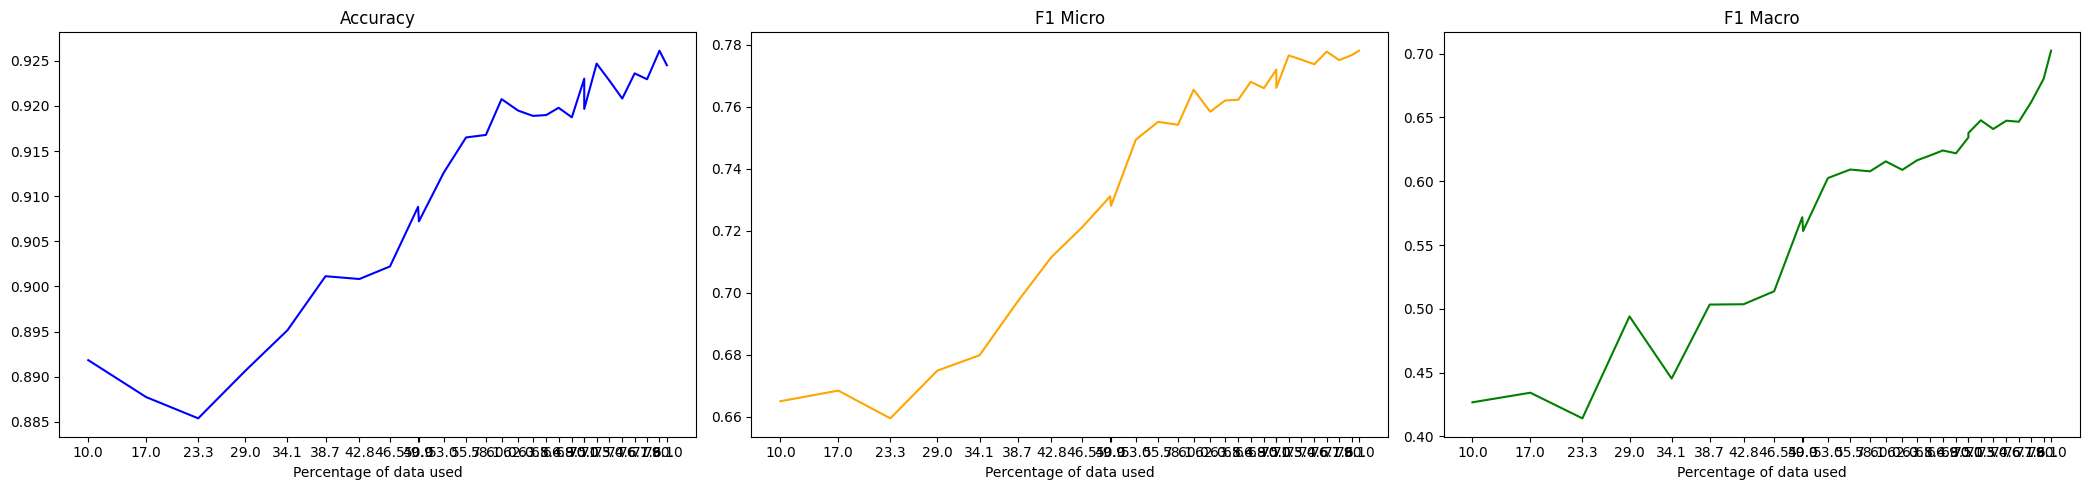

Result saved to results/hsd-lc-init-10-1-results.csv


In [27]:
initial_train_size = int(0.1 * total_data)
active_learning(50, 0, 'lc', 10)

# MONTE CARLO DROPOUT

Init Size: 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6814, Accuracy: 0.7312, F1 Micro: 0.2228, F1 Macro: 0.123
Epoch 2/10, Train Loss: 0.5938, Accuracy: 0.8056, F1 Micro: 0.1568, F1 Macro: 0.0557
Epoch 3/10, Train Loss: 0.5257, Accuracy: 0.8219, F1 Micro: 0.0493, F1 Macro: 0.0222
Epoch 4/10, Train Loss: 0.4783, Accuracy: 0.8273, F1 Micro: 0.0025, F1 Macro: 0.0014
Epoch 5/10, Train Loss: 0.4275, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 6/10, Train Loss: 0.3998, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 7/10, Train Loss: 0.3716, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 8/10, Train Loss: 0.3814, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 9/10, Train Loss: 0.4033, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 10/10, Train Loss: 0.3566, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Iteration 131: Accuracy: 0.7312, F1 Micro: 0.2228, F1 Macro: 0.123
               precision    recall  f1-score   support

           HS       0.38      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5569, Accuracy: 0.8279, F1 Micro: 0.0174, F1 Macro: 0.0067
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4184, Accuracy: 0.8299, F1 Micro: 0.0266, F1 Macro: 0.0116
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3829, Accuracy: 0.8342, F1 Micro: 0.0827, F1 Macro: 0.032
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3536, Accuracy: 0.8545, F1 Micro: 0.3525, F1 Macro: 0.1175
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3409, Accuracy: 0.87, F1 Micro: 0.5316, F1 Macro: 0.239
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3056, Accuracy: 0.8766, F1 Micro: 0.5853, F1 Macro: 0.2822
Epoch 7/10, Train Loss: 0.2711, Accuracy: 0.8794, F1 Micro: 0.5816, F1 Macro: 0.2966
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.252, Accuracy: 0.8827, F1 Micro: 0.631, F1 Macro: 0.3469
Epoch 9/10, Train Loss: 0.2232, Accuracy: 0.8822, F1 Micro: 0.5881, F1 Macro: 0.3264
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5166, Accuracy: 0.832, F1 Micro: 0.4156, F1 Macro: 0.1106
Epoch 2/10, Train Loss: 0.4179, Accuracy: 0.8526, F1 Micro: 0.3557, F1 Macro: 0.1106
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3919, Accuracy: 0.8612, F1 Micro: 0.43, F1 Macro: 0.1447
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3578, Accuracy: 0.8807, F1 Micro: 0.6394, F1 Macro: 0.3308
Epoch 5/10, Train Loss: 0.3201, Accuracy: 0.8897, F1 Micro: 0.6259, F1 Macro: 0.3537
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2756, Accuracy: 0.8938, F1 Micro: 0.6436, F1 Macro: 0.3976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2499, Accuracy: 0.8951, F1 Micro: 0.6465, F1 Macro: 0.3788
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2153, Accuracy: 0.9003, F1 Micro: 0.6847, F1 Macro: 0.4923
Epoch 9/10, Train Loss: 0.1883, Accuracy: 0.9016, F1 Micro: 0.6832, F1 Macro: 0.4744
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.493, Accuracy: 0.8356, F1 Micro: 0.4034, F1 Macro: 0.1101
Epoch 2/10, Train Loss: 0.409, Accuracy: 0.8525, F1 Micro: 0.3795, F1 Macro: 0.1145
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3791, Accuracy: 0.8823, F1 Micro: 0.6018, F1 Macro: 0.2807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3303, Accuracy: 0.8935, F1 Micro: 0.6811, F1 Macro: 0.4177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2809, Accuracy: 0.9008, F1 Micro: 0.6967, F1 Macro: 0.4865
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2461, Accuracy: 0.9014, F1 Micro: 0.71, F1 Macro: 0.5197
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2077, Accuracy: 0.9079, F1 Micro: 0.7127, F1 Macro: 0.5224
Epoch 8/10, Train Loss: 0.1778, Accuracy: 0.9075, F1 Micro: 0.7126, F1 Macro: 0.5382
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1542, Accuracy: 0.9112, F1 Micro: 0.7203, F1 Macro: 0.5462
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4869, Accuracy: 0.8256, F1 Micro: 0.3913, F1 Macro: 0.1057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4116, Accuracy: 0.8557, F1 Micro: 0.4422, F1 Macro: 0.154
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3669, Accuracy: 0.8889, F1 Micro: 0.6228, F1 Macro: 0.3576
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3203, Accuracy: 0.902, F1 Micro: 0.6968, F1 Macro: 0.481
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2794, Accuracy: 0.9077, F1 Micro: 0.706, F1 Macro: 0.4992
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2359, Accuracy: 0.9042, F1 Micro: 0.726, F1 Macro: 0.5578
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.204, Accuracy: 0.9131, F1 Micro: 0.7383, F1 Macro: 0.5722
Epoch 8/10, Train Loss: 0.1688, Accuracy: 0.9144, F1 Micro: 0.7383, F1 Macro: 0.5886
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1466, Accuracy: 0.9117, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4782, Accuracy: 0.8318, F1 Micro: 0.4, F1 Macro: 0.1088
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3979, Accuracy: 0.8798, F1 Micro: 0.5808, F1 Macro: 0.2642
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3484, Accuracy: 0.8979, F1 Micro: 0.6642, F1 Macro: 0.4344
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2977, Accuracy: 0.9061, F1 Micro: 0.724, F1 Macro: 0.5341
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2538, Accuracy: 0.9091, F1 Micro: 0.7313, F1 Macro: 0.539
Epoch 6/10, Train Loss: 0.2111, Accuracy: 0.9124, F1 Micro: 0.7287, F1 Macro: 0.5738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1764, Accuracy: 0.9134, F1 Micro: 0.7479, F1 Macro: 0.5744
Epoch 8/10, Train Loss: 0.1539, Accuracy: 0.9154, F1 Micro: 0.746, F1 Macro: 0.6069
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1301, Accuracy: 0.9143, F1 Micro: 0.7512, F1 Macro: 0.6126
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4734, Accuracy: 0.8349, F1 Micro: 0.4043, F1 Macro: 0.1104
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3862, Accuracy: 0.888, F1 Micro: 0.6171, F1 Macro: 0.3233
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3334, Accuracy: 0.9047, F1 Micro: 0.683, F1 Macro: 0.47
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2869, Accuracy: 0.9112, F1 Micro: 0.7145, F1 Macro: 0.5345
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2489, Accuracy: 0.9147, F1 Micro: 0.7479, F1 Macro: 0.5767
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2031, Accuracy: 0.9157, F1 Micro: 0.7552, F1 Macro: 0.601
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1708, Accuracy: 0.9173, F1 Micro: 0.7579, F1 Macro: 0.6338
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1453, Accuracy: 0.922, F1 Micro: 0.7633, F1 Macro: 0.6561
Epoch 9/10, Train Loss: 0.1253, Accuracy: 0.9206, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4695, Accuracy: 0.8371, F1 Micro: 0.4148, F1 Macro: 0.1264
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.382, Accuracy: 0.8929, F1 Micro: 0.6647, F1 Macro: 0.3899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3184, Accuracy: 0.9079, F1 Micro: 0.7258, F1 Macro: 0.5347
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2786, Accuracy: 0.9118, F1 Micro: 0.7507, F1 Macro: 0.5975
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2345, Accuracy: 0.9182, F1 Micro: 0.7574, F1 Macro: 0.6113
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1982, Accuracy: 0.9171, F1 Micro: 0.7632, F1 Macro: 0.6368
Epoch 7/10, Train Loss: 0.1628, Accuracy: 0.922, F1 Micro: 0.7613, F1 Macro: 0.6461
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1351, Accuracy: 0.9198, F1 Micro: 0.7656, F1 Macro: 0.6438
Epoch 9/10, Train Loss: 0.121, Accuracy: 0.9209, F1 Micro: 0.7625, F1 Macro: 0.645
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4621, Accuracy: 0.8478, F1 Micro: 0.4562, F1 Macro: 0.1815
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.366, Accuracy: 0.8977, F1 Micro: 0.6906, F1 Macro: 0.4573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3051, Accuracy: 0.9124, F1 Micro: 0.7229, F1 Macro: 0.5584
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2666, Accuracy: 0.9168, F1 Micro: 0.7428, F1 Macro: 0.5834
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2209, Accuracy: 0.9191, F1 Micro: 0.7459, F1 Macro: 0.6286
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1886, Accuracy: 0.9215, F1 Micro: 0.7701, F1 Macro: 0.6628
Epoch 7/10, Train Loss: 0.1633, Accuracy: 0.9193, F1 Micro: 0.7592, F1 Macro: 0.6505
Epoch 8/10, Train Loss: 0.1354, Accuracy: 0.9214, F1 Micro: 0.77, F1 Macro: 0.6768
Epoch 9/10, Train Loss: 0.1132, Accuracy: 0.9225, F1 Micro: 0.7691, F1 Macro: 0.6668
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4619, Accuracy: 0.8566, F1 Micro: 0.4738, F1 Macro: 0.1925
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3577, Accuracy: 0.9006, F1 Micro: 0.6889, F1 Macro: 0.476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2997, Accuracy: 0.9131, F1 Micro: 0.7383, F1 Macro: 0.571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2496, Accuracy: 0.9183, F1 Micro: 0.7508, F1 Macro: 0.5945
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2104, Accuracy: 0.9225, F1 Micro: 0.7617, F1 Macro: 0.6487
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1829, Accuracy: 0.9215, F1 Micro: 0.7715, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1501, Accuracy: 0.9235, F1 Micro: 0.7729, F1 Macro: 0.6784
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1314, Accuracy: 0.9247, F1 Micro: 0.7782, F1 Macro: 0.6816
Epoch 9/10, Train Loss: 0.1069, Accuracy: 0.9225, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4596, Accuracy: 0.8566, F1 Micro: 0.5034, F1 Macro: 0.2225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3534, Accuracy: 0.9008, F1 Micro: 0.7026, F1 Macro: 0.5216
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2915, Accuracy: 0.9116, F1 Micro: 0.7381, F1 Macro: 0.5825
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2449, Accuracy: 0.9186, F1 Micro: 0.7482, F1 Macro: 0.5986
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2147, Accuracy: 0.9213, F1 Micro: 0.7616, F1 Macro: 0.6209
Epoch 6/10, Train Loss: 0.1764, Accuracy: 0.9211, F1 Micro: 0.7573, F1 Macro: 0.6476
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.145, Accuracy: 0.9212, F1 Micro: 0.7712, F1 Macro: 0.6664
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1235, Accuracy: 0.923, F1 Micro: 0.7739, F1 Macro: 0.6703
Epoch 9/10, Train Loss: 0.1069, Accuracy: 0.9237, F1 Micro: 0.7692, F1 Macro: 0.6529
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.452, Accuracy: 0.8705, F1 Micro: 0.586, F1 Macro: 0.2847
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3423, Accuracy: 0.9054, F1 Micro: 0.7007, F1 Macro: 0.5262
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2839, Accuracy: 0.9149, F1 Micro: 0.7433, F1 Macro: 0.5848
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2401, Accuracy: 0.9126, F1 Micro: 0.756, F1 Macro: 0.6098
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2077, Accuracy: 0.9222, F1 Micro: 0.7734, F1 Macro: 0.6481
Epoch 6/10, Train Loss: 0.1692, Accuracy: 0.9234, F1 Micro: 0.7725, F1 Macro: 0.6619
Epoch 7/10, Train Loss: 0.1386, Accuracy: 0.9231, F1 Micro: 0.7708, F1 Macro: 0.6723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.12, Accuracy: 0.9231, F1 Micro: 0.7742, F1 Macro: 0.6863
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1047, Accuracy: 0.925, F1 Micro: 0.7789, F1 Macro: 0.6831
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4457, Accuracy: 0.8755, F1 Micro: 0.5829, F1 Macro: 0.291
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3303, Accuracy: 0.9057, F1 Micro: 0.7058, F1 Macro: 0.5207
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.272, Accuracy: 0.9144, F1 Micro: 0.7354, F1 Macro: 0.5642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2323, Accuracy: 0.9197, F1 Micro: 0.7594, F1 Macro: 0.6046
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1921, Accuracy: 0.9172, F1 Micro: 0.7661, F1 Macro: 0.6593
Epoch 6/10, Train Loss: 0.165, Accuracy: 0.9233, F1 Micro: 0.7613, F1 Macro: 0.6357
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1361, Accuracy: 0.9234, F1 Micro: 0.7721, F1 Macro: 0.6609
Epoch 8/10, Train Loss: 0.1158, Accuracy: 0.9235, F1 Micro: 0.7675, F1 Macro: 0.6707
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0975, Accuracy: 0.9234, F1 Micro: 0.7768, F1 Macro: 0.6948
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4413, Accuracy: 0.877, F1 Micro: 0.5631, F1 Macro: 0.2674
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3309, Accuracy: 0.9054, F1 Micro: 0.6886, F1 Macro: 0.5004
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2689, Accuracy: 0.9163, F1 Micro: 0.7385, F1 Macro: 0.5723
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2261, Accuracy: 0.92, F1 Micro: 0.7565, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1905, Accuracy: 0.9219, F1 Micro: 0.7653, F1 Macro: 0.6392
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1589, Accuracy: 0.9253, F1 Micro: 0.7659, F1 Macro: 0.6482
Epoch 7/10, Train Loss: 0.136, Accuracy: 0.9136, F1 Micro: 0.7637, F1 Macro: 0.6673
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1159, Accuracy: 0.922, F1 Micro: 0.7715, F1 Macro: 0.6877
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.097, Accuracy: 0.9233, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4359, Accuracy: 0.8829, F1 Micro: 0.622, F1 Macro: 0.3125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3203, Accuracy: 0.9055, F1 Micro: 0.7047, F1 Macro: 0.5223
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.265, Accuracy: 0.9139, F1 Micro: 0.7234, F1 Macro: 0.5627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2178, Accuracy: 0.9178, F1 Micro: 0.7561, F1 Macro: 0.5947
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1914, Accuracy: 0.9225, F1 Micro: 0.7607, F1 Macro: 0.639
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1584, Accuracy: 0.9226, F1 Micro: 0.7631, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1285, Accuracy: 0.9239, F1 Micro: 0.7732, F1 Macro: 0.6731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1167, Accuracy: 0.9249, F1 Micro: 0.7764, F1 Macro: 0.691
Epoch 9/10, Train Loss: 0.0999, Accuracy: 0.9202, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4319, Accuracy: 0.8848, F1 Micro: 0.6211, F1 Macro: 0.3156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3078, Accuracy: 0.9066, F1 Micro: 0.6953, F1 Macro: 0.5118
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2507, Accuracy: 0.9157, F1 Micro: 0.7445, F1 Macro: 0.5655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2151, Accuracy: 0.9166, F1 Micro: 0.76, F1 Macro: 0.6206
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1819, Accuracy: 0.922, F1 Micro: 0.7655, F1 Macro: 0.6455
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1496, Accuracy: 0.9228, F1 Micro: 0.7707, F1 Macro: 0.6588
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1282, Accuracy: 0.9258, F1 Micro: 0.7711, F1 Macro: 0.6596
Epoch 8/10, Train Loss: 0.1073, Accuracy: 0.9242, F1 Micro: 0.7705, F1 Macro: 0.6845
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0953, Accuracy: 0.9243, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4273, Accuracy: 0.8853, F1 Micro: 0.6289, F1 Macro: 0.3179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3027, Accuracy: 0.9045, F1 Micro: 0.7136, F1 Macro: 0.5283
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.25, Accuracy: 0.9142, F1 Micro: 0.7478, F1 Macro: 0.5896
Epoch 4/10, Train Loss: 0.2083, Accuracy: 0.9198, F1 Micro: 0.7397, F1 Macro: 0.5888
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1753, Accuracy: 0.9208, F1 Micro: 0.7701, F1 Macro: 0.6449
Epoch 6/10, Train Loss: 0.1493, Accuracy: 0.9198, F1 Micro: 0.7657, F1 Macro: 0.637
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1287, Accuracy: 0.9253, F1 Micro: 0.7795, F1 Macro: 0.6898
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1038, Accuracy: 0.9267, F1 Micro: 0.7809, F1 Macro: 0.6785
Epoch 9/10, Train Loss: 0.0936, Accuracy: 0.9248, F1 Micro: 0.7748, F1 Macro: 0.6942
Epoch 10/10, Train Loss: 0.081, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4202, Accuracy: 0.8864, F1 Micro: 0.614, F1 Macro: 0.3037
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2978, Accuracy: 0.9068, F1 Micro: 0.7182, F1 Macro: 0.5286
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2433, Accuracy: 0.9161, F1 Micro: 0.7485, F1 Macro: 0.5903
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2069, Accuracy: 0.9203, F1 Micro: 0.7501, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1756, Accuracy: 0.919, F1 Micro: 0.7688, F1 Macro: 0.6482
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1418, Accuracy: 0.9241, F1 Micro: 0.7775, F1 Macro: 0.6789
Epoch 7/10, Train Loss: 0.1222, Accuracy: 0.9215, F1 Micro: 0.7725, F1 Macro: 0.685
Epoch 8/10, Train Loss: 0.1029, Accuracy: 0.9207, F1 Micro: 0.7714, F1 Macro: 0.6908
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0857, Accuracy: 0.9249, F1 Micro: 0.7776, F1 Macro: 0.6985
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4179, Accuracy: 0.8855, F1 Micro: 0.6162, F1 Macro: 0.3093
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2931, Accuracy: 0.908, F1 Micro: 0.7109, F1 Macro: 0.5277
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2414, Accuracy: 0.9167, F1 Micro: 0.7498, F1 Macro: 0.596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2036, Accuracy: 0.9206, F1 Micro: 0.7551, F1 Macro: 0.6145
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1673, Accuracy: 0.9223, F1 Micro: 0.7595, F1 Macro: 0.6264
Epoch 6/10, Train Loss: 0.1364, Accuracy: 0.9233, F1 Micro: 0.7553, F1 Macro: 0.6492
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1178, Accuracy: 0.9224, F1 Micro: 0.775, F1 Macro: 0.6883
Epoch 8/10, Train Loss: 0.104, Accuracy: 0.9173, F1 Micro: 0.768, F1 Macro: 0.6714
Epoch 9/10, Train Loss: 0.0872, Accuracy: 0.9221, F1 Micro: 0.7731, F1 Macro: 0.6952
Epoch 10/10, Train Loss: 0.0768, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4117, Accuracy: 0.8852, F1 Micro: 0.6398, F1 Macro: 0.3212
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2859, Accuracy: 0.9076, F1 Micro: 0.7068, F1 Macro: 0.4957
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2375, Accuracy: 0.9165, F1 Micro: 0.7398, F1 Macro: 0.5795
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1979, Accuracy: 0.9214, F1 Micro: 0.7576, F1 Macro: 0.6094
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.171, Accuracy: 0.9207, F1 Micro: 0.7702, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1447, Accuracy: 0.9244, F1 Micro: 0.7758, F1 Macro: 0.6772
Epoch 7/10, Train Loss: 0.1181, Accuracy: 0.9224, F1 Micro: 0.7735, F1 Macro: 0.6804
Epoch 8/10, Train Loss: 0.1033, Accuracy: 0.924, F1 Micro: 0.7714, F1 Macro: 0.6606
Epoch 9/10, Train Loss: 0.0864, Accuracy: 0.9228, F1 Micro: 0.774, F1 Macro: 0.7028
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4068, Accuracy: 0.8867, F1 Micro: 0.6137, F1 Macro: 0.3064
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2815, Accuracy: 0.9061, F1 Micro: 0.6888, F1 Macro: 0.5132
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2321, Accuracy: 0.9146, F1 Micro: 0.7496, F1 Macro: 0.5694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1878, Accuracy: 0.9204, F1 Micro: 0.7617, F1 Macro: 0.615
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1673, Accuracy: 0.9221, F1 Micro: 0.7681, F1 Macro: 0.6575
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.9233, F1 Micro: 0.7683, F1 Macro: 0.6665
Epoch 7/10, Train Loss: 0.118, Accuracy: 0.9235, F1 Micro: 0.7682, F1 Macro: 0.6866
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9249, F1 Micro: 0.7777, F1 Macro: 0.6666
Epoch 9/10, Train Loss: 0.0824, Accuracy: 0.9244, F1 Micro: 0.7686, F1 Macro: 0.6873
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4046, Accuracy: 0.8868, F1 Micro: 0.6393, F1 Macro: 0.3243
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2815, Accuracy: 0.905, F1 Micro: 0.722, F1 Macro: 0.5333
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.232, Accuracy: 0.9161, F1 Micro: 0.7374, F1 Macro: 0.5871
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.195, Accuracy: 0.9199, F1 Micro: 0.7636, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1621, Accuracy: 0.9237, F1 Micro: 0.7719, F1 Macro: 0.6402
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1368, Accuracy: 0.924, F1 Micro: 0.7738, F1 Macro: 0.6833
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1131, Accuracy: 0.9248, F1 Micro: 0.7755, F1 Macro: 0.6897
Epoch 8/10, Train Loss: 0.0981, Accuracy: 0.921, F1 Micro: 0.773, F1 Macro: 0.663
Epoch 9/10, Train Loss: 0.0822, Accuracy: 0.9194, F1 Micro: 0.7682, F1 Macro: 0.6893
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4043, Accuracy: 0.8856, F1 Micro: 0.5978, F1 Macro: 0.2955
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2771, Accuracy: 0.9028, F1 Micro: 0.6601, F1 Macro: 0.4502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2259, Accuracy: 0.916, F1 Micro: 0.743, F1 Macro: 0.5895
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1891, Accuracy: 0.9199, F1 Micro: 0.7601, F1 Macro: 0.6166
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1617, Accuracy: 0.9217, F1 Micro: 0.766, F1 Macro: 0.6612
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1346, Accuracy: 0.9241, F1 Micro: 0.7714, F1 Macro: 0.6735
Epoch 7/10, Train Loss: 0.1152, Accuracy: 0.9239, F1 Micro: 0.7638, F1 Macro: 0.665
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.9235, F1 Micro: 0.7705, F1 Macro: 0.6683
Epoch 9/10, Train Loss: 0.0801, Accuracy: 0.9215, F1 Micro: 0.7689, F1 Macro: 0.6833
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3963, Accuracy: 0.8822, F1 Micro: 0.5591, F1 Macro: 0.2779
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2728, Accuracy: 0.9082, F1 Micro: 0.7144, F1 Macro: 0.519
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2169, Accuracy: 0.9172, F1 Micro: 0.7527, F1 Macro: 0.5964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1856, Accuracy: 0.9203, F1 Micro: 0.7612, F1 Macro: 0.6116
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1571, Accuracy: 0.9204, F1 Micro: 0.769, F1 Macro: 0.659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9203, F1 Micro: 0.7716, F1 Macro: 0.6522
Epoch 7/10, Train Loss: 0.1112, Accuracy: 0.9235, F1 Micro: 0.7634, F1 Macro: 0.637
Epoch 8/10, Train Loss: 0.0927, Accuracy: 0.9207, F1 Micro: 0.763, F1 Macro: 0.6843
Epoch 9/10, Train Loss: 0.0803, Accuracy: 0.9238, F1 Micro: 0.7703, F1 Macro: 0.6669
Epoch 10/10, Train Loss: 0.0685, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3928, Accuracy: 0.8883, F1 Micro: 0.6128, F1 Macro: 0.325
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2676, Accuracy: 0.907, F1 Micro: 0.7141, F1 Macro: 0.5128
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2163, Accuracy: 0.9155, F1 Micro: 0.7477, F1 Macro: 0.5718
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1807, Accuracy: 0.9206, F1 Micro: 0.7671, F1 Macro: 0.6327
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1551, Accuracy: 0.9238, F1 Micro: 0.7709, F1 Macro: 0.6402
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1317, Accuracy: 0.919, F1 Micro: 0.7728, F1 Macro: 0.674
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.109, Accuracy: 0.9218, F1 Micro: 0.7759, F1 Macro: 0.6738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9253, F1 Micro: 0.7807, F1 Macro: 0.6959
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.9222, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3848, Accuracy: 0.8887, F1 Micro: 0.6421, F1 Macro: 0.3301
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2595, Accuracy: 0.9083, F1 Micro: 0.7186, F1 Macro: 0.5253
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2098, Accuracy: 0.9163, F1 Micro: 0.7315, F1 Macro: 0.5692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1777, Accuracy: 0.9217, F1 Micro: 0.7642, F1 Macro: 0.6146
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1447, Accuracy: 0.9213, F1 Micro: 0.7678, F1 Macro: 0.6506
Epoch 6/10, Train Loss: 0.1238, Accuracy: 0.9171, F1 Micro: 0.7649, F1 Macro: 0.6619
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9246, F1 Micro: 0.7724, F1 Macro: 0.6803
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9236, F1 Micro: 0.7632, F1 Macro: 0.6701
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.075, Accuracy: 0.9262, F1 Micro: 0.7777, F1 Macro: 0.7012
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3846, Accuracy: 0.8864, F1 Micro: 0.6576, F1 Macro: 0.3463
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2566, Accuracy: 0.9071, F1 Micro: 0.7132, F1 Macro: 0.5074
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2101, Accuracy: 0.9132, F1 Micro: 0.7506, F1 Macro: 0.5921
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.9195, F1 Micro: 0.7626, F1 Macro: 0.6233
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.921, F1 Micro: 0.7697, F1 Macro: 0.6479
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1233, Accuracy: 0.921, F1 Micro: 0.7727, F1 Macro: 0.655
Epoch 7/10, Train Loss: 0.1014, Accuracy: 0.9238, F1 Micro: 0.7719, F1 Macro: 0.6712
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9216, F1 Micro: 0.7723, F1 Macro: 0.6877
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0764, Accuracy: 0.9241, F1 Micro: 0.7766, F1 Macro: 0.7017
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3773, Accuracy: 0.8892, F1 Micro: 0.6295, F1 Macro: 0.338
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2497, Accuracy: 0.9081, F1 Micro: 0.728, F1 Macro: 0.558
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2077, Accuracy: 0.916, F1 Micro: 0.7324, F1 Macro: 0.5571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9206, F1 Micro: 0.755, F1 Macro: 0.6086
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.9231, F1 Micro: 0.769, F1 Macro: 0.6564
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.116, Accuracy: 0.9244, F1 Micro: 0.7718, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.9247, F1 Micro: 0.7786, F1 Macro: 0.6843
Epoch 8/10, Train Loss: 0.083, Accuracy: 0.9253, F1 Micro: 0.7755, F1 Macro: 0.6972
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.9248, F1 Micro: 0.78

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3757, Accuracy: 0.887, F1 Micro: 0.6016, F1 Macro: 0.299
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2503, Accuracy: 0.9082, F1 Micro: 0.7125, F1 Macro: 0.5131
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2007, Accuracy: 0.9163, F1 Micro: 0.7529, F1 Macro: 0.586
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1677, Accuracy: 0.9184, F1 Micro: 0.7613, F1 Macro: 0.6174
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.9259, F1 Micro: 0.7699, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1154, Accuracy: 0.9222, F1 Micro: 0.7762, F1 Macro: 0.6692
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.9229, F1 Micro: 0.778, F1 Macro: 0.6896
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9219, F1 Micro: 0.7738, F1 Macro: 0.679
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9231, F1 Micro: 0.7699, F1 Macro: 0.6816
Epoch 10/1

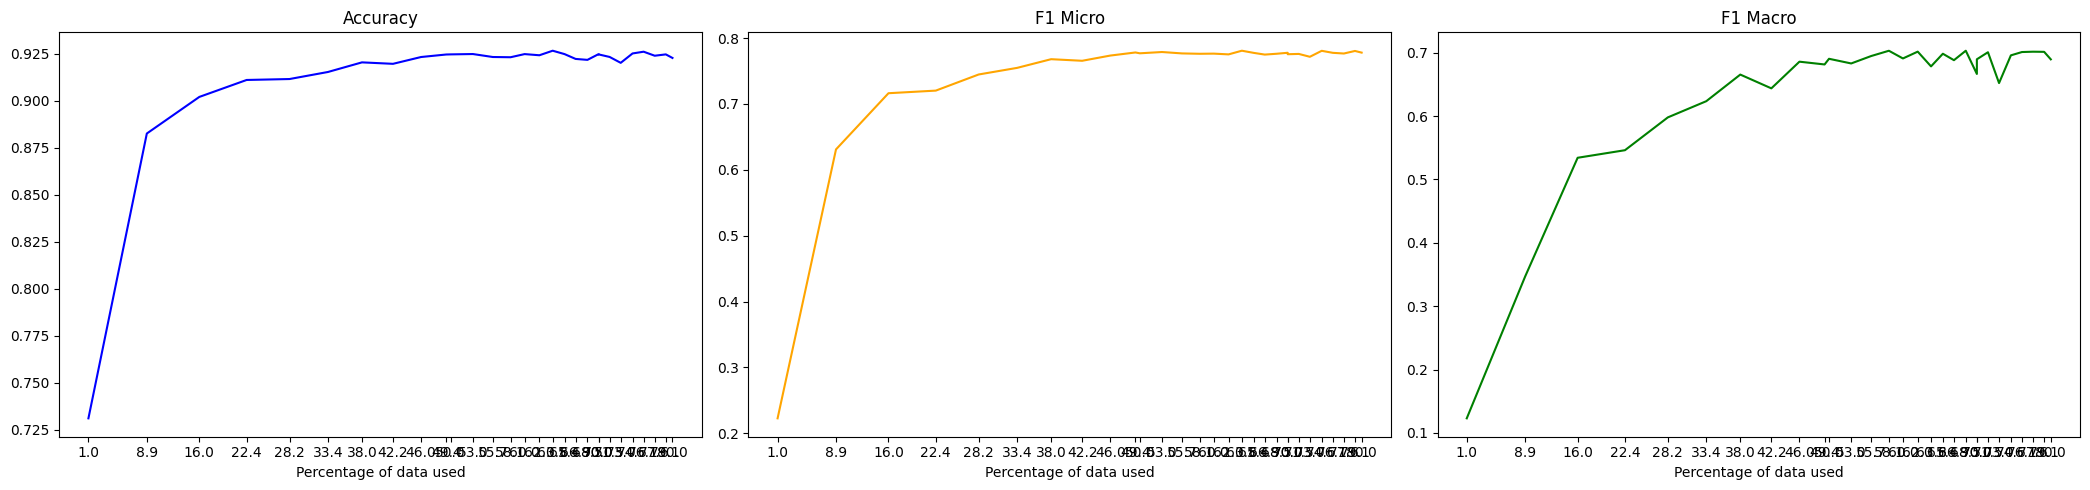

Result saved to results/hsd-mc-init-1-1-results.csv


In [ ]:
initial_train_size = int(0.01 * total_data)
active_learning(50, 0, 'mc', 1)

Init Size: 10
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5474, Accuracy: 0.8279, F1 Micro: 0.0032, F1 Macro: 0.0013
Epoch 2/10, Train Loss: 0.4068, Accuracy: 0.8279, F1 Micro: 0.0018, F1 Macro: 0.0008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3684, Accuracy: 0.8403, F1 Micro: 0.161, F1 Macro: 0.0593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3529, Accuracy: 0.859, F1 Micro: 0.3835, F1 Macro: 0.1446
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3238, Accuracy: 0.8755, F1 Micro: 0.5261, F1 Macro: 0.2466
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2939, Accuracy: 0.8816, F1 Micro: 0.612, F1 Macro: 0.3107
Epoch 7/10, Train Loss: 0.2625, Accuracy: 0.8851, F1 Micro: 0.6102, F1 Macro: 0.3322
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.227, Accuracy: 0.887, F1 Micro: 0.6172, F1 Macro: 0.3778
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2146, Accuracy: 0.8885, F1 Micro: 0.6626, F1 Macro: 0.4638
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.508, Accuracy: 0.8373, F1 Micro: 0.1461, F1 Macro: 0.0536
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.411, Accuracy: 0.854, F1 Micro: 0.3723, F1 Macro: 0.1139
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3785, Accuracy: 0.8656, F1 Micro: 0.448, F1 Macro: 0.176
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3467, Accuracy: 0.8814, F1 Micro: 0.5583, F1 Macro: 0.2817
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3006, Accuracy: 0.8952, F1 Micro: 0.6729, F1 Macro: 0.4422
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2635, Accuracy: 0.8987, F1 Micro: 0.6796, F1 Macro: 0.4514
Epoch 7/10, Train Loss: 0.2232, Accuracy: 0.9002, F1 Micro: 0.6749, F1 Macro: 0.4672
Epoch 8/10, Train Loss: 0.1959, Accuracy: 0.9006, F1 Micro: 0.6777, F1 Macro: 0.5026
Epoch 9/10, Train Loss: 0.1806, Accuracy: 0.9007, F1 Micro: 0.6784, F1 Macro: 0.5142
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4917, Accuracy: 0.8369, F1 Micro: 0.3653, F1 Macro: 0.1002
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4036, Accuracy: 0.8481, F1 Micro: 0.4206, F1 Macro: 0.1255
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3677, Accuracy: 0.8837, F1 Micro: 0.5967, F1 Macro: 0.2912
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3248, Accuracy: 0.8957, F1 Micro: 0.6735, F1 Macro: 0.4255
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2799, Accuracy: 0.9007, F1 Micro: 0.6993, F1 Macro: 0.4884
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2523, Accuracy: 0.9023, F1 Micro: 0.7158, F1 Macro: 0.5471
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2079, Accuracy: 0.9051, F1 Micro: 0.7185, F1 Macro: 0.5417
Epoch 8/10, Train Loss: 0.1871, Accuracy: 0.9079, F1 Micro: 0.7129, F1 Macro: 0.5344
Epoch 9/10, Train Loss: 0.1593, Accuracy: 0.9081, F1 Micro: 0.715, F1 Macro: 0.5371
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4855, Accuracy: 0.8326, F1 Micro: 0.386, F1 Macro: 0.1058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4025, Accuracy: 0.8626, F1 Micro: 0.4822, F1 Macro: 0.1815
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3566, Accuracy: 0.8921, F1 Micro: 0.6448, F1 Macro: 0.3551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3078, Accuracy: 0.9047, F1 Micro: 0.7008, F1 Macro: 0.5133
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2651, Accuracy: 0.9069, F1 Micro: 0.724, F1 Macro: 0.5348
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2252, Accuracy: 0.9105, F1 Micro: 0.7284, F1 Macro: 0.5443
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1868, Accuracy: 0.9118, F1 Micro: 0.7286, F1 Macro: 0.5515
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1623, Accuracy: 0.9128, F1 Micro: 0.7367, F1 Macro: 0.5638
Epoch 9/10, Train Loss: 0.1447, Accuracy: 0.9136, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.476, Accuracy: 0.8297, F1 Micro: 0.398, F1 Macro: 0.1105
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3946, Accuracy: 0.8835, F1 Micro: 0.5974, F1 Macro: 0.2759
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.34, Accuracy: 0.9, F1 Micro: 0.6594, F1 Macro: 0.4491
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2969, Accuracy: 0.9083, F1 Micro: 0.7196, F1 Macro: 0.5339
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2557, Accuracy: 0.9124, F1 Micro: 0.7221, F1 Macro: 0.5478
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2099, Accuracy: 0.9121, F1 Micro: 0.7362, F1 Macro: 0.5538
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1826, Accuracy: 0.9156, F1 Micro: 0.7457, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1464, Accuracy: 0.9173, F1 Micro: 0.7491, F1 Macro: 0.5898
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1289

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4708, Accuracy: 0.8386, F1 Micro: 0.4174, F1 Macro: 0.1179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.386, Accuracy: 0.8876, F1 Micro: 0.6057, F1 Macro: 0.3262
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3328, Accuracy: 0.9007, F1 Micro: 0.7115, F1 Macro: 0.5156
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2809, Accuracy: 0.9114, F1 Micro: 0.72, F1 Macro: 0.5408
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2432, Accuracy: 0.9145, F1 Micro: 0.745, F1 Macro: 0.5805
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2082, Accuracy: 0.9136, F1 Micro: 0.7492, F1 Macro: 0.6116
Epoch 7/10, Train Loss: 0.1715, Accuracy: 0.9163, F1 Micro: 0.7488, F1 Macro: 0.6084
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1441, Accuracy: 0.9177, F1 Micro: 0.7554, F1 Macro: 0.6216
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1247, Accuracy: 0.9169, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4668, Accuracy: 0.8451, F1 Micro: 0.4154, F1 Macro: 0.1262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3745, Accuracy: 0.8953, F1 Micro: 0.6721, F1 Macro: 0.4542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3161, Accuracy: 0.9081, F1 Micro: 0.715, F1 Macro: 0.5212
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2746, Accuracy: 0.9136, F1 Micro: 0.7369, F1 Macro: 0.5694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2245, Accuracy: 0.9182, F1 Micro: 0.755, F1 Macro: 0.61
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.188, Accuracy: 0.9182, F1 Micro: 0.7615, F1 Macro: 0.6213
Epoch 7/10, Train Loss: 0.164, Accuracy: 0.9211, F1 Micro: 0.7587, F1 Macro: 0.6352
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1311, Accuracy: 0.9214, F1 Micro: 0.7693, F1 Macro: 0.6519
Epoch 9/10, Train Loss: 0.1141, Accuracy: 0.9222, F1 Micro: 0.7657, F1 Macro: 0.663
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4626, Accuracy: 0.8498, F1 Micro: 0.492, F1 Macro: 0.2032
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3684, Accuracy: 0.8982, F1 Micro: 0.6705, F1 Macro: 0.4646
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3079, Accuracy: 0.9079, F1 Micro: 0.7206, F1 Macro: 0.5118
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2618, Accuracy: 0.9151, F1 Micro: 0.7398, F1 Macro: 0.5893
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2238, Accuracy: 0.9195, F1 Micro: 0.749, F1 Macro: 0.6012
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.182, Accuracy: 0.9195, F1 Micro: 0.7663, F1 Macro: 0.6503
Epoch 7/10, Train Loss: 0.156, Accuracy: 0.9179, F1 Micro: 0.7645, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1385, Accuracy: 0.9223, F1 Micro: 0.7724, F1 Macro: 0.6754
Epoch 9/10, Train Loss: 0.1135, Accuracy: 0.9216, F1 Micro: 0.7698, F1 Macro: 0.6835
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4578, Accuracy: 0.8565, F1 Micro: 0.478, F1 Macro: 0.1991
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3518, Accuracy: 0.9003, F1 Micro: 0.7024, F1 Macro: 0.4882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2877, Accuracy: 0.909, F1 Micro: 0.7387, F1 Macro: 0.5851
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2483, Accuracy: 0.917, F1 Micro: 0.7451, F1 Macro: 0.5848
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2072, Accuracy: 0.921, F1 Micro: 0.7676, F1 Macro: 0.6481
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1718, Accuracy: 0.9191, F1 Micro: 0.7678, F1 Macro: 0.6596
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1429, Accuracy: 0.9234, F1 Micro: 0.7713, F1 Macro: 0.6722
Epoch 8/10, Train Loss: 0.1216, Accuracy: 0.9209, F1 Micro: 0.7711, F1 Macro: 0.6738
Epoch 9/10, Train Loss: 0.1079, Accuracy: 0.9196, F1 Micro: 0.7679, F1 Macro: 0.666
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4581, Accuracy: 0.8544, F1 Micro: 0.4673, F1 Macro: 0.1818
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3555, Accuracy: 0.8995, F1 Micro: 0.7001, F1 Macro: 0.5073
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2919, Accuracy: 0.9113, F1 Micro: 0.7131, F1 Macro: 0.5486
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2469, Accuracy: 0.9161, F1 Micro: 0.7244, F1 Macro: 0.574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2082, Accuracy: 0.9216, F1 Micro: 0.7591, F1 Macro: 0.6334
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1732, Accuracy: 0.9216, F1 Micro: 0.769, F1 Macro: 0.6643
Epoch 7/10, Train Loss: 0.1484, Accuracy: 0.9171, F1 Micro: 0.7684, F1 Macro: 0.6816
Epoch 8/10, Train Loss: 0.1299, Accuracy: 0.9179, F1 Micro: 0.7688, F1 Macro: 0.6847
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1078, Accuracy: 0.9191, F1 Micro: 0.7714, F1 Macro: 0.6887
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4507, Accuracy: 0.8651, F1 Micro: 0.5751, F1 Macro: 0.2863
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3436, Accuracy: 0.9027, F1 Micro: 0.6972, F1 Macro: 0.509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2841, Accuracy: 0.9123, F1 Micro: 0.734, F1 Macro: 0.5843
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2407, Accuracy: 0.9192, F1 Micro: 0.7542, F1 Macro: 0.6136
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2, Accuracy: 0.9213, F1 Micro: 0.757, F1 Macro: 0.6223
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1695, Accuracy: 0.9224, F1 Micro: 0.7726, F1 Macro: 0.6525
Epoch 7/10, Train Loss: 0.1444, Accuracy: 0.9249, F1 Micro: 0.7703, F1 Macro: 0.6603
Epoch 8/10, Train Loss: 0.1225, Accuracy: 0.9237, F1 Micro: 0.7682, F1 Macro: 0.6774
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1017, Accuracy: 0.9235, F1 Micro: 0.7728, F1 Macro: 0.6709
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4437, Accuracy: 0.8757, F1 Micro: 0.5609, F1 Macro: 0.2789
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.329, Accuracy: 0.9051, F1 Micro: 0.6945, F1 Macro: 0.4961
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2712, Accuracy: 0.9149, F1 Micro: 0.7447, F1 Macro: 0.5808
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2285, Accuracy: 0.9189, F1 Micro: 0.7568, F1 Macro: 0.6072
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1924, Accuracy: 0.9212, F1 Micro: 0.767, F1 Macro: 0.6644
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1604, Accuracy: 0.9219, F1 Micro: 0.7721, F1 Macro: 0.6584
Epoch 7/10, Train Loss: 0.1404, Accuracy: 0.9222, F1 Micro: 0.7613, F1 Macro: 0.6555
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1161, Accuracy: 0.9247, F1 Micro: 0.7746, F1 Macro: 0.6836
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0997, Accuracy: 0.9251, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4412, Accuracy: 0.8787, F1 Micro: 0.5968, F1 Macro: 0.2886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3264, Accuracy: 0.9065, F1 Micro: 0.7021, F1 Macro: 0.503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2639, Accuracy: 0.9144, F1 Micro: 0.7489, F1 Macro: 0.5973
Epoch 4/10, Train Loss: 0.2205, Accuracy: 0.9186, F1 Micro: 0.7322, F1 Macro: 0.5939
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1914, Accuracy: 0.9182, F1 Micro: 0.7686, F1 Macro: 0.6514
Epoch 6/10, Train Loss: 0.1626, Accuracy: 0.9238, F1 Micro: 0.7658, F1 Macro: 0.6746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1318, Accuracy: 0.9226, F1 Micro: 0.7738, F1 Macro: 0.6845
Epoch 8/10, Train Loss: 0.1124, Accuracy: 0.9243, F1 Micro: 0.7734, F1 Macro: 0.6854
Epoch 9/10, Train Loss: 0.1002, Accuracy: 0.9244, F1 Micro: 0.7721, F1 Macro: 0.6813
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0871, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4355, Accuracy: 0.8828, F1 Micro: 0.6296, F1 Macro: 0.3316
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3168, Accuracy: 0.903, F1 Micro: 0.7149, F1 Macro: 0.5147
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2622, Accuracy: 0.9153, F1 Micro: 0.7437, F1 Macro: 0.5859
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2174, Accuracy: 0.9171, F1 Micro: 0.7605, F1 Macro: 0.6129
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1878, Accuracy: 0.9195, F1 Micro: 0.7666, F1 Macro: 0.6285
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1536, Accuracy: 0.9242, F1 Micro: 0.772, F1 Macro: 0.659
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1333, Accuracy: 0.9235, F1 Micro: 0.7737, F1 Macro: 0.6572
Epoch 8/10, Train Loss: 0.1117, Accuracy: 0.9194, F1 Micro: 0.7731, F1 Macro: 0.6709
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0933, Accuracy: 0.9244, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4325, Accuracy: 0.8832, F1 Micro: 0.5665, F1 Macro: 0.2729
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3082, Accuracy: 0.9066, F1 Micro: 0.7016, F1 Macro: 0.4939
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2491, Accuracy: 0.9141, F1 Micro: 0.745, F1 Macro: 0.5814
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2127, Accuracy: 0.9199, F1 Micro: 0.7564, F1 Macro: 0.5944
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1788, Accuracy: 0.9217, F1 Micro: 0.7669, F1 Macro: 0.6329
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.151, Accuracy: 0.9243, F1 Micro: 0.7774, F1 Macro: 0.6686
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1255, Accuracy: 0.9222, F1 Micro: 0.778, F1 Macro: 0.6833
Epoch 8/10, Train Loss: 0.1079, Accuracy: 0.9231, F1 Micro: 0.7681, F1 Macro: 0.6858
Epoch 9/10, Train Loss: 0.0974, Accuracy: 0.9232, F1 Micro: 0.7751, F1 Macro: 0.6864
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4233, Accuracy: 0.8849, F1 Micro: 0.6285, F1 Macro: 0.3151
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3052, Accuracy: 0.906, F1 Micro: 0.7222, F1 Macro: 0.545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2458, Accuracy: 0.9137, F1 Micro: 0.743, F1 Macro: 0.5782
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2072, Accuracy: 0.9154, F1 Micro: 0.7571, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1728, Accuracy: 0.9234, F1 Micro: 0.7639, F1 Macro: 0.6307
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1467, Accuracy: 0.9246, F1 Micro: 0.7737, F1 Macro: 0.68
Epoch 7/10, Train Loss: 0.1223, Accuracy: 0.9238, F1 Micro: 0.7716, F1 Macro: 0.6691
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1016, Accuracy: 0.9221, F1 Micro: 0.7768, F1 Macro: 0.6909
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0895, Accuracy: 0.9248, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4205, Accuracy: 0.8857, F1 Micro: 0.6322, F1 Macro: 0.3173
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2965, Accuracy: 0.9074, F1 Micro: 0.7112, F1 Macro: 0.5151
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2418, Accuracy: 0.9174, F1 Micro: 0.7431, F1 Macro: 0.5683
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2058, Accuracy: 0.9203, F1 Micro: 0.7564, F1 Macro: 0.6143
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1702, Accuracy: 0.9238, F1 Micro: 0.763, F1 Macro: 0.6264
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.145, Accuracy: 0.9235, F1 Micro: 0.7776, F1 Macro: 0.6647
Epoch 7/10, Train Loss: 0.1203, Accuracy: 0.9241, F1 Micro: 0.7722, F1 Macro: 0.6589
Epoch 8/10, Train Loss: 0.1048, Accuracy: 0.9216, F1 Micro: 0.771, F1 Macro: 0.6794
Epoch 9/10, Train Loss: 0.0912, Accuracy: 0.924, F1 Micro: 0.7732, F1 Macro: 0.6974
Epoch 10/10, Train Loss: 0.0745, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4139, Accuracy: 0.8848, F1 Micro: 0.6417, F1 Macro: 0.3309
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2931, Accuracy: 0.9069, F1 Micro: 0.7035, F1 Macro: 0.5091
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2404, Accuracy: 0.9143, F1 Micro: 0.7501, F1 Macro: 0.5998
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1992, Accuracy: 0.9201, F1 Micro: 0.7594, F1 Macro: 0.6233
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.169, Accuracy: 0.9217, F1 Micro: 0.7697, F1 Macro: 0.6637
Epoch 6/10, Train Loss: 0.1418, Accuracy: 0.9168, F1 Micro: 0.7681, F1 Macro: 0.637
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1225, Accuracy: 0.9209, F1 Micro: 0.7736, F1 Macro: 0.6665
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1025, Accuracy: 0.9242, F1 Micro: 0.7743, F1 Macro: 0.6693
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0882, Accuracy: 0.9215, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4105, Accuracy: 0.8841, F1 Micro: 0.651, F1 Macro: 0.3409
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2886, Accuracy: 0.9064, F1 Micro: 0.7053, F1 Macro: 0.5021
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2341, Accuracy: 0.9164, F1 Micro: 0.743, F1 Macro: 0.5744
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1949, Accuracy: 0.9209, F1 Micro: 0.7624, F1 Macro: 0.5976
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1676, Accuracy: 0.9221, F1 Micro: 0.7647, F1 Macro: 0.6366
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1331, Accuracy: 0.9231, F1 Micro: 0.7694, F1 Macro: 0.6579
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1171, Accuracy: 0.9242, F1 Micro: 0.7752, F1 Macro: 0.6799
Epoch 8/10, Train Loss: 0.0982, Accuracy: 0.9224, F1 Micro: 0.7735, F1 Macro: 0.6993
Epoch 9/10, Train Loss: 0.0848, Accuracy: 0.9247, F1 Micro: 0.7732, F1 Macro: 0.6954
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4073, Accuracy: 0.8843, F1 Micro: 0.5803, F1 Macro: 0.2843
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2839, Accuracy: 0.9067, F1 Micro: 0.7169, F1 Macro: 0.5261
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2265, Accuracy: 0.9147, F1 Micro: 0.7503, F1 Macro: 0.583
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1955, Accuracy: 0.9204, F1 Micro: 0.7543, F1 Macro: 0.5987
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1619, Accuracy: 0.9216, F1 Micro: 0.775, F1 Macro: 0.6556
Epoch 6/10, Train Loss: 0.1377, Accuracy: 0.9238, F1 Micro: 0.7724, F1 Macro: 0.6726
Epoch 7/10, Train Loss: 0.1148, Accuracy: 0.9229, F1 Micro: 0.7696, F1 Macro: 0.6739
Epoch 8/10, Train Loss: 0.0957, Accuracy: 0.9203, F1 Micro: 0.7713, F1 Macro: 0.6778
Epoch 9/10, Train Loss: 0.0839, Accuracy: 0.9219, F1 Micro: 0.7722, F1 Macro: 0.6866
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0731, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4042, Accuracy: 0.8876, F1 Micro: 0.6172, F1 Macro: 0.3178
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2805, Accuracy: 0.9067, F1 Micro: 0.716, F1 Macro: 0.5357
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2308, Accuracy: 0.9146, F1 Micro: 0.7305, F1 Macro: 0.5492
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1911, Accuracy: 0.9212, F1 Micro: 0.7653, F1 Macro: 0.6221
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1612, Accuracy: 0.9204, F1 Micro: 0.7704, F1 Macro: 0.6787
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1381, Accuracy: 0.9246, F1 Micro: 0.7727, F1 Macro: 0.6694
Epoch 7/10, Train Loss: 0.1118, Accuracy: 0.923, F1 Micro: 0.7726, F1 Macro: 0.6716
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0977, Accuracy: 0.9244, F1 Micro: 0.7775, F1 Macro: 0.6816
Epoch 9/10, Train Loss: 0.0845, Accuracy: 0.9254, F1 Micro: 0.7742, F1 Macro: 0.6799
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3996, Accuracy: 0.8867, F1 Micro: 0.6065, F1 Macro: 0.3075
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2776, Accuracy: 0.9053, F1 Micro: 0.725, F1 Macro: 0.5478
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2276, Accuracy: 0.9146, F1 Micro: 0.7366, F1 Macro: 0.521
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1945, Accuracy: 0.9205, F1 Micro: 0.7618, F1 Macro: 0.6206
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.16, Accuracy: 0.9223, F1 Micro: 0.764, F1 Macro: 0.6279
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1323, Accuracy: 0.9239, F1 Micro: 0.7716, F1 Macro: 0.6697
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1129, Accuracy: 0.9242, F1 Micro: 0.7767, F1 Macro: 0.6855
Epoch 8/10, Train Loss: 0.0955, Accuracy: 0.9215, F1 Micro: 0.7748, F1 Macro: 0.6815
Epoch 9/10, Train Loss: 0.0811, Accuracy: 0.9241, F1 Micro: 0.7725, F1 Macro: 0.699
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.398, Accuracy: 0.8876, F1 Micro: 0.6419, F1 Macro: 0.3247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2691, Accuracy: 0.9081, F1 Micro: 0.7185, F1 Macro: 0.5142
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2185, Accuracy: 0.9153, F1 Micro: 0.7509, F1 Macro: 0.5939
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1839, Accuracy: 0.9192, F1 Micro: 0.7693, F1 Macro: 0.6353
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9202, F1 Micro: 0.7653, F1 Macro: 0.64
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9197, F1 Micro: 0.7725, F1 Macro: 0.6767
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.9249, F1 Micro: 0.7779, F1 Macro: 0.6929
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9236, F1 Micro: 0.7735, F1 Macro: 0.6833
Epoch 9/10, Train Loss: 0.0801, Accuracy: 0.9213, F1 Micro: 0.7769, F1 Macro: 0.7028
Epoch 10/10, Train Loss: 0.0667, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.8859, F1 Micro: 0.5925, F1 Macro: 0.2972
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2698, Accuracy: 0.9087, F1 Micro: 0.71, F1 Macro: 0.4861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2165, Accuracy: 0.9161, F1 Micro: 0.7292, F1 Macro: 0.5614
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1857, Accuracy: 0.9208, F1 Micro: 0.7632, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.92, F1 Micro: 0.7658, F1 Macro: 0.6674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1284, Accuracy: 0.9212, F1 Micro: 0.7737, F1 Macro: 0.6606
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9189, F1 Micro: 0.7702, F1 Macro: 0.6888
Epoch 8/10, Train Loss: 0.0932, Accuracy: 0.9201, F1 Micro: 0.77, F1 Macro: 0.69
Epoch 9/10, Train Loss: 0.0795, Accuracy: 0.9201, F1 Micro: 0.7697, F1 Macro: 0.6839
Epoch 10/10, Train Loss: 0.0668, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3862, Accuracy: 0.8872, F1 Micro: 0.651, F1 Macro: 0.3318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2642, Accuracy: 0.9071, F1 Micro: 0.7083, F1 Macro: 0.5247
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2101, Accuracy: 0.9149, F1 Micro: 0.7504, F1 Macro: 0.5713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1776, Accuracy: 0.9168, F1 Micro: 0.7534, F1 Macro: 0.6128
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.9211, F1 Micro: 0.771, F1 Macro: 0.6522
Epoch 6/10, Train Loss: 0.1214, Accuracy: 0.9242, F1 Micro: 0.7704, F1 Macro: 0.6694
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9233, F1 Micro: 0.7791, F1 Macro: 0.6806
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9211, F1 Micro: 0.7741, F1 Macro: 0.6878
Epoch 9/10, Train Loss: 0.0774, Accuracy: 0.9222, F1 Micro: 0.7786, F1 Macro: 0.693
Epoch 10/10, Train Loss: 0.0638, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3867, Accuracy: 0.8866, F1 Micro: 0.5995, F1 Macro: 0.2967
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2581, Accuracy: 0.9058, F1 Micro: 0.6876, F1 Macro: 0.5075
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2112, Accuracy: 0.9161, F1 Micro: 0.7365, F1 Macro: 0.5737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1755, Accuracy: 0.9193, F1 Micro: 0.7657, F1 Macro: 0.6167
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1514, Accuracy: 0.925, F1 Micro: 0.7708, F1 Macro: 0.6511
Epoch 6/10, Train Loss: 0.1268, Accuracy: 0.9178, F1 Micro: 0.7638, F1 Macro: 0.6665
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1041, Accuracy: 0.9259, F1 Micro: 0.7791, F1 Macro: 0.6965
Epoch 8/10, Train Loss: 0.0903, Accuracy: 0.9181, F1 Micro: 0.7666, F1 Macro: 0.6941
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9251, F1 Micro: 0.7805, F1 Macro: 0.7049
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3779, Accuracy: 0.8882, F1 Micro: 0.6215, F1 Macro: 0.3159
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2528, Accuracy: 0.9082, F1 Micro: 0.6986, F1 Macro: 0.5256
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2043, Accuracy: 0.9139, F1 Micro: 0.7217, F1 Macro: 0.5583
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.9201, F1 Micro: 0.7584, F1 Macro: 0.6072
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1437, Accuracy: 0.9163, F1 Micro: 0.7663, F1 Macro: 0.6433
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.9232, F1 Micro: 0.7761, F1 Macro: 0.6792
Epoch 7/10, Train Loss: 0.1003, Accuracy: 0.9227, F1 Micro: 0.7759, F1 Macro: 0.684
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9225, F1 Micro: 0.7666, F1 Macro: 0.6821
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.9222, F1 Micro: 0.7745, F1 Macro: 0.6935
Epoch 10/10, Train Loss: 0.0644, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3749, Accuracy: 0.8882, F1 Micro: 0.6425, F1 Macro: 0.331
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2487, Accuracy: 0.9085, F1 Micro: 0.7237, F1 Macro: 0.5465
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.9162, F1 Micro: 0.7448, F1 Macro: 0.5934
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.9161, F1 Micro: 0.7625, F1 Macro: 0.6197
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9246, F1 Micro: 0.773, F1 Macro: 0.6484
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1149, Accuracy: 0.9232, F1 Micro: 0.7737, F1 Macro: 0.6678
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.9234, F1 Micro: 0.7711, F1 Macro: 0.6811
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.9248, F1 Micro: 0.7703, F1 Macro: 0.6814
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.9243, F1 Micro: 0.7738, F1 Macro: 0.6801
Higher

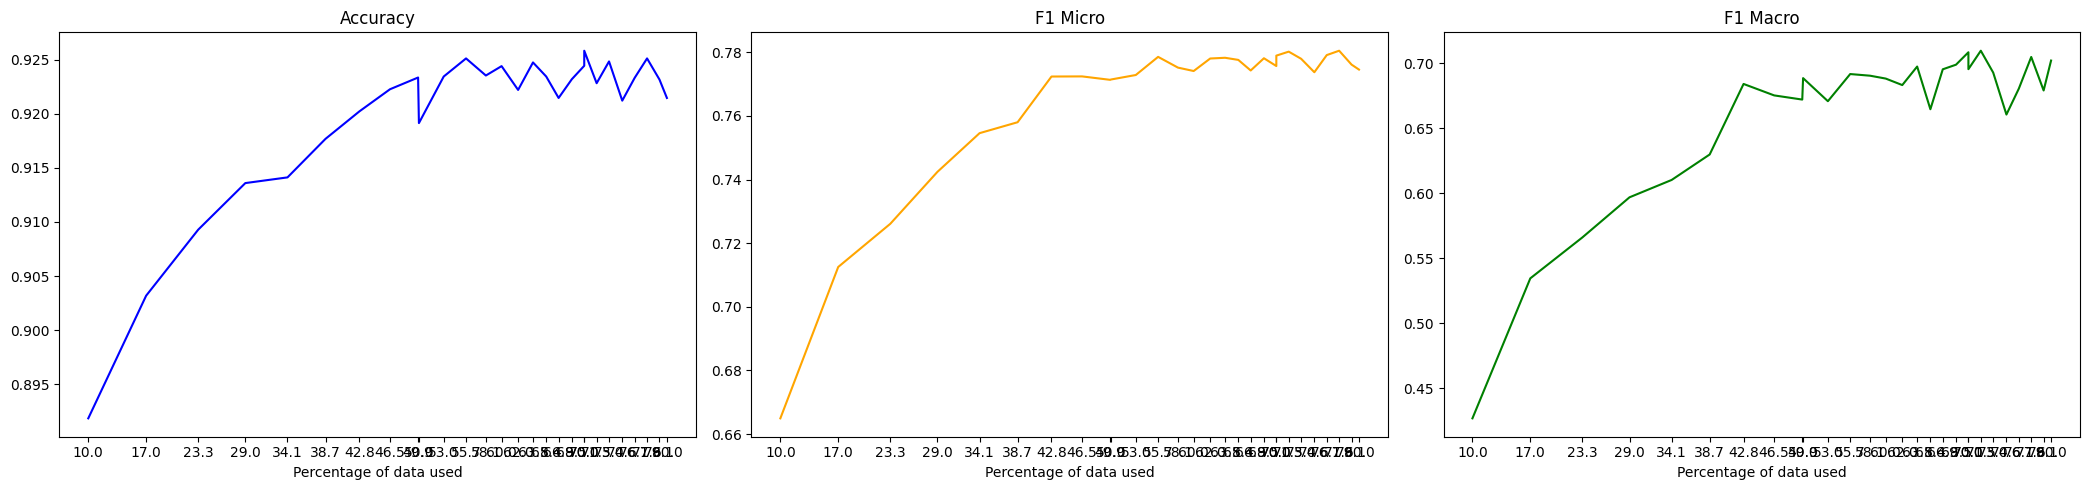

Result saved to results/hsd-mc-init-10-1-results.csv


In [ ]:
initial_train_size = int(0.1 * total_data)
active_learning(50, 0, 'mc', 10)

# KMEANS

Init Size: 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6814, Accuracy: 0.7312, F1 Micro: 0.2228, F1 Macro: 0.123
Epoch 2/10, Train Loss: 0.5938, Accuracy: 0.8056, F1 Micro: 0.1568, F1 Macro: 0.0557
Epoch 3/10, Train Loss: 0.5257, Accuracy: 0.8219, F1 Micro: 0.0493, F1 Macro: 0.0222
Epoch 4/10, Train Loss: 0.4783, Accuracy: 0.8273, F1 Micro: 0.0025, F1 Macro: 0.0014
Epoch 5/10, Train Loss: 0.4275, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 6/10, Train Loss: 0.3998, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 7/10, Train Loss: 0.3716, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 8/10, Train Loss: 0.3814, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 9/10, Train Loss: 0.4033, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 10/10, Train Loss: 0.3566, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Iteration 131: Accuracy: 0.7312, F1 Micro: 0.2228, F1 Macro: 0.123
               precision    recall  f1-score   support

           HS       0.38      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5496, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3832, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3439, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3203, Accuracy: 0.828, F1 Micro: 0.0032, F1 Macro: 0.0014
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3147, Accuracy: 0.8471, F1 Micro: 0.2325, F1 Macro: 0.0871
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2814, Accuracy: 0.8726, F1 Micro: 0.5107, F1 Macro: 0.2427
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2649, Accuracy: 0.8776, F1 Micro: 0.5425, F1 Macro: 0.2559
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2167, Accuracy: 0.8799, F1 Micro: 0.6075, F1 Macro: 0.294
Epoch 9/10, Train Loss: 0.2021, Accuracy: 0.8827, F1 Micro: 0.5775, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4903, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3548, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3361, Accuracy: 0.842, F1 Micro: 0.1735, F1 Macro: 0.065
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2904, Accuracy: 0.868, F1 Micro: 0.4313, F1 Macro: 0.2014
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.258, Accuracy: 0.8834, F1 Micro: 0.6155, F1 Macro: 0.3098
Epoch 6/10, Train Loss: 0.236, Accuracy: 0.8873, F1 Micro: 0.6126, F1 Macro: 0.3261
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2028, Accuracy: 0.889, F1 Micro: 0.6562, F1 Macro: 0.3685
Epoch 8/10, Train Loss: 0.1825, Accuracy: 0.892, F1 Micro: 0.6411, F1 Macro: 0.3979
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1587, Accuracy: 0.8931, F1 Micro: 0.6592, F1 Macro: 0.4592
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.461, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3567, Accuracy: 0.8465, F1 Micro: 0.2391, F1 Macro: 0.0837
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3196, Accuracy: 0.8809, F1 Micro: 0.5672, F1 Macro: 0.2636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2706, Accuracy: 0.8883, F1 Micro: 0.636, F1 Macro: 0.3373
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2241, Accuracy: 0.8951, F1 Micro: 0.6707, F1 Macro: 0.4205
Epoch 6/10, Train Loss: 0.1937, Accuracy: 0.8971, F1 Micro: 0.6549, F1 Macro: 0.4488
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1699, Accuracy: 0.8993, F1 Micro: 0.6747, F1 Macro: 0.4806
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1432, Accuracy: 0.9028, F1 Micro: 0.6912, F1 Macro: 0.4872
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1256, Accuracy: 0.9016, F1 Micro: 0.71

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.449, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3444, Accuracy: 0.8675, F1 Micro: 0.4456, F1 Macro: 0.1828
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2966, Accuracy: 0.8869, F1 Micro: 0.6032, F1 Macro: 0.2948
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2586, Accuracy: 0.8906, F1 Micro: 0.6804, F1 Macro: 0.448
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2087, Accuracy: 0.8969, F1 Micro: 0.6927, F1 Macro: 0.4616
Epoch 6/10, Train Loss: 0.1839, Accuracy: 0.9009, F1 Micro: 0.6923, F1 Macro: 0.4905
Epoch 7/10, Train Loss: 0.1617, Accuracy: 0.9039, F1 Micro: 0.6925, F1 Macro: 0.4954
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1339, Accuracy: 0.9067, F1 Micro: 0.7188, F1 Macro: 0.5448
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1136, Accuracy: 0.9078, F1 Micro: 0.7226, F1 Macro: 0.5437
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4379, Accuracy: 0.8294, F1 Micro: 0.0213, F1 Macro: 0.0095
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3355, Accuracy: 0.8799, F1 Micro: 0.5681, F1 Macro: 0.2684
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2752, Accuracy: 0.891, F1 Micro: 0.6232, F1 Macro: 0.3301
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2425, Accuracy: 0.8976, F1 Micro: 0.7017, F1 Macro: 0.5222
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2038, Accuracy: 0.9036, F1 Micro: 0.7081, F1 Macro: 0.4929
Epoch 6/10, Train Loss: 0.1684, Accuracy: 0.9075, F1 Micro: 0.7004, F1 Macro: 0.5277
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1415, Accuracy: 0.9084, F1 Micro: 0.7261, F1 Macro: 0.5478
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1194, Accuracy: 0.9093, F1 Micro: 0.7266, F1 Macro: 0.5403
Epoch 9/10, Train Loss: 0.1072, Accuracy: 0.9106, F1 Micro: 0.7265, F1 Macro: 0.5513
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4304, Accuracy: 0.8378, F1 Micro: 0.1361, F1 Macro: 0.0502
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3211, Accuracy: 0.8809, F1 Micro: 0.5567, F1 Macro: 0.2734
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2611, Accuracy: 0.8965, F1 Micro: 0.6795, F1 Macro: 0.4501
Epoch 4/10, Train Loss: 0.2249, Accuracy: 0.9012, F1 Micro: 0.6751, F1 Macro: 0.4689
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1936, Accuracy: 0.9053, F1 Micro: 0.7013, F1 Macro: 0.4788
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1628, Accuracy: 0.91, F1 Micro: 0.7333, F1 Macro: 0.5553
Epoch 7/10, Train Loss: 0.1394, Accuracy: 0.9116, F1 Micro: 0.7224, F1 Macro: 0.5563
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1119, Accuracy: 0.9105, F1 Micro: 0.7377, F1 Macro: 0.5561
Epoch 9/10, Train Loss: 0.0973, Accuracy: 0.9067, F1 Micro: 0.7332, F1 Macro: 0.5725
Epoch 10/10, Train Loss: 0.0848, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4274, Accuracy: 0.839, F1 Micro: 0.1463, F1 Macro: 0.0544
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3252, Accuracy: 0.8874, F1 Micro: 0.6045, F1 Macro: 0.296
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.258, Accuracy: 0.9003, F1 Micro: 0.6901, F1 Macro: 0.4617
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2136, Accuracy: 0.9048, F1 Micro: 0.7214, F1 Macro: 0.5401
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1854, Accuracy: 0.9077, F1 Micro: 0.7289, F1 Macro: 0.5555
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1554, Accuracy: 0.9125, F1 Micro: 0.7446, F1 Macro: 0.5762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.128, Accuracy: 0.9143, F1 Micro: 0.7457, F1 Macro: 0.5855
Epoch 8/10, Train Loss: 0.114, Accuracy: 0.9161, F1 Micro: 0.7382, F1 Macro: 0.5812
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0963, Accuracy: 0.9125, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4196, Accuracy: 0.8496, F1 Micro: 0.2695, F1 Macro: 0.0928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3145, Accuracy: 0.8873, F1 Micro: 0.5992, F1 Macro: 0.3024
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.249, Accuracy: 0.9013, F1 Micro: 0.6867, F1 Macro: 0.4691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2166, Accuracy: 0.9066, F1 Micro: 0.7217, F1 Macro: 0.5306
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1797, Accuracy: 0.9138, F1 Micro: 0.7312, F1 Macro: 0.5561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.15, Accuracy: 0.9135, F1 Micro: 0.7386, F1 Macro: 0.5706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.128, Accuracy: 0.9164, F1 Micro: 0.7449, F1 Macro: 0.5842
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1065, Accuracy: 0.915, F1 Micro: 0.752, F1 Macro: 0.6296
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.091

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4202, Accuracy: 0.8583, F1 Micro: 0.3686, F1 Macro: 0.1197
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3058, Accuracy: 0.8928, F1 Micro: 0.6692, F1 Macro: 0.383
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2542, Accuracy: 0.904, F1 Micro: 0.7149, F1 Macro: 0.5346
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2069, Accuracy: 0.9106, F1 Micro: 0.7319, F1 Macro: 0.5558
Epoch 5/10, Train Loss: 0.1739, Accuracy: 0.9141, F1 Micro: 0.7315, F1 Macro: 0.5537
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1486, Accuracy: 0.9146, F1 Micro: 0.7495, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1237, Accuracy: 0.915, F1 Micro: 0.7541, F1 Macro: 0.6263
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1045, Accuracy: 0.9194, F1 Micro: 0.7566, F1 Macro: 0.6442
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.092, Accuracy: 0.9185, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4182, Accuracy: 0.8633, F1 Micro: 0.4221, F1 Macro: 0.1561
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3015, Accuracy: 0.8931, F1 Micro: 0.6374, F1 Macro: 0.4092
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2449, Accuracy: 0.906, F1 Micro: 0.7148, F1 Macro: 0.5233
Epoch 4/10, Train Loss: 0.202, Accuracy: 0.9114, F1 Micro: 0.7109, F1 Macro: 0.5402
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1742, Accuracy: 0.9155, F1 Micro: 0.7261, F1 Macro: 0.5672
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1463, Accuracy: 0.9149, F1 Micro: 0.7477, F1 Macro: 0.5971
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1197, Accuracy: 0.9167, F1 Micro: 0.7488, F1 Macro: 0.5993
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1067, Accuracy: 0.9212, F1 Micro: 0.7651, F1 Macro: 0.6488
Epoch 9/10, Train Loss: 0.0848, Accuracy: 0.9194, F1 Micro: 0.7564, F1 Macro: 0.6348
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4089, Accuracy: 0.8702, F1 Micro: 0.4816, F1 Macro: 0.2014
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2925, Accuracy: 0.8957, F1 Micro: 0.6545, F1 Macro: 0.356
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2382, Accuracy: 0.9058, F1 Micro: 0.6966, F1 Macro: 0.4656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2049, Accuracy: 0.9133, F1 Micro: 0.7337, F1 Macro: 0.5516
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1702, Accuracy: 0.9149, F1 Micro: 0.7509, F1 Macro: 0.5888
Epoch 6/10, Train Loss: 0.1445, Accuracy: 0.9161, F1 Micro: 0.7473, F1 Macro: 0.6094
Epoch 7/10, Train Loss: 0.1203, Accuracy: 0.9169, F1 Micro: 0.738, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1024, Accuracy: 0.9196, F1 Micro: 0.7538, F1 Macro: 0.6347
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0843, Accuracy: 0.9192, F1 Micro: 0.7636, F1 Macro: 0.6496
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4127, Accuracy: 0.875, F1 Micro: 0.5138, F1 Macro: 0.2262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2871, Accuracy: 0.895, F1 Micro: 0.6815, F1 Macro: 0.443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2365, Accuracy: 0.9072, F1 Micro: 0.7108, F1 Macro: 0.5291
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1949, Accuracy: 0.9123, F1 Micro: 0.7133, F1 Macro: 0.5517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.166, Accuracy: 0.916, F1 Micro: 0.742, F1 Macro: 0.5822
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.9169, F1 Micro: 0.759, F1 Macro: 0.6361
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.115, Accuracy: 0.919, F1 Micro: 0.763, F1 Macro: 0.6217
Epoch 8/10, Train Loss: 0.1035, Accuracy: 0.9181, F1 Micro: 0.7591, F1 Macro: 0.6483
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0841, Accuracy: 0.9167, F1 Micro: 0.7639

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.411, Accuracy: 0.8745, F1 Micro: 0.5031, F1 Macro: 0.2256
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2897, Accuracy: 0.8992, F1 Micro: 0.6682, F1 Macro: 0.4518
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2326, Accuracy: 0.9085, F1 Micro: 0.7232, F1 Macro: 0.5324
Epoch 4/10, Train Loss: 0.199, Accuracy: 0.9122, F1 Micro: 0.721, F1 Macro: 0.5668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1679, Accuracy: 0.9161, F1 Micro: 0.7553, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1398, Accuracy: 0.9173, F1 Micro: 0.7589, F1 Macro: 0.6166
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1151, Accuracy: 0.9176, F1 Micro: 0.7655, F1 Macro: 0.6371
Epoch 8/10, Train Loss: 0.0979, Accuracy: 0.9185, F1 Micro: 0.765, F1 Macro: 0.6565
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0824, Accuracy: 0.92, F1 Micro: 0.7663, F1 Macro: 0.6704
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4081, Accuracy: 0.8789, F1 Micro: 0.5854, F1 Macro: 0.271
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2882, Accuracy: 0.899, F1 Micro: 0.6801, F1 Macro: 0.4671
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2337, Accuracy: 0.9076, F1 Micro: 0.7186, F1 Macro: 0.5491
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1949, Accuracy: 0.9138, F1 Micro: 0.7286, F1 Macro: 0.5285
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1646, Accuracy: 0.917, F1 Micro: 0.7432, F1 Macro: 0.5883
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1416, Accuracy: 0.9191, F1 Micro: 0.7628, F1 Macro: 0.6264
Epoch 7/10, Train Loss: 0.1179, Accuracy: 0.9215, F1 Micro: 0.7582, F1 Macro: 0.637
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9203, F1 Micro: 0.7634, F1 Macro: 0.6476
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0816, Accuracy: 0.9203, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4044, Accuracy: 0.875, F1 Micro: 0.5136, F1 Macro: 0.2404
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.282, Accuracy: 0.9003, F1 Micro: 0.6709, F1 Macro: 0.4581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2315, Accuracy: 0.9042, F1 Micro: 0.7291, F1 Macro: 0.5514
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1941, Accuracy: 0.9151, F1 Micro: 0.7498, F1 Macro: 0.5808
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.165, Accuracy: 0.9179, F1 Micro: 0.7578, F1 Macro: 0.6061
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1361, Accuracy: 0.9191, F1 Micro: 0.7586, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1132, Accuracy: 0.9209, F1 Micro: 0.7706, F1 Macro: 0.6654
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9215, F1 Micro: 0.7652, F1 Macro: 0.6525
Epoch 9/10, Train Loss: 0.0819, Accuracy: 0.916, F1 Micro: 0.7643, F1 Macro: 0.6665
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4018, Accuracy: 0.8752, F1 Micro: 0.6158, F1 Macro: 0.3008
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2754, Accuracy: 0.8985, F1 Micro: 0.7045, F1 Macro: 0.4784
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2282, Accuracy: 0.9062, F1 Micro: 0.7308, F1 Macro: 0.5368
Epoch 4/10, Train Loss: 0.1898, Accuracy: 0.9124, F1 Micro: 0.7262, F1 Macro: 0.5744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1622, Accuracy: 0.9199, F1 Micro: 0.7602, F1 Macro: 0.622
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1362, Accuracy: 0.9192, F1 Micro: 0.7685, F1 Macro: 0.6515
Epoch 7/10, Train Loss: 0.1137, Accuracy: 0.922, F1 Micro: 0.766, F1 Macro: 0.6435
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9212, F1 Micro: 0.7708, F1 Macro: 0.6644
Epoch 9/10, Train Loss: 0.0812, Accuracy: 0.9211, F1 Micro: 0.7702, F1 Macro: 0.6683
Epoch 10/10, Train Loss: 0.069, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3974, Accuracy: 0.88, F1 Micro: 0.6131, F1 Macro: 0.2992
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2747, Accuracy: 0.8981, F1 Micro: 0.6984, F1 Macro: 0.4812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2257, Accuracy: 0.9126, F1 Micro: 0.7333, F1 Macro: 0.5487
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1874, Accuracy: 0.9176, F1 Micro: 0.745, F1 Macro: 0.5887
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1575, Accuracy: 0.9184, F1 Micro: 0.7556, F1 Macro: 0.611
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1329, Accuracy: 0.9198, F1 Micro: 0.769, F1 Macro: 0.6569
Epoch 7/10, Train Loss: 0.1107, Accuracy: 0.9224, F1 Micro: 0.7659, F1 Macro: 0.637
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9184, F1 Micro: 0.765, F1 Macro: 0.6638
Epoch 9/10, Train Loss: 0.0812, Accuracy: 0.9191, F1 Micro: 0.7634, F1 Macro: 0.6563
Epoch 10/10, Train Loss: 0.0689, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4011, Accuracy: 0.8789, F1 Micro: 0.5492, F1 Macro: 0.2591
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2744, Accuracy: 0.9027, F1 Micro: 0.6967, F1 Macro: 0.444
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.219, Accuracy: 0.9098, F1 Micro: 0.7312, F1 Macro: 0.5575
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.917, F1 Micro: 0.7423, F1 Macro: 0.5601
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1571, Accuracy: 0.9197, F1 Micro: 0.7602, F1 Macro: 0.6268
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9227, F1 Micro: 0.7641, F1 Macro: 0.6334
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9232, F1 Micro: 0.7748, F1 Macro: 0.6805
Epoch 8/10, Train Loss: 0.0945, Accuracy: 0.9217, F1 Micro: 0.772, F1 Macro: 0.6766
Epoch 9/10, Train Loss: 0.0811, Accuracy: 0.9188, F1 Micro: 0.7707, F1 Macro: 0.6729
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3941, Accuracy: 0.8822, F1 Micro: 0.587, F1 Macro: 0.2935
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2738, Accuracy: 0.9047, F1 Micro: 0.6981, F1 Macro: 0.4992
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2268, Accuracy: 0.912, F1 Micro: 0.745, F1 Macro: 0.5734
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1864, Accuracy: 0.9193, F1 Micro: 0.7495, F1 Macro: 0.5788
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1601, Accuracy: 0.9213, F1 Micro: 0.7672, F1 Macro: 0.6431
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9161, F1 Micro: 0.7639, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9228, F1 Micro: 0.7716, F1 Macro: 0.6765
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9236, F1 Micro: 0.7677, F1 Macro: 0.6802
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.9237, F1 Micro: 0.7705, F1 Macro: 0.6753
Epoch 10/10, Train Loss: 0.0678, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3918, Accuracy: 0.8816, F1 Micro: 0.5702, F1 Macro: 0.2786
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2668, Accuracy: 0.9023, F1 Micro: 0.7144, F1 Macro: 0.5295
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.22, Accuracy: 0.9169, F1 Micro: 0.7403, F1 Macro: 0.5649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.9197, F1 Micro: 0.7543, F1 Macro: 0.5939
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9211, F1 Micro: 0.7665, F1 Macro: 0.6212
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1278, Accuracy: 0.923, F1 Micro: 0.7705, F1 Macro: 0.6699
Epoch 7/10, Train Loss: 0.107, Accuracy: 0.9181, F1 Micro: 0.763, F1 Macro: 0.6577
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9217, F1 Micro: 0.7665, F1 Macro: 0.6615
Epoch 9/10, Train Loss: 0.0776, Accuracy: 0.9214, F1 Micro: 0.77, F1 Macro: 0.6828
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3952, Accuracy: 0.8846, F1 Micro: 0.6133, F1 Macro: 0.3006
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2657, Accuracy: 0.9052, F1 Micro: 0.7022, F1 Macro: 0.4835
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.218, Accuracy: 0.9134, F1 Micro: 0.7387, F1 Macro: 0.5538
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.9185, F1 Micro: 0.7549, F1 Macro: 0.5946
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1555, Accuracy: 0.9214, F1 Micro: 0.7577, F1 Macro: 0.621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1267, Accuracy: 0.9239, F1 Micro: 0.7718, F1 Macro: 0.663
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9206, F1 Micro: 0.7676, F1 Macro: 0.6622
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9205, F1 Micro: 0.7686, F1 Macro: 0.6781
Epoch 9/10, Train Loss: 0.0792, Accuracy: 0.9229, F1 Micro: 0.7682, F1 Macro: 0.681
Epoch 10/10, Train Loss: 0.0657, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3898, Accuracy: 0.8816, F1 Micro: 0.5549, F1 Macro: 0.2661
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2689, Accuracy: 0.9032, F1 Micro: 0.6829, F1 Macro: 0.4584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2152, Accuracy: 0.9145, F1 Micro: 0.7273, F1 Macro: 0.5528
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9181, F1 Micro: 0.7527, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1594, Accuracy: 0.921, F1 Micro: 0.7675, F1 Macro: 0.6411
Epoch 6/10, Train Loss: 0.1283, Accuracy: 0.9173, F1 Micro: 0.7659, F1 Macro: 0.6619
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1074, Accuracy: 0.921, F1 Micro: 0.7679, F1 Macro: 0.6576
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.9231, F1 Micro: 0.7679, F1 Macro: 0.6759
Epoch 9/10, Train Loss: 0.0789, Accuracy: 0.9233, F1 Micro: 0.7669, F1 Macro: 0.6618
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3923, Accuracy: 0.8842, F1 Micro: 0.6147, F1 Macro: 0.3089
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.265, Accuracy: 0.9044, F1 Micro: 0.7025, F1 Macro: 0.4685
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2192, Accuracy: 0.9155, F1 Micro: 0.7421, F1 Macro: 0.5673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1767, Accuracy: 0.9185, F1 Micro: 0.754, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1524, Accuracy: 0.9228, F1 Micro: 0.7614, F1 Macro: 0.6199
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.9158, F1 Micro: 0.7647, F1 Macro: 0.6702
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9221, F1 Micro: 0.7735, F1 Macro: 0.6856
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.9232, F1 Micro: 0.7652, F1 Macro: 0.6674
Epoch 9/10, Train Loss: 0.0801, Accuracy: 0.9215, F1 Micro: 0.7686, F1 Macro: 0.6825
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3875, Accuracy: 0.8826, F1 Micro: 0.5672, F1 Macro: 0.2712
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2619, Accuracy: 0.9051, F1 Micro: 0.7213, F1 Macro: 0.5227
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2142, Accuracy: 0.9168, F1 Micro: 0.7403, F1 Macro: 0.5623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1792, Accuracy: 0.919, F1 Micro: 0.7634, F1 Macro: 0.6166
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.9161, F1 Micro: 0.7667, F1 Macro: 0.6727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1242, Accuracy: 0.9188, F1 Micro: 0.7709, F1 Macro: 0.685
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.108, Accuracy: 0.9199, F1 Micro: 0.7734, F1 Macro: 0.68
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.9226, F1 Micro: 0.7694, F1 Macro: 0.6767
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.9216, F1 Micro: 0.7713, F1 Macro: 0.6702
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3863, Accuracy: 0.8868, F1 Micro: 0.5953, F1 Macro: 0.2959
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2572, Accuracy: 0.9068, F1 Micro: 0.7063, F1 Macro: 0.5016
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2097, Accuracy: 0.916, F1 Micro: 0.7412, F1 Macro: 0.5606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1785, Accuracy: 0.9205, F1 Micro: 0.7625, F1 Macro: 0.6102
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1484, Accuracy: 0.9184, F1 Micro: 0.7638, F1 Macro: 0.6261
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1266, Accuracy: 0.9243, F1 Micro: 0.7749, F1 Macro: 0.6726
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.92, F1 Micro: 0.7726, F1 Macro: 0.6761
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.9216, F1 Micro: 0.77, F1 Macro: 0.6781
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9246, F1 Micro: 0.7699, F1 Macro: 0.6777
Epoch 10/10, Train Loss: 0.066, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3835, Accuracy: 0.8821, F1 Micro: 0.552, F1 Macro: 0.27
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2577, Accuracy: 0.9073, F1 Micro: 0.7114, F1 Macro: 0.5137
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2086, Accuracy: 0.914, F1 Micro: 0.7472, F1 Macro: 0.5592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9151, F1 Micro: 0.7593, F1 Macro: 0.6069
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9144, F1 Micro: 0.7625, F1 Macro: 0.643
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1245, Accuracy: 0.9213, F1 Micro: 0.7684, F1 Macro: 0.6612
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.926, F1 Micro: 0.7724, F1 Macro: 0.6692
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9189, F1 Micro: 0.7704, F1 Macro: 0.6823
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9238, F1 Micro: 0.7724, F1 Macro: 0.686
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3767, Accuracy: 0.8887, F1 Micro: 0.6198, F1 Macro: 0.3124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2519, Accuracy: 0.9077, F1 Micro: 0.7121, F1 Macro: 0.515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.9153, F1 Micro: 0.737, F1 Macro: 0.5421
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9167, F1 Micro: 0.7628, F1 Macro: 0.6143
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1447, Accuracy: 0.9194, F1 Micro: 0.7673, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.9181, F1 Micro: 0.7701, F1 Macro: 0.6618
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.9242, F1 Micro: 0.7664, F1 Macro: 0.6755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.9233, F1 Micro: 0.7794, F1 Macro: 0.6883
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.9242, F1 Micro: 0.7736, F1 Macro: 0.6864
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3742, Accuracy: 0.8827, F1 Micro: 0.653, F1 Macro: 0.3509
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2521, Accuracy: 0.9077, F1 Micro: 0.7181, F1 Macro: 0.5152
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.9158, F1 Micro: 0.7431, F1 Macro: 0.5564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.9214, F1 Micro: 0.7478, F1 Macro: 0.5967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1471, Accuracy: 0.9235, F1 Micro: 0.7693, F1 Macro: 0.6277
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.119, Accuracy: 0.9245, F1 Micro: 0.7763, F1 Macro: 0.6738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0999, Accuracy: 0.9252, F1 Micro: 0.777, F1 Macro: 0.6743
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.924, F1 Micro: 0.7741, F1 Macro: 0.684
Epoch 9/10, Train Loss: 0.0733, Accuracy: 0.9253, F1 Micro: 0.7763, F1 Macro: 0.6928
Epoch 10/

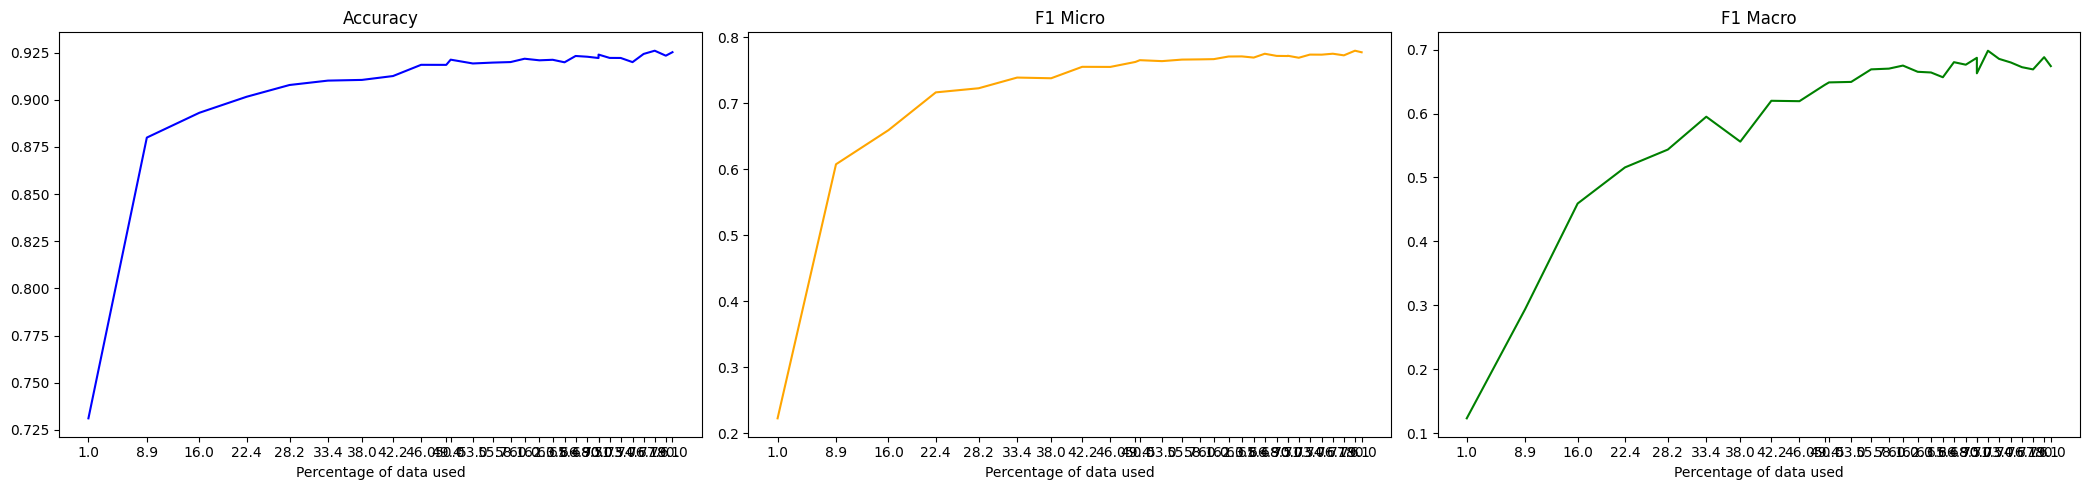

Result saved to results/hsd-kmeans-init-1-1-results.csv


In [30]:
initial_train_size = int(0.01 * total_data)
active_learning(50, 0, 'kmeans', 1)

Init Size: 10
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5474, Accuracy: 0.8279, F1 Micro: 0.0032, F1 Macro: 0.0013
Epoch 2/10, Train Loss: 0.4068, Accuracy: 0.8279, F1 Micro: 0.0018, F1 Macro: 0.0008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3684, Accuracy: 0.8403, F1 Micro: 0.161, F1 Macro: 0.0593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3529, Accuracy: 0.859, F1 Micro: 0.3835, F1 Macro: 0.1446
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3238, Accuracy: 0.8755, F1 Micro: 0.5261, F1 Macro: 0.2466
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2939, Accuracy: 0.8816, F1 Micro: 0.612, F1 Macro: 0.3107
Epoch 7/10, Train Loss: 0.2625, Accuracy: 0.8851, F1 Micro: 0.6102, F1 Macro: 0.3322
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.227, Accuracy: 0.887, F1 Micro: 0.6172, F1 Macro: 0.3778
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2146, Accuracy: 0.8885, F1 Micro: 0.6626, F1 Macro: 0.4638
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4964, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.377, Accuracy: 0.8359, F1 Micro: 0.1177, F1 Macro: 0.0411
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3554, Accuracy: 0.8665, F1 Micro: 0.446, F1 Macro: 0.1921
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3119, Accuracy: 0.8812, F1 Micro: 0.6253, F1 Macro: 0.3145
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2663, Accuracy: 0.8878, F1 Micro: 0.6628, F1 Macro: 0.4285
Epoch 6/10, Train Loss: 0.2416, Accuracy: 0.8947, F1 Micro: 0.662, F1 Macro: 0.4427
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2094, Accuracy: 0.8985, F1 Micro: 0.6849, F1 Macro: 0.4839
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1869, Accuracy: 0.8996, F1 Micro: 0.6987, F1 Macro: 0.5069
Epoch 9/10, Train Loss: 0.1648, Accuracy: 0.9022, F1 Micro: 0.6934, F1 Macro: 0.5131
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4682, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3668, Accuracy: 0.8532, F1 Micro: 0.3139, F1 Macro: 0.1068
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.315, Accuracy: 0.8807, F1 Micro: 0.5761, F1 Macro: 0.2805
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2703, Accuracy: 0.8903, F1 Micro: 0.6296, F1 Macro: 0.3508
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2303, Accuracy: 0.8956, F1 Micro: 0.655, F1 Macro: 0.457
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2043, Accuracy: 0.898, F1 Micro: 0.6603, F1 Macro: 0.486
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1722, Accuracy: 0.9024, F1 Micro: 0.7058, F1 Macro: 0.5411
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1561, Accuracy: 0.902, F1 Micro: 0.7106, F1 Macro: 0.5317
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1333, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4525, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3574, Accuracy: 0.8695, F1 Micro: 0.4527, F1 Macro: 0.199
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3, Accuracy: 0.8865, F1 Micro: 0.6429, F1 Macro: 0.3463
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2558, Accuracy: 0.8971, F1 Micro: 0.6707, F1 Macro: 0.4484
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2144, Accuracy: 0.8993, F1 Micro: 0.687, F1 Macro: 0.5026
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1902, Accuracy: 0.9045, F1 Micro: 0.7019, F1 Macro: 0.5029
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1575, Accuracy: 0.906, F1 Micro: 0.7041, F1 Macro: 0.5253
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.139, Accuracy: 0.9074, F1 Micro: 0.7176, F1 Macro: 0.5505
Epoch 9/10, Train Loss: 0.1215, Accuracy: 0.908, F1 Micro: 0.7092, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.447, Accuracy: 0.8386, F1 Micro: 0.1361, F1 Macro: 0.0526
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3494, Accuracy: 0.8789, F1 Micro: 0.5514, F1 Macro: 0.2637
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.275, Accuracy: 0.8941, F1 Micro: 0.6713, F1 Macro: 0.4139
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2463, Accuracy: 0.9014, F1 Micro: 0.6913, F1 Macro: 0.4902
Epoch 5/10, Train Loss: 0.2051, Accuracy: 0.9045, F1 Micro: 0.6869, F1 Macro: 0.4936
Epoch 6/10, Train Loss: 0.1766, Accuracy: 0.9051, F1 Micro: 0.6784, F1 Macro: 0.519
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1555, Accuracy: 0.91, F1 Micro: 0.7278, F1 Macro: 0.5629
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1244, Accuracy: 0.9111, F1 Micro: 0.7346, F1 Macro: 0.5844
Epoch 9/10, Train Loss: 0.1048, Accuracy: 0.9096, F1 Micro: 0.7302, F1 Macro: 0.5967
Epoch 10/10, Train Loss: 0.0927, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.436, Accuracy: 0.8383, F1 Micro: 0.1398, F1 Macro: 0.0526
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3307, Accuracy: 0.8845, F1 Micro: 0.5905, F1 Macro: 0.2942
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2726, Accuracy: 0.8987, F1 Micro: 0.6772, F1 Macro: 0.4276
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.23, Accuracy: 0.9045, F1 Micro: 0.7003, F1 Macro: 0.4929
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1922, Accuracy: 0.9062, F1 Micro: 0.7178, F1 Macro: 0.5519
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1662, Accuracy: 0.9102, F1 Micro: 0.7302, F1 Macro: 0.5717
Epoch 7/10, Train Loss: 0.141, Accuracy: 0.912, F1 Micro: 0.7203, F1 Macro: 0.5471
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1153, Accuracy: 0.9137, F1 Micro: 0.734, F1 Macro: 0.5903
Epoch 9/10, Train Loss: 0.1029, Accuracy: 0.9113, F1 Micro: 0.7299, F1 Macro: 0.5843
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4278, Accuracy: 0.8495, F1 Micro: 0.2746, F1 Macro: 0.0939
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3234, Accuracy: 0.8896, F1 Micro: 0.6182, F1 Macro: 0.3431
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2572, Accuracy: 0.9009, F1 Micro: 0.6689, F1 Macro: 0.4628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2155, Accuracy: 0.907, F1 Micro: 0.7048, F1 Macro: 0.4957
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1813, Accuracy: 0.9122, F1 Micro: 0.724, F1 Macro: 0.5572
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1535, Accuracy: 0.9118, F1 Micro: 0.743, F1 Macro: 0.5813
Epoch 7/10, Train Loss: 0.1282, Accuracy: 0.9086, F1 Micro: 0.7396, F1 Macro: 0.5912
Epoch 8/10, Train Loss: 0.1094, Accuracy: 0.9144, F1 Micro: 0.7233, F1 Macro: 0.5677
Epoch 9/10, Train Loss: 0.092, Accuracy: 0.9147, F1 Micro: 0.7402, F1 Macro: 0.6192
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4266, Accuracy: 0.8633, F1 Micro: 0.443, F1 Macro: 0.1633
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3172, Accuracy: 0.8902, F1 Micro: 0.624, F1 Macro: 0.3462
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2559, Accuracy: 0.9003, F1 Micro: 0.6667, F1 Macro: 0.4541
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.221, Accuracy: 0.9073, F1 Micro: 0.6985, F1 Macro: 0.5139
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1852, Accuracy: 0.9142, F1 Micro: 0.7254, F1 Macro: 0.5477
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1578, Accuracy: 0.9136, F1 Micro: 0.7359, F1 Macro: 0.5818
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1309, Accuracy: 0.9145, F1 Micro: 0.7426, F1 Macro: 0.5975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1109, Accuracy: 0.9159, F1 Micro: 0.7486, F1 Macro: 0.6224
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4197, Accuracy: 0.8668, F1 Micro: 0.4724, F1 Macro: 0.1971
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3059, Accuracy: 0.8952, F1 Micro: 0.6611, F1 Macro: 0.4379
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2472, Accuracy: 0.9045, F1 Micro: 0.7104, F1 Macro: 0.4961
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2148, Accuracy: 0.9127, F1 Micro: 0.7209, F1 Macro: 0.5289
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1762, Accuracy: 0.9158, F1 Micro: 0.7435, F1 Macro: 0.5623
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1499, Accuracy: 0.9173, F1 Micro: 0.7452, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.125, Accuracy: 0.9172, F1 Micro: 0.7567, F1 Macro: 0.6268
Epoch 8/10, Train Loss: 0.1052, Accuracy: 0.9162, F1 Micro: 0.7557, F1 Macro: 0.6409
Epoch 9/10, Train Loss: 0.0874, Accuracy: 0.9175, F1 Micro: 0.7544, F1 Macro: 0.6283
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4231, Accuracy: 0.8628, F1 Micro: 0.4119, F1 Macro: 0.1426
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3095, Accuracy: 0.8921, F1 Micro: 0.6794, F1 Macro: 0.4617
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2491, Accuracy: 0.9032, F1 Micro: 0.7006, F1 Macro: 0.4951
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2082, Accuracy: 0.9107, F1 Micro: 0.7109, F1 Macro: 0.546
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1836, Accuracy: 0.9139, F1 Micro: 0.7391, F1 Macro: 0.5508
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.146, Accuracy: 0.9171, F1 Micro: 0.7494, F1 Macro: 0.6204
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1236, Accuracy: 0.9189, F1 Micro: 0.7518, F1 Macro: 0.6181
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1043, Accuracy: 0.9188, F1 Micro: 0.7551, F1 Macro: 0.6451
Epoch 9/10, Train Loss: 0.091, Accuracy: 0.9154, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4157, Accuracy: 0.873, F1 Micro: 0.5238, F1 Macro: 0.231
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2959, Accuracy: 0.8947, F1 Micro: 0.6457, F1 Macro: 0.3519
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2444, Accuracy: 0.9064, F1 Micro: 0.7171, F1 Macro: 0.5426
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2032, Accuracy: 0.9135, F1 Micro: 0.7401, F1 Macro: 0.5655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1759, Accuracy: 0.9117, F1 Micro: 0.7454, F1 Macro: 0.5826
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1437, Accuracy: 0.9169, F1 Micro: 0.7546, F1 Macro: 0.6016
Epoch 7/10, Train Loss: 0.1278, Accuracy: 0.9195, F1 Micro: 0.7521, F1 Macro: 0.6208
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1021, Accuracy: 0.9198, F1 Micro: 0.7594, F1 Macro: 0.6403
Epoch 9/10, Train Loss: 0.089, Accuracy: 0.92, F1 Micro: 0.7531, F1 Macro: 0.6478
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4142, Accuracy: 0.873, F1 Micro: 0.487, F1 Macro: 0.2116
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2948, Accuracy: 0.8931, F1 Micro: 0.6126, F1 Macro: 0.3984
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2371, Accuracy: 0.907, F1 Micro: 0.7244, F1 Macro: 0.5599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1979, Accuracy: 0.9156, F1 Micro: 0.7396, F1 Macro: 0.5739
Epoch 5/10, Train Loss: 0.1672, Accuracy: 0.9149, F1 Micro: 0.7229, F1 Macro: 0.5601
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9164, F1 Micro: 0.7527, F1 Macro: 0.6141
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.119, Accuracy: 0.9185, F1 Micro: 0.761, F1 Macro: 0.6372
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1007, Accuracy: 0.92, F1 Micro: 0.7672, F1 Macro: 0.6511
Epoch 9/10, Train Loss: 0.0851, Accuracy: 0.9166, F1 Micro: 0.7654, F1 Macro: 0.6673
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4113, Accuracy: 0.8774, F1 Micro: 0.5454, F1 Macro: 0.2495
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2981, Accuracy: 0.8995, F1 Micro: 0.6796, F1 Macro: 0.4458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2361, Accuracy: 0.9088, F1 Micro: 0.7072, F1 Macro: 0.5176
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2028, Accuracy: 0.9161, F1 Micro: 0.7325, F1 Macro: 0.5586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1694, Accuracy: 0.9156, F1 Micro: 0.7437, F1 Macro: 0.5944
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1455, Accuracy: 0.9207, F1 Micro: 0.756, F1 Macro: 0.6171
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1194, Accuracy: 0.9199, F1 Micro: 0.7574, F1 Macro: 0.6092
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.099, Accuracy: 0.9205, F1 Micro: 0.7668, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.406, Accuracy: 0.8801, F1 Micro: 0.5703, F1 Macro: 0.2715
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2895, Accuracy: 0.9002, F1 Micro: 0.6917, F1 Macro: 0.4619
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2356, Accuracy: 0.9094, F1 Micro: 0.7078, F1 Macro: 0.5074
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1969, Accuracy: 0.9142, F1 Micro: 0.751, F1 Macro: 0.5809
Epoch 5/10, Train Loss: 0.1654, Accuracy: 0.9184, F1 Micro: 0.7451, F1 Macro: 0.5899
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.9206, F1 Micro: 0.766, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1197, Accuracy: 0.9242, F1 Micro: 0.7684, F1 Macro: 0.6478
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9208, F1 Micro: 0.7653, F1 Macro: 0.6478
Epoch 9/10, Train Loss: 0.085, Accuracy: 0.9209, F1 Micro: 0.7609, F1 Macro: 0.6575
Epoch 10/10, Train Loss: 0.0756, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4086, Accuracy: 0.8785, F1 Micro: 0.6031, F1 Macro: 0.2928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2901, Accuracy: 0.8983, F1 Micro: 0.6531, F1 Macro: 0.4395
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2329, Accuracy: 0.908, F1 Micro: 0.7176, F1 Macro: 0.5147
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1968, Accuracy: 0.9152, F1 Micro: 0.7462, F1 Macro: 0.5645
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1624, Accuracy: 0.9185, F1 Micro: 0.756, F1 Macro: 0.5977
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.9214, F1 Micro: 0.7575, F1 Macro: 0.6269
Epoch 7/10, Train Loss: 0.116, Accuracy: 0.9187, F1 Micro: 0.7569, F1 Macro: 0.6411
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1008, Accuracy: 0.9215, F1 Micro: 0.7655, F1 Macro: 0.6558
Epoch 9/10, Train Loss: 0.0822, Accuracy: 0.9194, F1 Micro: 0.7631, F1 Macro: 0.6475
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4029, Accuracy: 0.8807, F1 Micro: 0.6213, F1 Macro: 0.3046
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2807, Accuracy: 0.9014, F1 Micro: 0.6805, F1 Macro: 0.4751
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.231, Accuracy: 0.9095, F1 Micro: 0.6963, F1 Macro: 0.5105
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1889, Accuracy: 0.9159, F1 Micro: 0.7282, F1 Macro: 0.5637
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1585, Accuracy: 0.9187, F1 Micro: 0.7575, F1 Macro: 0.6165
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1358, Accuracy: 0.9228, F1 Micro: 0.7699, F1 Macro: 0.6548
Epoch 7/10, Train Loss: 0.112, Accuracy: 0.9192, F1 Micro: 0.7653, F1 Macro: 0.6299
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0955, Accuracy: 0.9217, F1 Micro: 0.7709, F1 Macro: 0.6703
Epoch 9/10, Train Loss: 0.0833, Accuracy: 0.9222, F1 Micro: 0.7689, F1 Macro: 0.6788
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3974, Accuracy: 0.8785, F1 Micro: 0.5464, F1 Macro: 0.2592
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.28, Accuracy: 0.902, F1 Micro: 0.6971, F1 Macro: 0.5229
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2267, Accuracy: 0.9123, F1 Micro: 0.73, F1 Macro: 0.5552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1891, Accuracy: 0.918, F1 Micro: 0.7535, F1 Macro: 0.6018
Epoch 5/10, Train Loss: 0.1556, Accuracy: 0.9218, F1 Micro: 0.7527, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1342, Accuracy: 0.92, F1 Micro: 0.7709, F1 Macro: 0.6575
Epoch 7/10, Train Loss: 0.1127, Accuracy: 0.9225, F1 Micro: 0.7706, F1 Macro: 0.6591
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.9201, F1 Micro: 0.7718, F1 Macro: 0.6711
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.9223, F1 Micro: 0.7674, F1 Macro: 0.6747
Epoch 10/10, Train Loss: 0.0689, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3982, Accuracy: 0.8813, F1 Micro: 0.5909, F1 Macro: 0.2842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2722, Accuracy: 0.9042, F1 Micro: 0.6927, F1 Macro: 0.5105
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2266, Accuracy: 0.913, F1 Micro: 0.7372, F1 Macro: 0.5786
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1878, Accuracy: 0.9176, F1 Micro: 0.7549, F1 Macro: 0.6084
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9207, F1 Micro: 0.7628, F1 Macro: 0.6249
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.9102, F1 Micro: 0.7598, F1 Macro: 0.6545
Epoch 7/10, Train Loss: 0.1116, Accuracy: 0.9214, F1 Micro: 0.7606, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0918, Accuracy: 0.923, F1 Micro: 0.7669, F1 Macro: 0.6724
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.9196, F1 Micro: 0.7651, F1 Macro: 0.6716
Epoch 10/10, Train Loss: 0.0691, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.399, Accuracy: 0.8772, F1 Micro: 0.6416, F1 Macro: 0.3225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2706, Accuracy: 0.904, F1 Micro: 0.707, F1 Macro: 0.4576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2198, Accuracy: 0.9123, F1 Micro: 0.7128, F1 Macro: 0.516
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1849, Accuracy: 0.9165, F1 Micro: 0.7478, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1571, Accuracy: 0.9215, F1 Micro: 0.7639, F1 Macro: 0.628
Epoch 6/10, Train Loss: 0.1339, Accuracy: 0.9237, F1 Micro: 0.7628, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1112, Accuracy: 0.9188, F1 Micro: 0.7705, F1 Macro: 0.667
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0923, Accuracy: 0.9252, F1 Micro: 0.7736, F1 Macro: 0.6814
Epoch 9/10, Train Loss: 0.0808, Accuracy: 0.921, F1 Micro: 0.7649, F1 Macro: 0.674
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3977, Accuracy: 0.8848, F1 Micro: 0.6295, F1 Macro: 0.3217
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2724, Accuracy: 0.9033, F1 Micro: 0.6809, F1 Macro: 0.457
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2194, Accuracy: 0.9146, F1 Micro: 0.7479, F1 Macro: 0.5842
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1864, Accuracy: 0.9183, F1 Micro: 0.7568, F1 Macro: 0.6122
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1537, Accuracy: 0.9206, F1 Micro: 0.7681, F1 Macro: 0.6347
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9224, F1 Micro: 0.7733, F1 Macro: 0.6688
Epoch 7/10, Train Loss: 0.1093, Accuracy: 0.924, F1 Micro: 0.7705, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0929, Accuracy: 0.9245, F1 Micro: 0.7761, F1 Macro: 0.6835
Epoch 9/10, Train Loss: 0.0792, Accuracy: 0.9207, F1 Micro: 0.7753, F1 Macro: 0.6906
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.39, Accuracy: 0.8837, F1 Micro: 0.6021, F1 Macro: 0.3001
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.27, Accuracy: 0.9041, F1 Micro: 0.6906, F1 Macro: 0.4603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2151, Accuracy: 0.9146, F1 Micro: 0.7382, F1 Macro: 0.559
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1829, Accuracy: 0.9188, F1 Micro: 0.7413, F1 Macro: 0.5971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1555, Accuracy: 0.9209, F1 Micro: 0.7596, F1 Macro: 0.6331
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1332, Accuracy: 0.9224, F1 Micro: 0.7674, F1 Macro: 0.6422
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1084, Accuracy: 0.9223, F1 Micro: 0.7726, F1 Macro: 0.6859
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.922, F1 Micro: 0.7756, F1 Macro: 0.6833
Epoch 9/10, Train Loss: 0.0774, Accuracy: 0.9234, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3928, Accuracy: 0.8834, F1 Micro: 0.5819, F1 Macro: 0.286
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2703, Accuracy: 0.9049, F1 Micro: 0.6901, F1 Macro: 0.496
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2159, Accuracy: 0.9071, F1 Micro: 0.7412, F1 Macro: 0.5778
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1809, Accuracy: 0.9184, F1 Micro: 0.7598, F1 Macro: 0.6103
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1511, Accuracy: 0.9229, F1 Micro: 0.7646, F1 Macro: 0.6365
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1285, Accuracy: 0.9236, F1 Micro: 0.7702, F1 Macro: 0.6391
Epoch 7/10, Train Loss: 0.1065, Accuracy: 0.9234, F1 Micro: 0.7698, F1 Macro: 0.6706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.9244, F1 Micro: 0.777, F1 Macro: 0.6807
Epoch 9/10, Train Loss: 0.0744, Accuracy: 0.9252, F1 Micro: 0.7765, F1 Macro: 0.689
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3915, Accuracy: 0.8845, F1 Micro: 0.5918, F1 Macro: 0.2921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2657, Accuracy: 0.9073, F1 Micro: 0.7067, F1 Macro: 0.5009
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2168, Accuracy: 0.9157, F1 Micro: 0.7322, F1 Macro: 0.5535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1859, Accuracy: 0.9213, F1 Micro: 0.7597, F1 Macro: 0.619
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1532, Accuracy: 0.9214, F1 Micro: 0.7621, F1 Macro: 0.6439
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.129, Accuracy: 0.9238, F1 Micro: 0.7738, F1 Macro: 0.671
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1074, Accuracy: 0.9244, F1 Micro: 0.7795, F1 Macro: 0.6884
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9247, F1 Micro: 0.7685, F1 Macro: 0.682
Epoch 9/10, Train Loss: 0.0757, Accuracy: 0.9163, F1 Micro: 0.7649, F1 Macro: 0.6807
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.385, Accuracy: 0.8856, F1 Micro: 0.6305, F1 Macro: 0.3315
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2572, Accuracy: 0.9072, F1 Micro: 0.71, F1 Macro: 0.4903
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2151, Accuracy: 0.9143, F1 Micro: 0.7199, F1 Macro: 0.5515
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1835, Accuracy: 0.9196, F1 Micro: 0.7585, F1 Macro: 0.6076
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1489, Accuracy: 0.9213, F1 Micro: 0.7684, F1 Macro: 0.6501
Epoch 6/10, Train Loss: 0.1287, Accuracy: 0.9208, F1 Micro: 0.7644, F1 Macro: 0.6636
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.9212, F1 Micro: 0.769, F1 Macro: 0.6617
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.9227, F1 Micro: 0.7681, F1 Macro: 0.6812
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0743, Accuracy: 0.9207, F1 Micro: 0.77, F1 Macro: 0.6731
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3826, Accuracy: 0.8864, F1 Micro: 0.6389, F1 Macro: 0.3208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2589, Accuracy: 0.9062, F1 Micro: 0.723, F1 Macro: 0.5189
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2104, Accuracy: 0.9172, F1 Micro: 0.7493, F1 Macro: 0.5815
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.9199, F1 Micro: 0.7632, F1 Macro: 0.6061
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.9226, F1 Micro: 0.7659, F1 Macro: 0.6565
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.9234, F1 Micro: 0.7723, F1 Macro: 0.6419
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.922, F1 Micro: 0.771, F1 Macro: 0.6716
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9185, F1 Micro: 0.7723, F1 Macro: 0.6766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9244, F1 Micro: 0.776, F1 Macro: 0.6882
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3794, Accuracy: 0.8866, F1 Micro: 0.6024, F1 Macro: 0.2984
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2542, Accuracy: 0.9065, F1 Micro: 0.6965, F1 Macro: 0.4923
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2107, Accuracy: 0.9126, F1 Micro: 0.7443, F1 Macro: 0.5656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1732, Accuracy: 0.9182, F1 Micro: 0.7642, F1 Macro: 0.6252
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1456, Accuracy: 0.9236, F1 Micro: 0.7721, F1 Macro: 0.6412
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1205, Accuracy: 0.9236, F1 Micro: 0.7724, F1 Macro: 0.6599
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1041, Accuracy: 0.9238, F1 Micro: 0.7813, F1 Macro: 0.6852
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9227, F1 Micro: 0.7718, F1 Macro: 0.6857
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9235, F1 Micro: 0.7743, F1 Macro: 0.6959
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3784, Accuracy: 0.8885, F1 Micro: 0.6383, F1 Macro: 0.3279
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2542, Accuracy: 0.9036, F1 Micro: 0.7187, F1 Macro: 0.5593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2072, Accuracy: 0.9156, F1 Micro: 0.7267, F1 Macro: 0.5781
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9167, F1 Micro: 0.7615, F1 Macro: 0.6138
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1435, Accuracy: 0.9222, F1 Micro: 0.7674, F1 Macro: 0.6304
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1174, Accuracy: 0.9216, F1 Micro: 0.7701, F1 Macro: 0.6753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0999, Accuracy: 0.922, F1 Micro: 0.7758, F1 Macro: 0.693
Epoch 8/10, Train Loss: 0.0817, Accuracy: 0.9211, F1 Micro: 0.7705, F1 Macro: 0.6929
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9204, F1 Micro: 0.7729, F1 Macro: 0.7031
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3779, Accuracy: 0.8884, F1 Micro: 0.615, F1 Macro: 0.3197
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.9081, F1 Micro: 0.6956, F1 Macro: 0.4954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2046, Accuracy: 0.9155, F1 Micro: 0.749, F1 Macro: 0.5664
Epoch 4/10, Train Loss: 0.1682, Accuracy: 0.9201, F1 Micro: 0.748, F1 Macro: 0.6069
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9219, F1 Micro: 0.7729, F1 Macro: 0.6585
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1172, Accuracy: 0.9249, F1 Micro: 0.7746, F1 Macro: 0.6774
Epoch 7/10, Train Loss: 0.1008, Accuracy: 0.9228, F1 Micro: 0.7711, F1 Macro: 0.6684
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.9209, F1 Micro: 0.7726, F1 Macro: 0.681
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.9204, F1 Micro: 0.7699, F1 Macro: 0.6897
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0623, Accuracy

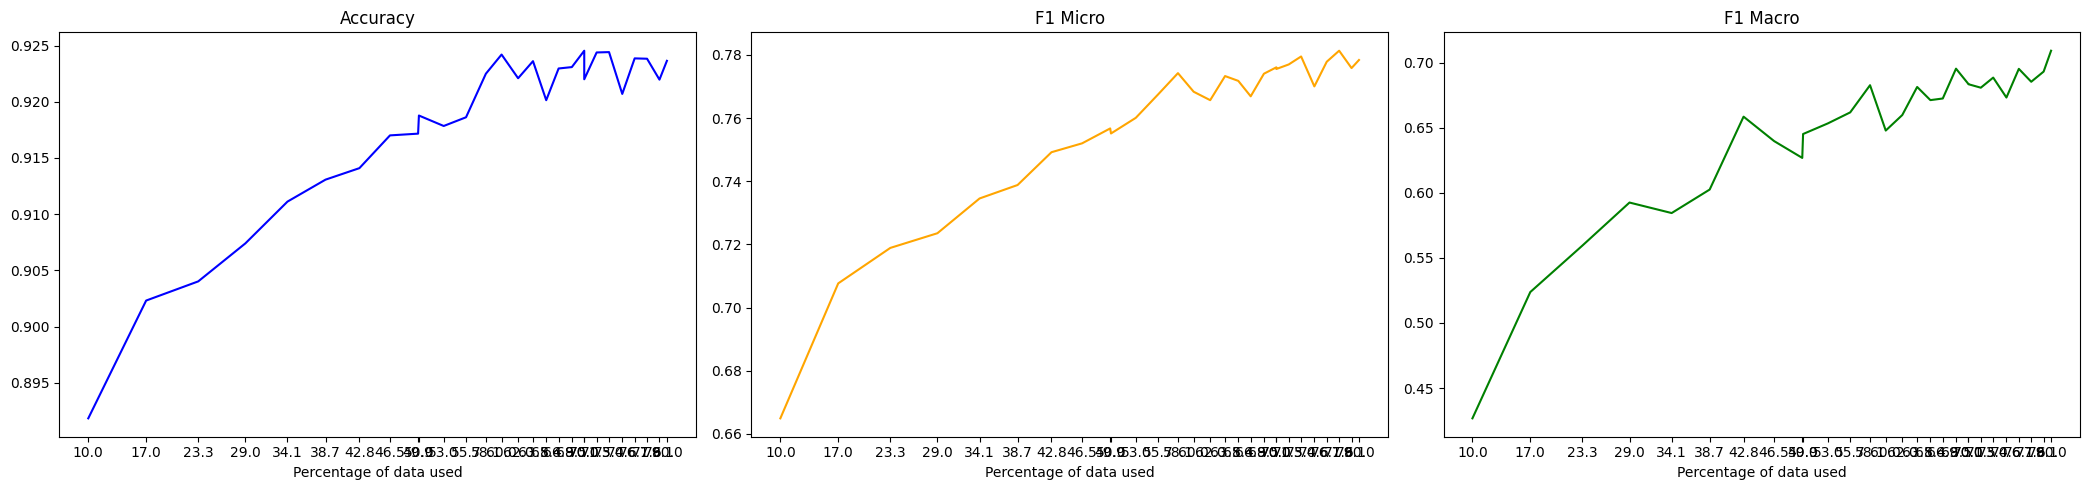

Result saved to results/hsd-kmeans-init-10-1-results.csv


In [31]:
initial_train_size = int(0.1 * total_data)
active_learning(50, 0, 'kmeans', 10)

# CORESET

Init Size: 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6814, Accuracy: 0.7312, F1 Micro: 0.2228, F1 Macro: 0.123
Epoch 2/10, Train Loss: 0.5938, Accuracy: 0.8056, F1 Micro: 0.1568, F1 Macro: 0.0557
Epoch 3/10, Train Loss: 0.5257, Accuracy: 0.8219, F1 Micro: 0.0493, F1 Macro: 0.0222
Epoch 4/10, Train Loss: 0.4783, Accuracy: 0.8273, F1 Micro: 0.0025, F1 Macro: 0.0014
Epoch 5/10, Train Loss: 0.4275, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 6/10, Train Loss: 0.3998, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 7/10, Train Loss: 0.3716, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 8/10, Train Loss: 0.3814, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 9/10, Train Loss: 0.4033, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 10/10, Train Loss: 0.3566, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Iteration 131: Accuracy: 0.7312, F1 Micro: 0.2228, F1 Macro: 0.123
               precision    recall  f1-score   support

           HS       0.38      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5394, Accuracy: 0.8277, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3636, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3244, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3115, Accuracy: 0.83, F1 Micro: 0.0335, F1 Macro: 0.0143
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2932, Accuracy: 0.8337, F1 Micro: 0.0793, F1 Macro: 0.0308
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2649, Accuracy: 0.8469, F1 Micro: 0.2272, F1 Macro: 0.0905
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2466, Accuracy: 0.8605, F1 Micro: 0.3604, F1 Macro: 0.1846
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2178, Accuracy: 0.8788, F1 Micro: 0.5577, F1 Macro: 0.3356
Epoch 9/10, Train Loss: 0.19, Accuracy: 0.8805, F1 Micro: 0.5547, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5286, Accuracy: 0.8269, F1 Micro: 0.3566, F1 Macro: 0.0966
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4143, Accuracy: 0.8505, F1 Micro: 0.522, F1 Macro: 0.2504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.347, Accuracy: 0.8799, F1 Micro: 0.594, F1 Macro: 0.3486
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2976, Accuracy: 0.8897, F1 Micro: 0.617, F1 Macro: 0.4426
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2635, Accuracy: 0.8944, F1 Micro: 0.6322, F1 Macro: 0.4829
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2314, Accuracy: 0.8981, F1 Micro: 0.6705, F1 Macro: 0.5127
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2068, Accuracy: 0.8994, F1 Micro: 0.6781, F1 Macro: 0.5334
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1781, Accuracy: 0.9023, F1 Micro: 0.6834, F1 Macro: 0.5496
Epoch 9/10, Train Loss: 0.1603, Accuracy: 0.9015, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4918, Accuracy: 0.8341, F1 Micro: 0.3963, F1 Macro: 0.1087
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3712, Accuracy: 0.8734, F1 Micro: 0.546, F1 Macro: 0.2925
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2992, Accuracy: 0.8896, F1 Micro: 0.6175, F1 Macro: 0.4154
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2499, Accuracy: 0.8983, F1 Micro: 0.6772, F1 Macro: 0.4794
Epoch 5/10, Train Loss: 0.2229, Accuracy: 0.8987, F1 Micro: 0.6653, F1 Macro: 0.4977
Epoch 6/10, Train Loss: 0.1921, Accuracy: 0.9004, F1 Micro: 0.6549, F1 Macro: 0.507
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1679, Accuracy: 0.9058, F1 Micro: 0.7115, F1 Macro: 0.5565
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1483, Accuracy: 0.9062, F1 Micro: 0.7174, F1 Macro: 0.5761
Epoch 9/10, Train Loss: 0.1244, Accuracy: 0.9064, F1 Micro: 0.6981, F1 Macro: 0.5731
Epoch 10/10, Train Loss: 0.1131, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4775, Accuracy: 0.85, F1 Micro: 0.356, F1 Macro: 0.1079
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3479, Accuracy: 0.8799, F1 Micro: 0.5652, F1 Macro: 0.3236
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2888, Accuracy: 0.8943, F1 Micro: 0.6505, F1 Macro: 0.4759
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2398, Accuracy: 0.9031, F1 Micro: 0.6983, F1 Macro: 0.5296
Epoch 5/10, Train Loss: 0.2084, Accuracy: 0.9062, F1 Micro: 0.6908, F1 Macro: 0.5341
Epoch 6/10, Train Loss: 0.1765, Accuracy: 0.9073, F1 Micro: 0.6953, F1 Macro: 0.5425
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1587, Accuracy: 0.9088, F1 Micro: 0.7139, F1 Macro: 0.5561
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1339, Accuracy: 0.9115, F1 Micro: 0.7342, F1 Macro: 0.5995
Epoch 9/10, Train Loss: 0.1159, Accuracy: 0.912, F1 Micro: 0.7304, F1 Macro: 0.5997
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4593, Accuracy: 0.8562, F1 Micro: 0.4027, F1 Macro: 0.1322
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.324, Accuracy: 0.8878, F1 Micro: 0.5988, F1 Macro: 0.3809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2618, Accuracy: 0.901, F1 Micro: 0.6815, F1 Macro: 0.4958
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.226, Accuracy: 0.9067, F1 Micro: 0.7, F1 Macro: 0.5345
Epoch 5/10, Train Loss: 0.1872, Accuracy: 0.9086, F1 Micro: 0.6963, F1 Macro: 0.565
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1582, Accuracy: 0.9101, F1 Micro: 0.7328, F1 Macro: 0.606
Epoch 7/10, Train Loss: 0.1399, Accuracy: 0.913, F1 Micro: 0.7242, F1 Macro: 0.5919
Epoch 8/10, Train Loss: 0.1169, Accuracy: 0.9121, F1 Micro: 0.7327, F1 Macro: 0.6032
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1016, Accuracy: 0.9132, F1 Micro: 0.7372, F1 Macro: 0.6224
Epoch 10/10, Train Loss: 0.0927, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4373, Accuracy: 0.8624, F1 Micro: 0.4227, F1 Macro: 0.1611
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2994, Accuracy: 0.8872, F1 Micro: 0.5886, F1 Macro: 0.3661
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2404, Accuracy: 0.903, F1 Micro: 0.6873, F1 Macro: 0.5196
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1935, Accuracy: 0.9066, F1 Micro: 0.7138, F1 Macro: 0.56
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.165, Accuracy: 0.9105, F1 Micro: 0.72, F1 Macro: 0.5841
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1418, Accuracy: 0.9119, F1 Micro: 0.7343, F1 Macro: 0.6137
Epoch 7/10, Train Loss: 0.1217, Accuracy: 0.9114, F1 Micro: 0.7202, F1 Macro: 0.6003
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1058, Accuracy: 0.9149, F1 Micro: 0.7435, F1 Macro: 0.6383
Epoch 9/10, Train Loss: 0.0941, Accuracy: 0.9133, F1 Micro: 0.7374, F1 Macro: 0.6244
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4311, Accuracy: 0.8723, F1 Micro: 0.5552, F1 Macro: 0.2552
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2863, Accuracy: 0.8913, F1 Micro: 0.616, F1 Macro: 0.3595
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2297, Accuracy: 0.9021, F1 Micro: 0.7154, F1 Macro: 0.5574
Epoch 4/10, Train Loss: 0.1957, Accuracy: 0.9064, F1 Micro: 0.6937, F1 Macro: 0.5218
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.164, Accuracy: 0.9107, F1 Micro: 0.7248, F1 Macro: 0.5824
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1366, Accuracy: 0.9119, F1 Micro: 0.7435, F1 Macro: 0.6426
Epoch 7/10, Train Loss: 0.1162, Accuracy: 0.9136, F1 Micro: 0.7371, F1 Macro: 0.6166
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1093, Accuracy: 0.912, F1 Micro: 0.7462, F1 Macro: 0.6672
Epoch 9/10, Train Loss: 0.0938, Accuracy: 0.9142, F1 Micro: 0.7317, F1 Macro: 0.6555
Epoch 10/10, Train Loss: 0.0779, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4166, Accuracy: 0.875, F1 Micro: 0.5218, F1 Macro: 0.2469
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2758, Accuracy: 0.8952, F1 Micro: 0.6435, F1 Macro: 0.4207
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2186, Accuracy: 0.9053, F1 Micro: 0.6921, F1 Macro: 0.5254
Epoch 4/10, Train Loss: 0.1811, Accuracy: 0.9082, F1 Micro: 0.6883, F1 Macro: 0.5371
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1542, Accuracy: 0.9122, F1 Micro: 0.7183, F1 Macro: 0.5687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1309, Accuracy: 0.9138, F1 Micro: 0.7196, F1 Macro: 0.6095
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1129, Accuracy: 0.9136, F1 Micro: 0.7445, F1 Macro: 0.6262
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9146, F1 Micro: 0.7377, F1 Macro: 0.6263
Epoch 9/10, Train Loss: 0.0868, Accuracy: 0.9141, F1 Micro: 0.7426, F1 Macro: 0.6722
Epoch 10/10, Train Loss: 0.0727, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4115, Accuracy: 0.8784, F1 Micro: 0.5781, F1 Macro: 0.2817
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2689, Accuracy: 0.8974, F1 Micro: 0.672, F1 Macro: 0.4757
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2114, Accuracy: 0.9058, F1 Micro: 0.7087, F1 Macro: 0.5212
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1766, Accuracy: 0.9104, F1 Micro: 0.7252, F1 Macro: 0.5812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1528, Accuracy: 0.9149, F1 Micro: 0.7389, F1 Macro: 0.6156
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.9126, F1 Micro: 0.7373, F1 Macro: 0.62
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.9151, F1 Micro: 0.7418, F1 Macro: 0.6283
Epoch 8/10, Train Loss: 0.0913, Accuracy: 0.9149, F1 Micro: 0.7386, F1 Macro: 0.6484
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.9137, F1 Micro: 0.7418, F1 Macro: 0.6521
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4127, Accuracy: 0.8772, F1 Micro: 0.6022, F1 Macro: 0.2843
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2708, Accuracy: 0.8991, F1 Micro: 0.6776, F1 Macro: 0.4428
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2101, Accuracy: 0.903, F1 Micro: 0.681, F1 Macro: 0.4776
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1789, Accuracy: 0.9103, F1 Micro: 0.7212, F1 Macro: 0.5538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1509, Accuracy: 0.9115, F1 Micro: 0.7434, F1 Macro: 0.61
Epoch 6/10, Train Loss: 0.131, Accuracy: 0.911, F1 Micro: 0.7351, F1 Macro: 0.6204
Epoch 7/10, Train Loss: 0.1121, Accuracy: 0.915, F1 Micro: 0.7377, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9161, F1 Micro: 0.7468, F1 Macro: 0.6559
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0797, Accuracy: 0.913, F1 Micro: 0.7475, F1 Macro: 0.6675
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4108, Accuracy: 0.8796, F1 Micro: 0.5902, F1 Macro: 0.2871
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2767, Accuracy: 0.8975, F1 Micro: 0.6631, F1 Macro: 0.4156
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2135, Accuracy: 0.9082, F1 Micro: 0.7177, F1 Macro: 0.542
Epoch 4/10, Train Loss: 0.1823, Accuracy: 0.9119, F1 Micro: 0.7174, F1 Macro: 0.5327
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1551, Accuracy: 0.9178, F1 Micro: 0.7467, F1 Macro: 0.6085
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1288, Accuracy: 0.913, F1 Micro: 0.7543, F1 Macro: 0.6312
Epoch 7/10, Train Loss: 0.1103, Accuracy: 0.9171, F1 Micro: 0.7483, F1 Macro: 0.6672
Epoch 8/10, Train Loss: 0.0962, Accuracy: 0.9165, F1 Micro: 0.7429, F1 Macro: 0.6618
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9144, F1 Micro: 0.7348, F1 Macro: 0.6645
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0695, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4064, Accuracy: 0.8795, F1 Micro: 0.5502, F1 Macro: 0.2694
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2693, Accuracy: 0.9006, F1 Micro: 0.6783, F1 Macro: 0.4741
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2133, Accuracy: 0.9009, F1 Micro: 0.7286, F1 Macro: 0.5699
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.9138, F1 Micro: 0.7215, F1 Macro: 0.5796
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1553, Accuracy: 0.918, F1 Micro: 0.742, F1 Macro: 0.5978
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1273, Accuracy: 0.9185, F1 Micro: 0.7431, F1 Macro: 0.6258
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1085, Accuracy: 0.9202, F1 Micro: 0.756, F1 Macro: 0.6621
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0927, Accuracy: 0.9182, F1 Micro: 0.7561, F1 Macro: 0.6621
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0822, Accuracy: 0.9138, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4087, Accuracy: 0.8814, F1 Micro: 0.6246, F1 Macro: 0.3052
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2719, Accuracy: 0.8998, F1 Micro: 0.6794, F1 Macro: 0.4326
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2135, Accuracy: 0.9099, F1 Micro: 0.7194, F1 Macro: 0.5282
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9114, F1 Micro: 0.7395, F1 Macro: 0.581
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.9135, F1 Micro: 0.7502, F1 Macro: 0.6479
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.918, F1 Micro: 0.7627, F1 Macro: 0.653
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9159, F1 Micro: 0.7558, F1 Macro: 0.6672
Epoch 8/10, Train Loss: 0.097, Accuracy: 0.92, F1 Micro: 0.7589, F1 Macro: 0.6705
Epoch 9/10, Train Loss: 0.0795, Accuracy: 0.9171, F1 Micro: 0.7549, F1 Macro: 0.6601
Epoch 10/10, Train Loss: 0.0664, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3999, Accuracy: 0.8805, F1 Micro: 0.5563, F1 Macro: 0.2746
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2652, Accuracy: 0.902, F1 Micro: 0.7036, F1 Macro: 0.5198
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2107, Accuracy: 0.9113, F1 Micro: 0.7188, F1 Macro: 0.5288
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1789, Accuracy: 0.9162, F1 Micro: 0.7517, F1 Macro: 0.5971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.919, F1 Micro: 0.7575, F1 Macro: 0.644
Epoch 6/10, Train Loss: 0.1222, Accuracy: 0.9188, F1 Micro: 0.7563, F1 Macro: 0.647
Epoch 7/10, Train Loss: 0.1059, Accuracy: 0.9179, F1 Micro: 0.7561, F1 Macro: 0.6689
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9209, F1 Micro: 0.7511, F1 Macro: 0.6648
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0798, Accuracy: 0.9182, F1 Micro: 0.7582, F1 Macro: 0.6828
Epoch 10/10, Train Loss: 0.0685, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4017, Accuracy: 0.8833, F1 Micro: 0.625, F1 Macro: 0.3072
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2644, Accuracy: 0.9034, F1 Micro: 0.6973, F1 Macro: 0.4956
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2106, Accuracy: 0.9102, F1 Micro: 0.735, F1 Macro: 0.5785
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1784, Accuracy: 0.9151, F1 Micro: 0.7536, F1 Macro: 0.6164
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1488, Accuracy: 0.9182, F1 Micro: 0.7583, F1 Macro: 0.611
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1263, Accuracy: 0.9185, F1 Micro: 0.7624, F1 Macro: 0.6634
Epoch 7/10, Train Loss: 0.1076, Accuracy: 0.9215, F1 Micro: 0.7562, F1 Macro: 0.6667
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9177, F1 Micro: 0.7573, F1 Macro: 0.6689
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0772, Accuracy: 0.9219, F1 Micro: 0.7645, F1 Macro: 0.6818
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3955, Accuracy: 0.8836, F1 Micro: 0.6046, F1 Macro: 0.2977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2586, Accuracy: 0.9012, F1 Micro: 0.7104, F1 Macro: 0.5202
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2078, Accuracy: 0.9116, F1 Micro: 0.7281, F1 Macro: 0.5665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1743, Accuracy: 0.9186, F1 Micro: 0.7478, F1 Macro: 0.6079
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1472, Accuracy: 0.9185, F1 Micro: 0.7586, F1 Macro: 0.6402
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1275, Accuracy: 0.9193, F1 Micro: 0.7621, F1 Macro: 0.6376
Epoch 7/10, Train Loss: 0.1011, Accuracy: 0.9217, F1 Micro: 0.7617, F1 Macro: 0.6723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0871, Accuracy: 0.9222, F1 Micro: 0.7637, F1 Macro: 0.6843
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.9181, F1 Micro: 0.7627, F1 Macro: 0.6859
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3945, Accuracy: 0.8841, F1 Micro: 0.6122, F1 Macro: 0.2948
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2607, Accuracy: 0.9019, F1 Micro: 0.6865, F1 Macro: 0.4732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2131, Accuracy: 0.9122, F1 Micro: 0.7288, F1 Macro: 0.5518
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.9147, F1 Micro: 0.7196, F1 Macro: 0.5759
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.9186, F1 Micro: 0.7553, F1 Macro: 0.6475
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1204, Accuracy: 0.9145, F1 Micro: 0.7579, F1 Macro: 0.6605
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9173, F1 Micro: 0.762, F1 Macro: 0.6758
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9175, F1 Micro: 0.7547, F1 Macro: 0.6681
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9213, F1 Micro: 0.7642, F1 Macro: 0.6847
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3891, Accuracy: 0.8832, F1 Micro: 0.643, F1 Macro: 0.3212
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2528, Accuracy: 0.9038, F1 Micro: 0.6739, F1 Macro: 0.4726
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2058, Accuracy: 0.9109, F1 Micro: 0.7388, F1 Macro: 0.5888
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1688, Accuracy: 0.9176, F1 Micro: 0.7528, F1 Macro: 0.6097
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1486, Accuracy: 0.9214, F1 Micro: 0.7593, F1 Macro: 0.6299
Epoch 6/10, Train Loss: 0.1232, Accuracy: 0.9198, F1 Micro: 0.7498, F1 Macro: 0.6433
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.9216, F1 Micro: 0.7593, F1 Macro: 0.6668
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0901, Accuracy: 0.9242, F1 Micro: 0.7714, F1 Macro: 0.6775
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9185, F1 Micro: 0.7589, F1 Macro: 0.6835
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3867, Accuracy: 0.8854, F1 Micro: 0.5961, F1 Macro: 0.3037
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2512, Accuracy: 0.9027, F1 Micro: 0.7103, F1 Macro: 0.5107
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.9122, F1 Micro: 0.7382, F1 Macro: 0.5801
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9147, F1 Micro: 0.7495, F1 Macro: 0.6023
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9204, F1 Micro: 0.7613, F1 Macro: 0.6421
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.122, Accuracy: 0.9174, F1 Micro: 0.7652, F1 Macro: 0.6827
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9223, F1 Micro: 0.7648, F1 Macro: 0.6758
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.9211, F1 Micro: 0.7649, F1 Macro: 0.6779
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.9238, F1 Micro: 0.773, F1 Macro: 0.698
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3887, Accuracy: 0.8852, F1 Micro: 0.6179, F1 Macro: 0.3148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2547, Accuracy: 0.9041, F1 Micro: 0.7024, F1 Macro: 0.457
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.9136, F1 Micro: 0.7463, F1 Macro: 0.579
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.9162, F1 Micro: 0.756, F1 Macro: 0.6198
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9195, F1 Micro: 0.7667, F1 Macro: 0.668
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.9178, F1 Micro: 0.7654, F1 Macro: 0.6517
Epoch 7/10, Train Loss: 0.1059, Accuracy: 0.9218, F1 Micro: 0.7558, F1 Macro: 0.6626
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0852, Accuracy: 0.9214, F1 Micro: 0.7706, F1 Macro: 0.6823
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9212, F1 Micro: 0.7677, F1 Macro: 0.6774
Epoch 10/10, Train Loss: 0.0614, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3834, Accuracy: 0.8873, F1 Micro: 0.6444, F1 Macro: 0.3292
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2545, Accuracy: 0.9041, F1 Micro: 0.7114, F1 Macro: 0.5183
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.9136, F1 Micro: 0.7344, F1 Macro: 0.5671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9192, F1 Micro: 0.7558, F1 Macro: 0.6299
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1425, Accuracy: 0.9229, F1 Micro: 0.7636, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1247, Accuracy: 0.9225, F1 Micro: 0.7726, F1 Macro: 0.6688
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.9232, F1 Micro: 0.7683, F1 Macro: 0.6799
Epoch 8/10, Train Loss: 0.0835, Accuracy: 0.9235, F1 Micro: 0.7654, F1 Macro: 0.6774
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.9199, F1 Micro: 0.766, F1 Macro: 0.6923
Epoch 10/10, Train Loss: 0.0649, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3889, Accuracy: 0.8843, F1 Micro: 0.6367, F1 Macro: 0.3269
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2561, Accuracy: 0.9054, F1 Micro: 0.7118, F1 Macro: 0.5189
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2038, Accuracy: 0.9138, F1 Micro: 0.7369, F1 Macro: 0.5863
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.9178, F1 Micro: 0.7557, F1 Macro: 0.6181
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.144, Accuracy: 0.9217, F1 Micro: 0.7607, F1 Macro: 0.633
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1248, Accuracy: 0.9238, F1 Micro: 0.7672, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1021, Accuracy: 0.9205, F1 Micro: 0.77, F1 Macro: 0.6799
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.9224, F1 Micro: 0.7671, F1 Macro: 0.67
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.9231, F1 Micro: 0.7695, F1 Macro: 0.6776
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3818, Accuracy: 0.8866, F1 Micro: 0.6149, F1 Macro: 0.3082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2486, Accuracy: 0.9065, F1 Micro: 0.7012, F1 Macro: 0.5099
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1968, Accuracy: 0.9117, F1 Micro: 0.7428, F1 Macro: 0.5913
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.9198, F1 Micro: 0.752, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1413, Accuracy: 0.922, F1 Micro: 0.764, F1 Macro: 0.6556
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.9189, F1 Micro: 0.7608, F1 Macro: 0.665
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9204, F1 Micro: 0.7676, F1 Macro: 0.6813
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9219, F1 Micro: 0.7686, F1 Macro: 0.6844
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0726, Accuracy: 0.9242, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.383, Accuracy: 0.8862, F1 Micro: 0.6431, F1 Macro: 0.3432
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.258, Accuracy: 0.9065, F1 Micro: 0.6971, F1 Macro: 0.488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2056, Accuracy: 0.9141, F1 Micro: 0.7385, F1 Macro: 0.5537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9212, F1 Micro: 0.7531, F1 Macro: 0.6091
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.922, F1 Micro: 0.7619, F1 Macro: 0.6559
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.9212, F1 Micro: 0.7687, F1 Macro: 0.6664
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0985, Accuracy: 0.9234, F1 Micro: 0.7752, F1 Macro: 0.6797
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.9243, F1 Micro: 0.7771, F1 Macro: 0.6933
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.9201, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.38, Accuracy: 0.8867, F1 Micro: 0.6421, F1 Macro: 0.3379
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2459, Accuracy: 0.906, F1 Micro: 0.7082, F1 Macro: 0.5309
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.201, Accuracy: 0.9157, F1 Micro: 0.74, F1 Macro: 0.5547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9219, F1 Micro: 0.761, F1 Macro: 0.6217
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9208, F1 Micro: 0.7659, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.121, Accuracy: 0.9208, F1 Micro: 0.7707, F1 Macro: 0.6754
Epoch 7/10, Train Loss: 0.1026, Accuracy: 0.924, F1 Micro: 0.7609, F1 Macro: 0.6516
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9204, F1 Micro: 0.773, F1 Macro: 0.6815
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9178, F1 Micro: 0.7711, F1 Macro: 0.6969
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3756, Accuracy: 0.8857, F1 Micro: 0.5904, F1 Macro: 0.3044
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2579, Accuracy: 0.9077, F1 Micro: 0.7093, F1 Macro: 0.5152
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2029, Accuracy: 0.9162, F1 Micro: 0.7462, F1 Macro: 0.5834
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9213, F1 Micro: 0.7611, F1 Macro: 0.6152
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1441, Accuracy: 0.9222, F1 Micro: 0.7654, F1 Macro: 0.619
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.121, Accuracy: 0.9237, F1 Micro: 0.7745, F1 Macro: 0.655
Epoch 7/10, Train Loss: 0.0999, Accuracy: 0.9231, F1 Micro: 0.7594, F1 Macro: 0.6407
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9231, F1 Micro: 0.7665, F1 Macro: 0.6903
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.925, F1 Micro: 0.7796, F1 Macro: 0.7056
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3725, Accuracy: 0.8887, F1 Micro: 0.6376, F1 Macro: 0.341
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2533, Accuracy: 0.907, F1 Micro: 0.7011, F1 Macro: 0.5301
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2007, Accuracy: 0.9153, F1 Micro: 0.7193, F1 Macro: 0.5448
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.9208, F1 Micro: 0.7626, F1 Macro: 0.6165
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1365, Accuracy: 0.92, F1 Micro: 0.7719, F1 Macro: 0.6639
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.9233, F1 Micro: 0.7755, F1 Macro: 0.6718
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9232, F1 Micro: 0.7637, F1 Macro: 0.6662
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9225, F1 Micro: 0.7742, F1 Macro: 0.6861
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.9238, F1 Micro: 0.7764, F1 Macro: 0.6943
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3763, Accuracy: 0.8907, F1 Micro: 0.6375, F1 Macro: 0.3247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2531, Accuracy: 0.9054, F1 Micro: 0.7059, F1 Macro: 0.5423
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.203, Accuracy: 0.9157, F1 Micro: 0.7465, F1 Macro: 0.5507
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.9213, F1 Micro: 0.7695, F1 Macro: 0.63
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.9208, F1 Micro: 0.7671, F1 Macro: 0.6243
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.9224, F1 Micro: 0.7713, F1 Macro: 0.68
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.9238, F1 Micro: 0.7692, F1 Macro: 0.6692
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9211, F1 Micro: 0.7732, F1 Macro: 0.6887
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0716, Accuracy: 0.923, F1 Micro: 0.7748, F1 Macro: 0.7026
Epoch 10/1

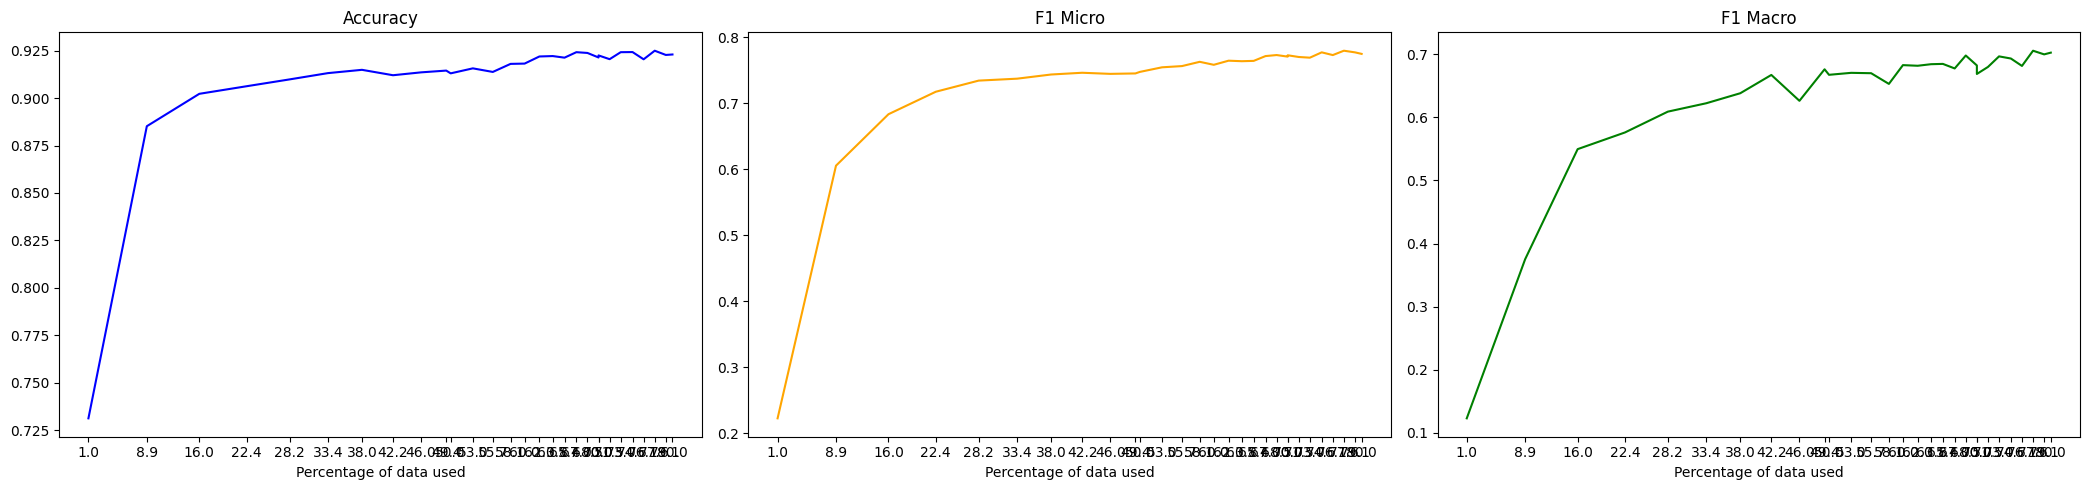

Result saved to results/hsd-coreset-init-1-1-results.csv


In [ ]:
initial_train_size = int(0.01 * total_data)
active_learning(50, 0, 'coreset', 1)

Init Size: 10
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5474, Accuracy: 0.8279, F1 Micro: 0.0032, F1 Macro: 0.0013
Epoch 2/10, Train Loss: 0.4068, Accuracy: 0.8279, F1 Micro: 0.0018, F1 Macro: 0.0008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3684, Accuracy: 0.8403, F1 Micro: 0.161, F1 Macro: 0.0593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3529, Accuracy: 0.859, F1 Micro: 0.3835, F1 Macro: 0.1446
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3238, Accuracy: 0.8755, F1 Micro: 0.5261, F1 Macro: 0.2466
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2939, Accuracy: 0.8816, F1 Micro: 0.612, F1 Macro: 0.3107
Epoch 7/10, Train Loss: 0.2625, Accuracy: 0.8851, F1 Micro: 0.6102, F1 Macro: 0.3322
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.227, Accuracy: 0.887, F1 Micro: 0.6172, F1 Macro: 0.3778
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2146, Accuracy: 0.8885, F1 Micro: 0.6626, F1 Macro: 0.4638
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.511, Accuracy: 0.8393, F1 Micro: 0.2044, F1 Macro: 0.053
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4089, Accuracy: 0.8545, F1 Micro: 0.3515, F1 Macro: 0.1276
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3567, Accuracy: 0.8767, F1 Micro: 0.5389, F1 Macro: 0.35
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3064, Accuracy: 0.887, F1 Micro: 0.5982, F1 Macro: 0.4154
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2636, Accuracy: 0.8953, F1 Micro: 0.6577, F1 Macro: 0.5013
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2347, Accuracy: 0.8977, F1 Micro: 0.6721, F1 Macro: 0.5253
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2052, Accuracy: 0.8997, F1 Micro: 0.6964, F1 Macro: 0.5429
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1799, Accuracy: 0.9004, F1 Micro: 0.7005, F1 Macro: 0.5532
Epoch 9/10, Train Loss: 0.1657, Accuracy: 0.8988, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4943, Accuracy: 0.8468, F1 Micro: 0.3748, F1 Macro: 0.1115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3783, Accuracy: 0.8685, F1 Micro: 0.497, F1 Macro: 0.2471
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3198, Accuracy: 0.886, F1 Micro: 0.6094, F1 Macro: 0.3854
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2815, Accuracy: 0.8946, F1 Micro: 0.6649, F1 Macro: 0.4979
Epoch 5/10, Train Loss: 0.2413, Accuracy: 0.8989, F1 Micro: 0.6574, F1 Macro: 0.5087
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2154, Accuracy: 0.9031, F1 Micro: 0.6928, F1 Macro: 0.5278
Epoch 7/10, Train Loss: 0.1821, Accuracy: 0.9028, F1 Micro: 0.6756, F1 Macro: 0.5367
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1704, Accuracy: 0.9027, F1 Micro: 0.6968, F1 Macro: 0.5219
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1539, Accuracy: 0.9048, F1 Micro: 0.6995, F1 Macro: 0.5559
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4578, Accuracy: 0.8438, F1 Micro: 0.2303, F1 Macro: 0.0846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3307, Accuracy: 0.8753, F1 Micro: 0.5963, F1 Macro: 0.373
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2643, Accuracy: 0.8878, F1 Micro: 0.6177, F1 Macro: 0.4294
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2251, Accuracy: 0.8982, F1 Micro: 0.6665, F1 Macro: 0.4635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1905, Accuracy: 0.9005, F1 Micro: 0.6734, F1 Macro: 0.5263
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1644, Accuracy: 0.9014, F1 Micro: 0.7039, F1 Macro: 0.541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1462, Accuracy: 0.9007, F1 Micro: 0.7113, F1 Macro: 0.5668
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1282, Accuracy: 0.9049, F1 Micro: 0.7117, F1 Macro: 0.5752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4495, Accuracy: 0.8525, F1 Micro: 0.4504, F1 Macro: 0.1722
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3175, Accuracy: 0.8853, F1 Micro: 0.5902, F1 Macro: 0.3312
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2538, Accuracy: 0.896, F1 Micro: 0.6455, F1 Macro: 0.4291
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2144, Accuracy: 0.9022, F1 Micro: 0.6894, F1 Macro: 0.5381
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1819, Accuracy: 0.9019, F1 Micro: 0.7072, F1 Macro: 0.5428
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1572, Accuracy: 0.9056, F1 Micro: 0.7107, F1 Macro: 0.5717
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1359, Accuracy: 0.9108, F1 Micro: 0.7318, F1 Macro: 0.5962
Epoch 8/10, Train Loss: 0.1188, Accuracy: 0.9109, F1 Micro: 0.73, F1 Macro: 0.6173
Epoch 9/10, Train Loss: 0.1024, Accuracy: 0.9105, F1 Micro: 0.7181, F1 Macro: 0.59
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4359, Accuracy: 0.8632, F1 Micro: 0.4491, F1 Macro: 0.1718
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3006, Accuracy: 0.8889, F1 Micro: 0.6068, F1 Macro: 0.3622
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2397, Accuracy: 0.9004, F1 Micro: 0.6838, F1 Macro: 0.4823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.201, Accuracy: 0.9063, F1 Micro: 0.7048, F1 Macro: 0.5441
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1711, Accuracy: 0.9094, F1 Micro: 0.72, F1 Macro: 0.5748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1499, Accuracy: 0.9105, F1 Micro: 0.728, F1 Macro: 0.5903
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1301, Accuracy: 0.9106, F1 Micro: 0.742, F1 Macro: 0.6176
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1164, Accuracy: 0.9126, F1 Micro: 0.7455, F1 Macro: 0.6329
Epoch 9/10, Train Loss: 0.0953, Accuracy: 0.9137, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4231, Accuracy: 0.867, F1 Micro: 0.4637, F1 Macro: 0.1877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2864, Accuracy: 0.8886, F1 Micro: 0.5864, F1 Macro: 0.3546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2241, Accuracy: 0.9037, F1 Micro: 0.6964, F1 Macro: 0.5203
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1927, Accuracy: 0.9072, F1 Micro: 0.7119, F1 Macro: 0.5494
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1593, Accuracy: 0.909, F1 Micro: 0.7271, F1 Macro: 0.5838
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.9098, F1 Micro: 0.7379, F1 Macro: 0.5899
Epoch 7/10, Train Loss: 0.1167, Accuracy: 0.9095, F1 Micro: 0.7362, F1 Macro: 0.6111
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1022, Accuracy: 0.9138, F1 Micro: 0.7407, F1 Macro: 0.6218
Epoch 9/10, Train Loss: 0.0856, Accuracy: 0.9097, F1 Micro: 0.7397, F1 Macro: 0.6436
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4159, Accuracy: 0.8689, F1 Micro: 0.4659, F1 Macro: 0.1946
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2797, Accuracy: 0.895, F1 Micro: 0.6556, F1 Macro: 0.4028
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2223, Accuracy: 0.9045, F1 Micro: 0.7048, F1 Macro: 0.5272
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1791, Accuracy: 0.9094, F1 Micro: 0.7278, F1 Macro: 0.5597
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.152, Accuracy: 0.9112, F1 Micro: 0.7333, F1 Macro: 0.5822
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1331, Accuracy: 0.9147, F1 Micro: 0.7457, F1 Macro: 0.6094
Epoch 7/10, Train Loss: 0.1118, Accuracy: 0.9159, F1 Micro: 0.7346, F1 Macro: 0.6057
Epoch 8/10, Train Loss: 0.0915, Accuracy: 0.9146, F1 Micro: 0.7438, F1 Macro: 0.6206
Epoch 9/10, Train Loss: 0.0845, Accuracy: 0.9146, F1 Micro: 0.7432, F1 Macro: 0.6398
Epoch 10/10, Train Loss: 0.0691, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4065, Accuracy: 0.8718, F1 Micro: 0.4859, F1 Macro: 0.2173
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2713, Accuracy: 0.8976, F1 Micro: 0.6758, F1 Macro: 0.4689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.208, Accuracy: 0.9063, F1 Micro: 0.6992, F1 Macro: 0.5199
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1743, Accuracy: 0.9118, F1 Micro: 0.7304, F1 Macro: 0.5757
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1487, Accuracy: 0.9137, F1 Micro: 0.7307, F1 Macro: 0.5888
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9151, F1 Micro: 0.7448, F1 Macro: 0.6171
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9155, F1 Micro: 0.7491, F1 Macro: 0.6255
Epoch 8/10, Train Loss: 0.0901, Accuracy: 0.9112, F1 Micro: 0.7418, F1 Macro: 0.6407
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.9175, F1 Micro: 0.7416, F1 Macro: 0.6296
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.407, Accuracy: 0.8752, F1 Micro: 0.5309, F1 Macro: 0.246
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2718, Accuracy: 0.8956, F1 Micro: 0.6589, F1 Macro: 0.4569
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.9054, F1 Micro: 0.7056, F1 Macro: 0.5303
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.9107, F1 Micro: 0.7171, F1 Macro: 0.5514
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.9095, F1 Micro: 0.7367, F1 Macro: 0.6
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1252, Accuracy: 0.9132, F1 Micro: 0.745, F1 Macro: 0.63
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9175, F1 Micro: 0.75, F1 Macro: 0.6323
Epoch 8/10, Train Loss: 0.086, Accuracy: 0.916, F1 Micro: 0.7433, F1 Macro: 0.6489
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.9149, F1 Micro: 0.7484, F1 Macro: 0.6543
Epoch 10/10, Tra

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3985, Accuracy: 0.8789, F1 Micro: 0.5611, F1 Macro: 0.2686
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2654, Accuracy: 0.8989, F1 Micro: 0.6804, F1 Macro: 0.4636
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.9045, F1 Micro: 0.7194, F1 Macro: 0.5374
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1694, Accuracy: 0.9117, F1 Micro: 0.7355, F1 Macro: 0.5842
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9157, F1 Micro: 0.7393, F1 Macro: 0.6042
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9174, F1 Micro: 0.7409, F1 Macro: 0.6183
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1037, Accuracy: 0.9185, F1 Micro: 0.7523, F1 Macro: 0.6585
Epoch 8/10, Train Loss: 0.0871, Accuracy: 0.9108, F1 Micro: 0.749, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.9192, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3933, Accuracy: 0.8792, F1 Micro: 0.5857, F1 Macro: 0.2866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.8956, F1 Micro: 0.6328, F1 Macro: 0.4493
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.201, Accuracy: 0.9082, F1 Micro: 0.7108, F1 Macro: 0.5277
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.91, F1 Micro: 0.7134, F1 Macro: 0.5832
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1443, Accuracy: 0.915, F1 Micro: 0.7315, F1 Macro: 0.6056
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.9169, F1 Micro: 0.7491, F1 Macro: 0.6451
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1027, Accuracy: 0.9179, F1 Micro: 0.7501, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9154, F1 Micro: 0.753, F1 Macro: 0.6746
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.073

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3922, Accuracy: 0.8805, F1 Micro: 0.6027, F1 Macro: 0.2984
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2524, Accuracy: 0.8996, F1 Micro: 0.6917, F1 Macro: 0.459
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2072, Accuracy: 0.9046, F1 Micro: 0.7243, F1 Macro: 0.5389
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.9144, F1 Micro: 0.7398, F1 Macro: 0.5892
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9143, F1 Micro: 0.7532, F1 Macro: 0.6374
Epoch 6/10, Train Loss: 0.1214, Accuracy: 0.9161, F1 Micro: 0.731, F1 Macro: 0.6324
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.9185, F1 Micro: 0.7556, F1 Macro: 0.6646
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.9161, F1 Micro: 0.7582, F1 Macro: 0.6744
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0744, Accuracy: 0.9195, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3915, Accuracy: 0.8802, F1 Micro: 0.6192, F1 Macro: 0.3136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2514, Accuracy: 0.9014, F1 Micro: 0.6917, F1 Macro: 0.5075
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2015, Accuracy: 0.9094, F1 Micro: 0.7148, F1 Macro: 0.5551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1697, Accuracy: 0.9063, F1 Micro: 0.7395, F1 Macro: 0.5996
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9134, F1 Micro: 0.75, F1 Macro: 0.627
Epoch 6/10, Train Loss: 0.1182, Accuracy: 0.9179, F1 Micro: 0.7472, F1 Macro: 0.6459
Epoch 7/10, Train Loss: 0.1009, Accuracy: 0.9178, F1 Micro: 0.7469, F1 Macro: 0.6488
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9167, F1 Micro: 0.7552, F1 Macro: 0.6681
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.9164, F1 Micro: 0.7593, F1 Macro: 0.6781
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.8803, F1 Micro: 0.5727, F1 Macro: 0.2793
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2504, Accuracy: 0.9016, F1 Micro: 0.6921, F1 Macro: 0.4951
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.201, Accuracy: 0.9094, F1 Micro: 0.7188, F1 Macro: 0.5619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9138, F1 Micro: 0.725, F1 Macro: 0.5672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.9129, F1 Micro: 0.7545, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.9205, F1 Micro: 0.7575, F1 Macro: 0.652
Epoch 7/10, Train Loss: 0.1021, Accuracy: 0.9137, F1 Micro: 0.7526, F1 Macro: 0.6559
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0895, Accuracy: 0.9218, F1 Micro: 0.7593, F1 Macro: 0.679
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9178, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3864, Accuracy: 0.8758, F1 Micro: 0.5017, F1 Macro: 0.2326
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2533, Accuracy: 0.9007, F1 Micro: 0.6982, F1 Macro: 0.4686
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1998, Accuracy: 0.9095, F1 Micro: 0.7339, F1 Macro: 0.5739
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.915, F1 Micro: 0.7483, F1 Macro: 0.6055
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9127, F1 Micro: 0.7521, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9156, F1 Micro: 0.7561, F1 Macro: 0.6624
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0977, Accuracy: 0.9183, F1 Micro: 0.7621, F1 Macro: 0.6659
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9183, F1 Micro: 0.7647, F1 Macro: 0.6797
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3813, Accuracy: 0.8823, F1 Micro: 0.594, F1 Macro: 0.2879
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2488, Accuracy: 0.9023, F1 Micro: 0.6887, F1 Macro: 0.5173
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1955, Accuracy: 0.9119, F1 Micro: 0.7252, F1 Macro: 0.5642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.9159, F1 Micro: 0.7432, F1 Macro: 0.6002
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1398, Accuracy: 0.9191, F1 Micro: 0.7447, F1 Macro: 0.6169
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1185, Accuracy: 0.9202, F1 Micro: 0.764, F1 Macro: 0.6522
Epoch 7/10, Train Loss: 0.097, Accuracy: 0.9169, F1 Micro: 0.7603, F1 Macro: 0.6751
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9219, F1 Micro: 0.764, F1 Macro: 0.6793
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.9169, F1 Micro: 0.7604, F1 Macro: 0.6844
Epoch 10/10, Train Loss: 0.0623, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3848, Accuracy: 0.8808, F1 Micro: 0.5566, F1 Macro: 0.2619
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2547, Accuracy: 0.9015, F1 Micro: 0.6947, F1 Macro: 0.4995
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1999, Accuracy: 0.9092, F1 Micro: 0.7298, F1 Macro: 0.5604
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1677, Accuracy: 0.9148, F1 Micro: 0.7509, F1 Macro: 0.6189
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1418, Accuracy: 0.9203, F1 Micro: 0.7573, F1 Macro: 0.6372
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9176, F1 Micro: 0.7639, F1 Macro: 0.6559
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.92, F1 Micro: 0.7623, F1 Macro: 0.653
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.9205, F1 Micro: 0.7605, F1 Macro: 0.676
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9188, F1 Micro: 0.7626, F1 Macro: 0.6881
Epoch 10/10, Train Loss: 0.0613, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3796, Accuracy: 0.8837, F1 Micro: 0.6007, F1 Macro: 0.2948
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2484, Accuracy: 0.9025, F1 Micro: 0.7069, F1 Macro: 0.5039
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1981, Accuracy: 0.9122, F1 Micro: 0.7385, F1 Macro: 0.5841
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.165, Accuracy: 0.914, F1 Micro: 0.7498, F1 Macro: 0.6076
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.9196, F1 Micro: 0.7558, F1 Macro: 0.6361
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1182, Accuracy: 0.9182, F1 Micro: 0.7588, F1 Macro: 0.6643
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.9183, F1 Micro: 0.7623, F1 Macro: 0.6556
Epoch 8/10, Train Loss: 0.0818, Accuracy: 0.9174, F1 Micro: 0.7607, F1 Macro: 0.6662
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9215, F1 Micro: 0.7596, F1 Macro: 0.6769
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3818, Accuracy: 0.8838, F1 Micro: 0.6118, F1 Macro: 0.3017
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2456, Accuracy: 0.9031, F1 Micro: 0.7115, F1 Macro: 0.5016
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1996, Accuracy: 0.9129, F1 Micro: 0.7367, F1 Macro: 0.5709
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.9182, F1 Micro: 0.7506, F1 Macro: 0.6007
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9169, F1 Micro: 0.7598, F1 Macro: 0.6441
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.115, Accuracy: 0.9207, F1 Micro: 0.7657, F1 Macro: 0.6568
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9166, F1 Micro: 0.7591, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9168, F1 Micro: 0.7659, F1 Macro: 0.6788
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0741, Accuracy: 0.9188, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3798, Accuracy: 0.8817, F1 Micro: 0.5727, F1 Macro: 0.2883
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2479, Accuracy: 0.903, F1 Micro: 0.713, F1 Macro: 0.4993
Epoch 3/10, Train Loss: 0.1966, Accuracy: 0.9111, F1 Micro: 0.7104, F1 Macro: 0.5063
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9107, F1 Micro: 0.7501, F1 Macro: 0.6101
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.9185, F1 Micro: 0.7586, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1194, Accuracy: 0.917, F1 Micro: 0.763, F1 Macro: 0.6475
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0984, Accuracy: 0.9204, F1 Micro: 0.7646, F1 Macro: 0.6728
Epoch 8/10, Train Loss: 0.0836, Accuracy: 0.9191, F1 Micro: 0.7599, F1 Macro: 0.6676
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.9195, F1 Micro: 0.758, F1 Macro: 0.6732
Epoch 10/10, Train Loss: 0.0608, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.382, Accuracy: 0.8843, F1 Micro: 0.5955, F1 Macro: 0.2959
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2528, Accuracy: 0.9054, F1 Micro: 0.6899, F1 Macro: 0.4982
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2054, Accuracy: 0.9125, F1 Micro: 0.745, F1 Macro: 0.588
Epoch 4/10, Train Loss: 0.1668, Accuracy: 0.9039, F1 Micro: 0.7415, F1 Macro: 0.6124
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9195, F1 Micro: 0.7598, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1182, Accuracy: 0.9208, F1 Micro: 0.7652, F1 Macro: 0.6582
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.9169, F1 Micro: 0.7534, F1 Macro: 0.6692
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0877, Accuracy: 0.9207, F1 Micro: 0.7658, F1 Macro: 0.6793
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9213, F1 Micro: 0.7682, F1 Macro: 0.6816
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3812, Accuracy: 0.8836, F1 Micro: 0.5886, F1 Macro: 0.2943
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.906, F1 Micro: 0.6968, F1 Macro: 0.4736
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.201, Accuracy: 0.9133, F1 Micro: 0.7342, F1 Macro: 0.5769
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1674, Accuracy: 0.9186, F1 Micro: 0.75, F1 Macro: 0.6126
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1427, Accuracy: 0.9077, F1 Micro: 0.752, F1 Macro: 0.6419
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9212, F1 Micro: 0.764, F1 Macro: 0.6526
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9229, F1 Micro: 0.7638, F1 Macro: 0.6639
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9203, F1 Micro: 0.7626, F1 Macro: 0.675
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.9235, F1 Micro: 0.7728, F1 Macro: 0.6992
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3773, Accuracy: 0.8862, F1 Micro: 0.6339, F1 Macro: 0.3356
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2466, Accuracy: 0.9057, F1 Micro: 0.7133, F1 Macro: 0.4929
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1988, Accuracy: 0.9138, F1 Micro: 0.7217, F1 Macro: 0.5584
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.916, F1 Micro: 0.7569, F1 Macro: 0.611
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.9202, F1 Micro: 0.7696, F1 Macro: 0.6706
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.9207, F1 Micro: 0.7634, F1 Macro: 0.667
Epoch 7/10, Train Loss: 0.1032, Accuracy: 0.9161, F1 Micro: 0.7636, F1 Macro: 0.6827
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0857, Accuracy: 0.9201, F1 Micro: 0.7698, F1 Macro: 0.6885
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.9223, F1 Micro: 0.767, F1 Macro: 0.6869
Epoch 10/10, Train Loss: 0.0597, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3725, Accuracy: 0.8817, F1 Micro: 0.5596, F1 Macro: 0.2857
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2446, Accuracy: 0.9024, F1 Micro: 0.6674, F1 Macro: 0.514
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2007, Accuracy: 0.9135, F1 Micro: 0.7482, F1 Macro: 0.5909
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9199, F1 Micro: 0.7675, F1 Macro: 0.6389
Epoch 5/10, Train Loss: 0.1352, Accuracy: 0.9231, F1 Micro: 0.7654, F1 Macro: 0.6347
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1147, Accuracy: 0.9211, F1 Micro: 0.7695, F1 Macro: 0.6724
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9221, F1 Micro: 0.7677, F1 Macro: 0.6754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9232, F1 Micro: 0.7728, F1 Macro: 0.692
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9155, F1 Micro: 0.7639, F1 Macro: 0.6924
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3737, Accuracy: 0.8876, F1 Micro: 0.6316, F1 Macro: 0.3287
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.25, Accuracy: 0.9072, F1 Micro: 0.7035, F1 Macro: 0.502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2017, Accuracy: 0.9149, F1 Micro: 0.7377, F1 Macro: 0.5627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9189, F1 Micro: 0.7573, F1 Macro: 0.6122
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.923, F1 Micro: 0.7676, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.9241, F1 Micro: 0.7717, F1 Macro: 0.6526
Epoch 7/10, Train Loss: 0.1003, Accuracy: 0.9234, F1 Micro: 0.7648, F1 Macro: 0.6689
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9249, F1 Micro: 0.7759, F1 Macro: 0.6922
Epoch 9/10, Train Loss: 0.0717, Accuracy: 0.924, F1 Micro: 0.7688, F1 Macro: 0.6841
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3749, Accuracy: 0.8854, F1 Micro: 0.5786, F1 Macro: 0.2911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2515, Accuracy: 0.9071, F1 Micro: 0.7122, F1 Macro: 0.515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.915, F1 Micro: 0.7288, F1 Macro: 0.5399
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.917, F1 Micro: 0.7628, F1 Macro: 0.61
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9223, F1 Micro: 0.766, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9235, F1 Micro: 0.7771, F1 Macro: 0.6681
Epoch 7/10, Train Loss: 0.101, Accuracy: 0.9227, F1 Micro: 0.7754, F1 Macro: 0.6727
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9191, F1 Micro: 0.768, F1 Macro: 0.6865
Epoch 9/10, Train Loss: 0.0716, Accuracy: 0.9235, F1 Micro: 0.7762, F1 Macro: 0.6955
Epoch 10/10, Train Loss: 0.0607, Accuracy: 0.92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3727, Accuracy: 0.8879, F1 Micro: 0.618, F1 Macro: 0.3311
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2486, Accuracy: 0.9062, F1 Micro: 0.7282, F1 Macro: 0.5425
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.9153, F1 Micro: 0.7472, F1 Macro: 0.5736
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9225, F1 Micro: 0.7635, F1 Macro: 0.6317
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1432, Accuracy: 0.9215, F1 Micro: 0.7719, F1 Macro: 0.6589
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.9237, F1 Micro: 0.7704, F1 Macro: 0.6706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.9217, F1 Micro: 0.7745, F1 Macro: 0.6746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.9226, F1 Micro: 0.7753, F1 Macro: 0.6981
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.92, F1 Micro: 0.7744, F1 Macro: 0.7004
Epoch 1

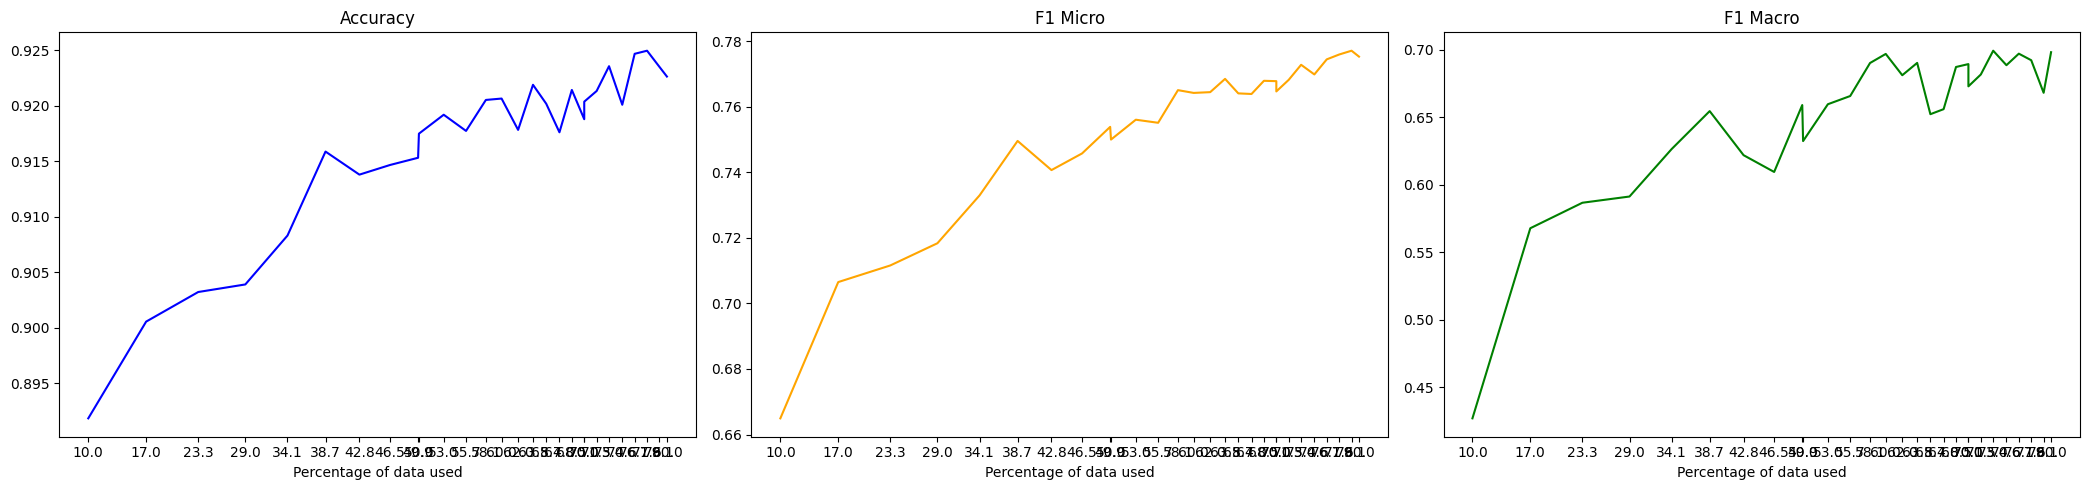

Result saved to results/hsd-coreset-init-10-1-results.csv


In [ ]:
initial_train_size = int(0.1 * total_data)
active_learning(50, 0, 'coreset', 10)

# RANDOM SAMPLING

Init Size: 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6814, Accuracy: 0.7312, F1 Micro: 0.2228, F1 Macro: 0.123
Epoch 2/10, Train Loss: 0.5938, Accuracy: 0.8056, F1 Micro: 0.1568, F1 Macro: 0.0557
Epoch 3/10, Train Loss: 0.5257, Accuracy: 0.8219, F1 Micro: 0.0493, F1 Macro: 0.0222
Epoch 4/10, Train Loss: 0.4783, Accuracy: 0.8273, F1 Micro: 0.0025, F1 Macro: 0.0014
Epoch 5/10, Train Loss: 0.4275, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 6/10, Train Loss: 0.3998, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 7/10, Train Loss: 0.3716, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 8/10, Train Loss: 0.3814, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 9/10, Train Loss: 0.4033, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 10/10, Train Loss: 0.3566, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Iteration 131: Accuracy: 0.7312, F1 Micro: 0.2228, F1 Macro: 0.123
               precision    recall  f1-score   support

           HS       0.38      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5622, Accuracy: 0.8291, F1 Micro: 0.0619, F1 Macro: 0.0208
Epoch 2/10, Train Loss: 0.409, Accuracy: 0.8293, F1 Micro: 0.0196, F1 Macro: 0.0078
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3845, Accuracy: 0.8365, F1 Micro: 0.1094, F1 Macro: 0.0436
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3618, Accuracy: 0.8575, F1 Micro: 0.414, F1 Macro: 0.1419
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3507, Accuracy: 0.8729, F1 Micro: 0.5667, F1 Macro: 0.2579
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3095, Accuracy: 0.8793, F1 Micro: 0.5917, F1 Macro: 0.2971
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2915, Accuracy: 0.8828, F1 Micro: 0.6024, F1 Macro: 0.3135
Epoch 8/10, Train Loss: 0.2501, Accuracy: 0.8827, F1 Micro: 0.5751, F1 Macro: 0.3121
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.228, Accuracy: 0.8871, F1 Micro: 0.6162, F1 Macro: 0.3771
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5093, Accuracy: 0.8364, F1 Micro: 0.1201, F1 Macro: 0.0424
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.394, Accuracy: 0.8442, F1 Micro: 0.2129, F1 Macro: 0.0766
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3499, Accuracy: 0.8779, F1 Micro: 0.5551, F1 Macro: 0.2617
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3007, Accuracy: 0.8848, F1 Micro: 0.6283, F1 Macro: 0.327
Epoch 5/10, Train Loss: 0.2671, Accuracy: 0.8895, F1 Micro: 0.6142, F1 Macro: 0.3691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2331, Accuracy: 0.8953, F1 Micro: 0.6582, F1 Macro: 0.402
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2079, Accuracy: 0.8976, F1 Micro: 0.6767, F1 Macro: 0.4601
Epoch 8/10, Train Loss: 0.1812, Accuracy: 0.8987, F1 Micro: 0.6672, F1 Macro: 0.4837
Epoch 9/10, Train Loss: 0.1605, Accuracy: 0.8992, F1 Micro: 0.6743, F1 Macro: 0.4973
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4794, Accuracy: 0.8376, F1 Micro: 0.1296, F1 Macro: 0.0497
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3711, Accuracy: 0.8643, F1 Micro: 0.4106, F1 Macro: 0.163
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3034, Accuracy: 0.887, F1 Micro: 0.6318, F1 Macro: 0.3271
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2628, Accuracy: 0.8943, F1 Micro: 0.6651, F1 Macro: 0.4309
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2296, Accuracy: 0.8983, F1 Micro: 0.6879, F1 Macro: 0.4579
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2009, Accuracy: 0.8987, F1 Micro: 0.6958, F1 Macro: 0.4887
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1705, Accuracy: 0.8998, F1 Micro: 0.7063, F1 Macro: 0.5172
Epoch 8/10, Train Loss: 0.1482, Accuracy: 0.9017, F1 Micro: 0.6994, F1 Macro: 0.5294
Epoch 9/10, Train Loss: 0.1248, Accuracy: 0.8998, F1 Micro: 0.7035, F1 Macro: 0.5379
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4622, Accuracy: 0.8409, F1 Micro: 0.1736, F1 Macro: 0.0635
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3527, Accuracy: 0.8784, F1 Micro: 0.6119, F1 Macro: 0.3032
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2853, Accuracy: 0.8913, F1 Micro: 0.6438, F1 Macro: 0.3758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2463, Accuracy: 0.8961, F1 Micro: 0.6503, F1 Macro: 0.4086
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2055, Accuracy: 0.8999, F1 Micro: 0.6875, F1 Macro: 0.5047
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1829, Accuracy: 0.9013, F1 Micro: 0.6891, F1 Macro: 0.4856
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1569, Accuracy: 0.9032, F1 Micro: 0.7153, F1 Macro: 0.5405
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1323, Accuracy: 0.8997, F1 Micro: 0.7172, F1 Macro: 0.5347
Epoch 9/10, Train Loss: 0.1192, Accuracy: 0.9035, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4467, Accuracy: 0.8481, F1 Micro: 0.2633, F1 Macro: 0.0895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.332, Accuracy: 0.8837, F1 Micro: 0.6201, F1 Macro: 0.3038
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2628, Accuracy: 0.8968, F1 Micro: 0.6694, F1 Macro: 0.4268
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2182, Accuracy: 0.896, F1 Micro: 0.7021, F1 Macro: 0.5259
Epoch 5/10, Train Loss: 0.1919, Accuracy: 0.9049, F1 Micro: 0.6984, F1 Macro: 0.5214
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1639, Accuracy: 0.9059, F1 Micro: 0.7209, F1 Macro: 0.5345
Epoch 7/10, Train Loss: 0.1396, Accuracy: 0.9011, F1 Micro: 0.7079, F1 Macro: 0.5537
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1241, Accuracy: 0.906, F1 Micro: 0.7293, F1 Macro: 0.5812
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1042, Accuracy: 0.9066, F1 Micro: 0.7327, F1 Macro: 0.576
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4369, Accuracy: 0.8546, F1 Micro: 0.3606, F1 Macro: 0.1172
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3182, Accuracy: 0.8883, F1 Micro: 0.6342, F1 Macro: 0.3416
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2513, Accuracy: 0.8978, F1 Micro: 0.6873, F1 Macro: 0.4508
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2096, Accuracy: 0.9014, F1 Micro: 0.7161, F1 Macro: 0.5105
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1833, Accuracy: 0.908, F1 Micro: 0.7294, F1 Macro: 0.5324
Epoch 6/10, Train Loss: 0.1566, Accuracy: 0.9104, F1 Micro: 0.7256, F1 Macro: 0.5539
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1343, Accuracy: 0.9106, F1 Micro: 0.7307, F1 Macro: 0.5582
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.112, Accuracy: 0.9084, F1 Micro: 0.7362, F1 Macro: 0.5866
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.096, Accuracy: 0.9115, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4312, Accuracy: 0.8577, F1 Micro: 0.3693, F1 Macro: 0.1416
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3104, Accuracy: 0.8881, F1 Micro: 0.5999, F1 Macro: 0.3247
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.246, Accuracy: 0.899, F1 Micro: 0.6748, F1 Macro: 0.4943
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2137, Accuracy: 0.9029, F1 Micro: 0.7149, F1 Macro: 0.5071
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1777, Accuracy: 0.9081, F1 Micro: 0.7227, F1 Macro: 0.5521
Epoch 6/10, Train Loss: 0.153, Accuracy: 0.9129, F1 Micro: 0.7225, F1 Macro: 0.5547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1243, Accuracy: 0.9131, F1 Micro: 0.7378, F1 Macro: 0.5789
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.111, Accuracy: 0.9151, F1 Micro: 0.7409, F1 Macro: 0.6
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0951, Accuracy: 0.9132, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4225, Accuracy: 0.8708, F1 Micro: 0.5359, F1 Macro: 0.2317
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.294, Accuracy: 0.8941, F1 Micro: 0.6707, F1 Macro: 0.4162
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2398, Accuracy: 0.902, F1 Micro: 0.7059, F1 Macro: 0.4921
Epoch 4/10, Train Loss: 0.1995, Accuracy: 0.9058, F1 Micro: 0.6994, F1 Macro: 0.4939
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1691, Accuracy: 0.9118, F1 Micro: 0.7196, F1 Macro: 0.5488
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1401, Accuracy: 0.9133, F1 Micro: 0.7368, F1 Macro: 0.5675
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1223, Accuracy: 0.9141, F1 Micro: 0.7418, F1 Macro: 0.5929
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1038, Accuracy: 0.9158, F1 Micro: 0.7495, F1 Macro: 0.6085
Epoch 9/10, Train Loss: 0.0849, Accuracy: 0.9158, F1 Micro: 0.7374, F1 Macro: 0.5984
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4171, Accuracy: 0.8748, F1 Micro: 0.5497, F1 Macro: 0.2486
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2885, Accuracy: 0.8941, F1 Micro: 0.6813, F1 Macro: 0.4625
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2316, Accuracy: 0.9052, F1 Micro: 0.699, F1 Macro: 0.504
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1945, Accuracy: 0.9096, F1 Micro: 0.7269, F1 Macro: 0.5491
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1624, Accuracy: 0.9126, F1 Micro: 0.7385, F1 Macro: 0.5608
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1412, Accuracy: 0.9124, F1 Micro: 0.7415, F1 Macro: 0.5718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1148, Accuracy: 0.9127, F1 Micro: 0.7419, F1 Macro: 0.5966
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1014, Accuracy: 0.916, F1 Micro: 0.7438, F1 Macro: 0.6054
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4156, Accuracy: 0.8761, F1 Micro: 0.5622, F1 Macro: 0.2579
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.285, Accuracy: 0.8943, F1 Micro: 0.6508, F1 Macro: 0.3716
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.233, Accuracy: 0.9053, F1 Micro: 0.6988, F1 Macro: 0.5078
Epoch 4/10, Train Loss: 0.1981, Accuracy: 0.9081, F1 Micro: 0.6885, F1 Macro: 0.5125
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1617, Accuracy: 0.9129, F1 Micro: 0.7276, F1 Macro: 0.5655
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1403, Accuracy: 0.9115, F1 Micro: 0.7408, F1 Macro: 0.5753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1179, Accuracy: 0.911, F1 Micro: 0.7449, F1 Macro: 0.5957
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1012, Accuracy: 0.914, F1 Micro: 0.751, F1 Macro: 0.6239
Epoch 9/10, Train Loss: 0.0866, Accuracy: 0.916, F1 Micro: 0.7498, F1 Macro: 0.6341
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.413, Accuracy: 0.8776, F1 Micro: 0.5658, F1 Macro: 0.2624
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2794, Accuracy: 0.8972, F1 Micro: 0.6698, F1 Macro: 0.4133
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2266, Accuracy: 0.905, F1 Micro: 0.7066, F1 Macro: 0.4883
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9093, F1 Micro: 0.722, F1 Macro: 0.5189
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1594, Accuracy: 0.9062, F1 Micro: 0.7426, F1 Macro: 0.5891
Epoch 6/10, Train Loss: 0.1383, Accuracy: 0.9122, F1 Micro: 0.7305, F1 Macro: 0.5558
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1135, Accuracy: 0.9133, F1 Micro: 0.7507, F1 Macro: 0.6058
Epoch 8/10, Train Loss: 0.0973, Accuracy: 0.9133, F1 Micro: 0.7433, F1 Macro: 0.6328
Epoch 9/10, Train Loss: 0.0818, Accuracy: 0.9181, F1 Micro: 0.7373, F1 Macro: 0.622
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4043, Accuracy: 0.8773, F1 Micro: 0.6044, F1 Macro: 0.294
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2774, Accuracy: 0.8992, F1 Micro: 0.6657, F1 Macro: 0.4449
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2195, Accuracy: 0.906, F1 Micro: 0.7232, F1 Macro: 0.5418
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.9118, F1 Micro: 0.7401, F1 Macro: 0.5747
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1561, Accuracy: 0.9178, F1 Micro: 0.7497, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9179, F1 Micro: 0.7509, F1 Macro: 0.6053
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1092, Accuracy: 0.9137, F1 Micro: 0.7584, F1 Macro: 0.6406
Epoch 8/10, Train Loss: 0.0981, Accuracy: 0.9136, F1 Micro: 0.7521, F1 Macro: 0.6223
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9208, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4014, Accuracy: 0.8785, F1 Micro: 0.6136, F1 Macro: 0.287
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2695, Accuracy: 0.899, F1 Micro: 0.6736, F1 Macro: 0.4294
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2201, Accuracy: 0.908, F1 Micro: 0.6992, F1 Macro: 0.5273
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1841, Accuracy: 0.911, F1 Micro: 0.7252, F1 Macro: 0.569
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1546, Accuracy: 0.9152, F1 Micro: 0.7411, F1 Macro: 0.5781
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.129, Accuracy: 0.9139, F1 Micro: 0.7492, F1 Macro: 0.5865
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.111, Accuracy: 0.9201, F1 Micro: 0.7549, F1 Macro: 0.6328
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.9194, F1 Micro: 0.7619, F1 Macro: 0.6479
Epoch 9/10, Train Loss: 0.085, Accuracy: 0.9199, F1 Micro: 0.75

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3998, Accuracy: 0.8815, F1 Micro: 0.5988, F1 Macro: 0.2822
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2769, Accuracy: 0.8994, F1 Micro: 0.6672, F1 Macro: 0.4125
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.217, Accuracy: 0.9057, F1 Micro: 0.7296, F1 Macro: 0.5332
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9156, F1 Micro: 0.7462, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9158, F1 Micro: 0.748, F1 Macro: 0.595
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1272, Accuracy: 0.918, F1 Micro: 0.7597, F1 Macro: 0.6235
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1079, Accuracy: 0.9176, F1 Micro: 0.7609, F1 Macro: 0.6259
Epoch 8/10, Train Loss: 0.0929, Accuracy: 0.9198, F1 Micro: 0.7497, F1 Macro: 0.6167
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0819, Accuracy: 0.9173, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4012, Accuracy: 0.8816, F1 Micro: 0.5939, F1 Macro: 0.287
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2682, Accuracy: 0.9013, F1 Micro: 0.6889, F1 Macro: 0.4934
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2227, Accuracy: 0.9086, F1 Micro: 0.7154, F1 Macro: 0.5141
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1869, Accuracy: 0.9134, F1 Micro: 0.7383, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1529, Accuracy: 0.9156, F1 Micro: 0.745, F1 Macro: 0.5885
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9181, F1 Micro: 0.7517, F1 Macro: 0.6298
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1103, Accuracy: 0.9181, F1 Micro: 0.7561, F1 Macro: 0.6227
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0925, Accuracy: 0.9194, F1 Micro: 0.7645, F1 Macro: 0.6489
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.9173, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3937, Accuracy: 0.8831, F1 Micro: 0.6143, F1 Macro: 0.2952
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.9004, F1 Micro: 0.6722, F1 Macro: 0.4848
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.215, Accuracy: 0.9111, F1 Micro: 0.723, F1 Macro: 0.5379
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1766, Accuracy: 0.9139, F1 Micro: 0.7355, F1 Macro: 0.5812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.9184, F1 Micro: 0.7426, F1 Macro: 0.5795
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.125, Accuracy: 0.9182, F1 Micro: 0.755, F1 Macro: 0.6163
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1026, Accuracy: 0.9199, F1 Micro: 0.7626, F1 Macro: 0.6499
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.9172, F1 Micro: 0.7639, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3953, Accuracy: 0.8821, F1 Micro: 0.5712, F1 Macro: 0.2654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2646, Accuracy: 0.9025, F1 Micro: 0.6858, F1 Macro: 0.4724
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2152, Accuracy: 0.9105, F1 Micro: 0.7122, F1 Macro: 0.5374
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9118, F1 Micro: 0.7492, F1 Macro: 0.5777
Epoch 5/10, Train Loss: 0.1532, Accuracy: 0.9183, F1 Micro: 0.7421, F1 Macro: 0.6023
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1251, Accuracy: 0.92, F1 Micro: 0.7628, F1 Macro: 0.6345
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1087, Accuracy: 0.9201, F1 Micro: 0.7629, F1 Macro: 0.6473
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0884, Accuracy: 0.9209, F1 Micro: 0.7675, F1 Macro: 0.6661
Epoch 9/10, Train Loss: 0.0793, Accuracy: 0.9204, F1 Micro: 0.7614, F1 Macro: 0.6549
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3922, Accuracy: 0.8811, F1 Micro: 0.6023, F1 Macro: 0.2974
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2649, Accuracy: 0.8995, F1 Micro: 0.6592, F1 Macro: 0.4152
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2136, Accuracy: 0.9111, F1 Micro: 0.7088, F1 Macro: 0.5297
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1788, Accuracy: 0.9165, F1 Micro: 0.7517, F1 Macro: 0.5823
Epoch 5/10, Train Loss: 0.1515, Accuracy: 0.9185, F1 Micro: 0.7509, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1231, Accuracy: 0.9219, F1 Micro: 0.764, F1 Macro: 0.6406
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.9204, F1 Micro: 0.7595, F1 Macro: 0.6413
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0921, Accuracy: 0.9194, F1 Micro: 0.768, F1 Macro: 0.6351
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9206, F1 Micro: 0.7665, F1 Macro: 0.6466
Epoch 10/10, Train Loss: 0.0673, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3886, Accuracy: 0.8757, F1 Micro: 0.5082, F1 Macro: 0.238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2619, Accuracy: 0.9043, F1 Micro: 0.6911, F1 Macro: 0.4952
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2154, Accuracy: 0.9121, F1 Micro: 0.73, F1 Macro: 0.5495
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.916, F1 Micro: 0.7535, F1 Macro: 0.5882
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9195, F1 Micro: 0.748, F1 Macro: 0.6013
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1277, Accuracy: 0.9211, F1 Micro: 0.7665, F1 Macro: 0.6432
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.921, F1 Micro: 0.772, F1 Macro: 0.683
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9223, F1 Micro: 0.7705, F1 Macro: 0.6899
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.923, F1 Micro: 0.7723, F1 Macro: 0.6745
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3853, Accuracy: 0.8831, F1 Micro: 0.5813, F1 Macro: 0.276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.255, Accuracy: 0.9059, F1 Micro: 0.7096, F1 Macro: 0.5116
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2141, Accuracy: 0.9141, F1 Micro: 0.7176, F1 Macro: 0.5364
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1776, Accuracy: 0.917, F1 Micro: 0.7564, F1 Macro: 0.6081
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.9203, F1 Micro: 0.7636, F1 Macro: 0.6357
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1236, Accuracy: 0.9178, F1 Micro: 0.7636, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.9194, F1 Micro: 0.7726, F1 Macro: 0.6768
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9221, F1 Micro: 0.7696, F1 Macro: 0.6773
Epoch 9/10, Train Loss: 0.0795, Accuracy: 0.9228, F1 Micro: 0.7724, F1 Macro: 0.6947
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3836, Accuracy: 0.885, F1 Micro: 0.6096, F1 Macro: 0.2988
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.255, Accuracy: 0.9046, F1 Micro: 0.6892, F1 Macro: 0.5079
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2102, Accuracy: 0.9106, F1 Micro: 0.7412, F1 Macro: 0.5759
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1743, Accuracy: 0.9171, F1 Micro: 0.7543, F1 Macro: 0.598
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9211, F1 Micro: 0.7696, F1 Macro: 0.6435
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9169, F1 Micro: 0.7604, F1 Macro: 0.6436
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1075, Accuracy: 0.9224, F1 Micro: 0.775, F1 Macro: 0.6827
Epoch 8/10, Train Loss: 0.0859, Accuracy: 0.9242, F1 Micro: 0.7719, F1 Macro: 0.6734
Epoch 9/10, Train Loss: 0.0742, Accuracy: 0.9203, F1 Micro: 0.7717, F1 Macro: 0.6755
Epoch 10/10, Train Loss: 0.0663, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3865, Accuracy: 0.8854, F1 Micro: 0.6063, F1 Macro: 0.2944
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2599, Accuracy: 0.9045, F1 Micro: 0.6933, F1 Macro: 0.4732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2081, Accuracy: 0.9137, F1 Micro: 0.7379, F1 Macro: 0.5758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.918, F1 Micro: 0.7536, F1 Macro: 0.6135
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1452, Accuracy: 0.9201, F1 Micro: 0.758, F1 Macro: 0.6161
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1225, Accuracy: 0.9213, F1 Micro: 0.7619, F1 Macro: 0.6466
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.921, F1 Micro: 0.7699, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.0845, Accuracy: 0.9196, F1 Micro: 0.7645, F1 Macro: 0.6629
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9208, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3826, Accuracy: 0.8867, F1 Micro: 0.6203, F1 Macro: 0.3085
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2549, Accuracy: 0.9064, F1 Micro: 0.7112, F1 Macro: 0.5145
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2074, Accuracy: 0.9142, F1 Micro: 0.7456, F1 Macro: 0.586
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.9198, F1 Micro: 0.7528, F1 Macro: 0.6016
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1418, Accuracy: 0.9217, F1 Micro: 0.761, F1 Macro: 0.6441
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9247, F1 Micro: 0.7739, F1 Macro: 0.6829
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.099, Accuracy: 0.9226, F1 Micro: 0.7756, F1 Macro: 0.6925
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9218, F1 Micro: 0.7676, F1 Macro: 0.6839
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9222, F1 Micro: 0.7735, F1 Macro: 0.698
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3793, Accuracy: 0.8874, F1 Micro: 0.6185, F1 Macro: 0.3091
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2536, Accuracy: 0.9026, F1 Micro: 0.7204, F1 Macro: 0.5158
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2073, Accuracy: 0.9129, F1 Micro: 0.7216, F1 Macro: 0.5203
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.916, F1 Micro: 0.7581, F1 Macro: 0.6099
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9224, F1 Micro: 0.7642, F1 Macro: 0.6338
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.922, F1 Micro: 0.7617, F1 Macro: 0.6381
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.9171, F1 Micro: 0.7648, F1 Macro: 0.6753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.9231, F1 Micro: 0.7744, F1 Macro: 0.6819
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9244, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3779, Accuracy: 0.8858, F1 Micro: 0.5968, F1 Macro: 0.295
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2539, Accuracy: 0.9046, F1 Micro: 0.717, F1 Macro: 0.5404
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2058, Accuracy: 0.9145, F1 Micro: 0.7367, F1 Macro: 0.5822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9202, F1 Micro: 0.7624, F1 Macro: 0.6253
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.9215, F1 Micro: 0.7653, F1 Macro: 0.6176
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1185, Accuracy: 0.9216, F1 Micro: 0.7685, F1 Macro: 0.6553
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.9198, F1 Micro: 0.7608, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9242, F1 Micro: 0.7744, F1 Macro: 0.6757
Epoch 9/10, Train Loss: 0.0734, Accuracy: 0.9218, F1 Micro: 0.7727, F1 Macro: 0.6739
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3809, Accuracy: 0.8855, F1 Micro: 0.6277, F1 Macro: 0.3226
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.9028, F1 Micro: 0.721, F1 Macro: 0.5227
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9151, F1 Micro: 0.7432, F1 Macro: 0.5753
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.9186, F1 Micro: 0.749, F1 Macro: 0.5605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9226, F1 Micro: 0.7569, F1 Macro: 0.6208
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.9215, F1 Micro: 0.7747, F1 Macro: 0.6633
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.9239, F1 Micro: 0.7764, F1 Macro: 0.6696
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9267, F1 Micro: 0.775, F1 Macro: 0.6851
Epoch 9/10, Train Loss: 0.0747, Accuracy: 0.9251, F1 Micro: 0.7666, F1 Macro: 0.6806
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.8879, F1 Micro: 0.6, F1 Macro: 0.3018
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2488, Accuracy: 0.9046, F1 Micro: 0.7165, F1 Macro: 0.5065
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.9158, F1 Micro: 0.7348, F1 Macro: 0.5328
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1687, Accuracy: 0.9189, F1 Micro: 0.7585, F1 Macro: 0.6198
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.9221, F1 Micro: 0.7689, F1 Macro: 0.6449
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1163, Accuracy: 0.9237, F1 Micro: 0.7735, F1 Macro: 0.6757
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9244, F1 Micro: 0.7723, F1 Macro: 0.6805
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9219, F1 Micro: 0.7732, F1 Macro: 0.6839
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9212, F1 Micro: 0.7758, F1 Macro: 0.7011
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3762, Accuracy: 0.8864, F1 Micro: 0.6079, F1 Macro: 0.2976
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2441, Accuracy: 0.9088, F1 Micro: 0.7092, F1 Macro: 0.5217
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2048, Accuracy: 0.916, F1 Micro: 0.7473, F1 Macro: 0.5975
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9203, F1 Micro: 0.7657, F1 Macro: 0.6167
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.9248, F1 Micro: 0.7706, F1 Macro: 0.6653
Epoch 6/10, Train Loss: 0.1207, Accuracy: 0.921, F1 Micro: 0.7662, F1 Macro: 0.6594
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9259, F1 Micro: 0.7789, F1 Macro: 0.6687
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9258, F1 Micro: 0.773, F1 Macro: 0.6998
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9249, F1 Micro: 0.7693, F1 Macro: 0.6846
Epoch 10/10, Train Loss: 0.0624, Accurac

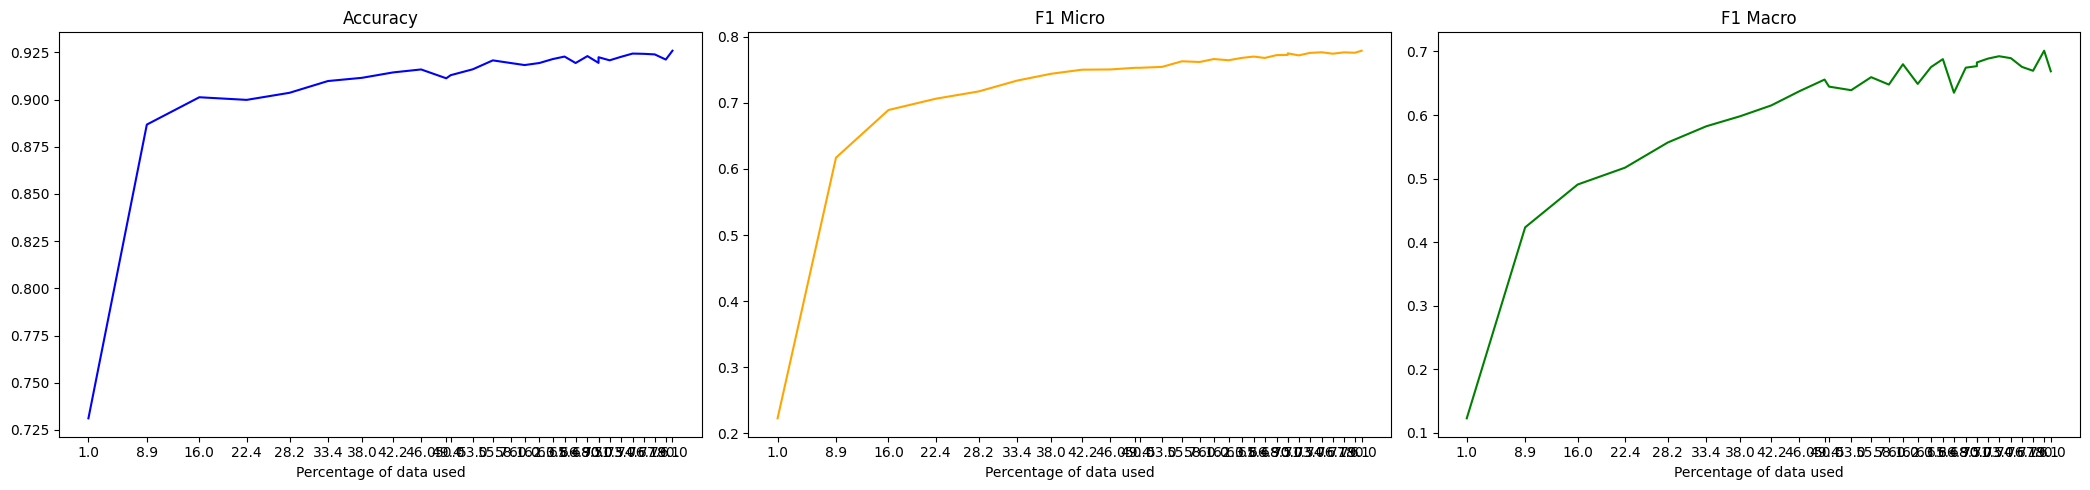

Result saved to results/hsd-random-init-1-1-results.csv


In [34]:
initial_train_size = int(0.01 * total_data)
active_learning(50, 0, 'random', 1)

Init Size: 10
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5474, Accuracy: 0.8279, F1 Micro: 0.0032, F1 Macro: 0.0013
Epoch 2/10, Train Loss: 0.4068, Accuracy: 0.8279, F1 Micro: 0.0018, F1 Macro: 0.0008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3684, Accuracy: 0.8403, F1 Micro: 0.161, F1 Macro: 0.0593
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3529, Accuracy: 0.859, F1 Micro: 0.3835, F1 Macro: 0.1446
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3238, Accuracy: 0.8755, F1 Micro: 0.5261, F1 Macro: 0.2466
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2939, Accuracy: 0.8816, F1 Micro: 0.612, F1 Macro: 0.3107
Epoch 7/10, Train Loss: 0.2625, Accuracy: 0.8851, F1 Micro: 0.6102, F1 Macro: 0.3322
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.227, Accuracy: 0.887, F1 Micro: 0.6172, F1 Macro: 0.3778
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2146, Accuracy: 0.8885, F1 Micro: 0.6626, F1 Macro: 0.4638
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4972, Accuracy: 0.828, F1 Micro: 0.0032, F1 Macro: 0.0015
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3855, Accuracy: 0.8503, F1 Micro: 0.2984, F1 Macro: 0.0993
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3424, Accuracy: 0.8776, F1 Micro: 0.5818, F1 Macro: 0.2701
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2951, Accuracy: 0.8824, F1 Micro: 0.5869, F1 Macro: 0.2945
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2623, Accuracy: 0.8906, F1 Micro: 0.6524, F1 Macro: 0.4042
Epoch 6/10, Train Loss: 0.2314, Accuracy: 0.8951, F1 Micro: 0.6503, F1 Macro: 0.4136
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.204, Accuracy: 0.8974, F1 Micro: 0.6813, F1 Macro: 0.4733
Epoch 8/10, Train Loss: 0.1813, Accuracy: 0.9005, F1 Micro: 0.681, F1 Macro: 0.509
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1631, Accuracy: 0.9015, F1 Micro: 0.6979, F1 Macro: 0.5326
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4788, Accuracy: 0.8312, F1 Micro: 0.0452, F1 Macro: 0.0189
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3645, Accuracy: 0.8696, F1 Micro: 0.4836, F1 Macro: 0.2029
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.303, Accuracy: 0.8806, F1 Micro: 0.555, F1 Macro: 0.2721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2611, Accuracy: 0.8921, F1 Micro: 0.651, F1 Macro: 0.3997
Epoch 5/10, Train Loss: 0.2267, Accuracy: 0.8935, F1 Micro: 0.6227, F1 Macro: 0.4077
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2109, Accuracy: 0.9014, F1 Micro: 0.6943, F1 Macro: 0.514
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1767, Accuracy: 0.9022, F1 Micro: 0.7016, F1 Macro: 0.4814
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1572, Accuracy: 0.9045, F1 Micro: 0.7116, F1 Macro: 0.5153
Epoch 9/10, Train Loss: 0.1367, Accuracy: 0.9052, F1 Micro: 0.7019, F1 Macro: 0.52
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4572, Accuracy: 0.8411, F1 Micro: 0.1686, F1 Macro: 0.062
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.347, Accuracy: 0.8792, F1 Micro: 0.5647, F1 Macro: 0.2706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2849, Accuracy: 0.8879, F1 Micro: 0.6637, F1 Macro: 0.4003
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2487, Accuracy: 0.896, F1 Micro: 0.6898, F1 Macro: 0.4509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2058, Accuracy: 0.9016, F1 Micro: 0.6978, F1 Macro: 0.5221
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1868, Accuracy: 0.9057, F1 Micro: 0.7137, F1 Macro: 0.5241
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1573, Accuracy: 0.9063, F1 Micro: 0.7192, F1 Macro: 0.5391
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1413, Accuracy: 0.9076, F1 Micro: 0.7274, F1 Macro: 0.5763
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4441, Accuracy: 0.8405, F1 Micro: 0.1641, F1 Macro: 0.0613
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3323, Accuracy: 0.8837, F1 Micro: 0.5946, F1 Macro: 0.2932
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2593, Accuracy: 0.8968, F1 Micro: 0.6707, F1 Macro: 0.4197
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2299, Accuracy: 0.9037, F1 Micro: 0.6963, F1 Macro: 0.505
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1977, Accuracy: 0.9049, F1 Micro: 0.7247, F1 Macro: 0.5516
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1625, Accuracy: 0.9087, F1 Micro: 0.7249, F1 Macro: 0.5487
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1429, Accuracy: 0.9104, F1 Micro: 0.7379, F1 Macro: 0.5867
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1202, Accuracy: 0.9147, F1 Micro: 0.7388, F1 Macro: 0.5967
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.433, Accuracy: 0.8524, F1 Micro: 0.3249, F1 Macro: 0.106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3199, Accuracy: 0.8861, F1 Micro: 0.5946, F1 Macro: 0.3014
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2557, Accuracy: 0.8974, F1 Micro: 0.6733, F1 Macro: 0.4451
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2163, Accuracy: 0.9062, F1 Micro: 0.7113, F1 Macro: 0.5144
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1786, Accuracy: 0.9078, F1 Micro: 0.723, F1 Macro: 0.5481
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1558, Accuracy: 0.9113, F1 Micro: 0.7362, F1 Macro: 0.5767
Epoch 7/10, Train Loss: 0.1321, Accuracy: 0.9124, F1 Micro: 0.7323, F1 Macro: 0.5832
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1129, Accuracy: 0.9117, F1 Micro: 0.7454, F1 Macro: 0.6081
Epoch 9/10, Train Loss: 0.0939, Accuracy: 0.9135, F1 Micro: 0.7258, F1 Macro: 0.598
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.425, Accuracy: 0.8622, F1 Micro: 0.4212, F1 Macro: 0.1586
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3054, Accuracy: 0.8915, F1 Micro: 0.662, F1 Macro: 0.3916
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2399, Accuracy: 0.9028, F1 Micro: 0.6894, F1 Macro: 0.4781
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.201, Accuracy: 0.9076, F1 Micro: 0.7059, F1 Macro: 0.5395
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1781, Accuracy: 0.9062, F1 Micro: 0.7366, F1 Macro: 0.5472
Epoch 6/10, Train Loss: 0.1419, Accuracy: 0.9124, F1 Micro: 0.7343, F1 Macro: 0.5656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1244, Accuracy: 0.9147, F1 Micro: 0.7473, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.105, Accuracy: 0.9169, F1 Micro: 0.7517, F1 Macro: 0.6414
Epoch 9/10, Train Loss: 0.0921, Accuracy: 0.9154, F1 Micro: 0.7489, F1 Macro: 0.6459
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4245, Accuracy: 0.8605, F1 Micro: 0.3737, F1 Macro: 0.1414
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3035, Accuracy: 0.8942, F1 Micro: 0.6583, F1 Macro: 0.4251
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2404, Accuracy: 0.9002, F1 Micro: 0.7106, F1 Macro: 0.5143
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2006, Accuracy: 0.9067, F1 Micro: 0.722, F1 Macro: 0.5474
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1756, Accuracy: 0.9094, F1 Micro: 0.7336, F1 Macro: 0.5834
Epoch 6/10, Train Loss: 0.149, Accuracy: 0.9135, F1 Micro: 0.7299, F1 Macro: 0.5718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.123, Accuracy: 0.9155, F1 Micro: 0.743, F1 Macro: 0.6098
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1075, Accuracy: 0.9163, F1 Micro: 0.7484, F1 Macro: 0.6114
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0865, Accuracy: 0.9168, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4172, Accuracy: 0.8734, F1 Micro: 0.5008, F1 Macro: 0.2195
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2912, Accuracy: 0.8928, F1 Micro: 0.6155, F1 Macro: 0.376
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2321, Accuracy: 0.9041, F1 Micro: 0.71, F1 Macro: 0.4992
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1988, Accuracy: 0.9117, F1 Micro: 0.7124, F1 Macro: 0.5399
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.166, Accuracy: 0.9154, F1 Micro: 0.7445, F1 Macro: 0.5852
Epoch 6/10, Train Loss: 0.1408, Accuracy: 0.9158, F1 Micro: 0.742, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.117, Accuracy: 0.9163, F1 Micro: 0.7576, F1 Macro: 0.6389
Epoch 8/10, Train Loss: 0.1039, Accuracy: 0.9171, F1 Micro: 0.7556, F1 Macro: 0.623
Epoch 9/10, Train Loss: 0.0846, Accuracy: 0.9169, F1 Micro: 0.7464, F1 Macro: 0.6481
Epoch 10/10, Train Loss: 0.0759, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4125, Accuracy: 0.8653, F1 Micro: 0.4076, F1 Macro: 0.1704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2907, Accuracy: 0.8952, F1 Micro: 0.6718, F1 Macro: 0.4555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2353, Accuracy: 0.9051, F1 Micro: 0.7087, F1 Macro: 0.5156
Epoch 4/10, Train Loss: 0.1945, Accuracy: 0.9085, F1 Micro: 0.6936, F1 Macro: 0.5255
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1636, Accuracy: 0.9109, F1 Micro: 0.7421, F1 Macro: 0.5667
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1432, Accuracy: 0.9153, F1 Micro: 0.7532, F1 Macro: 0.6156
Epoch 7/10, Train Loss: 0.1194, Accuracy: 0.9163, F1 Micro: 0.7495, F1 Macro: 0.6333
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1017, Accuracy: 0.9172, F1 Micro: 0.7541, F1 Macro: 0.6493
Epoch 9/10, Train Loss: 0.0868, Accuracy: 0.9169, F1 Micro: 0.7379, F1 Macro: 0.6402
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4112, Accuracy: 0.8755, F1 Micro: 0.6028, F1 Macro: 0.2864
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2848, Accuracy: 0.8971, F1 Micro: 0.6484, F1 Macro: 0.3942
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2322, Accuracy: 0.904, F1 Micro: 0.7203, F1 Macro: 0.5475
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1918, Accuracy: 0.912, F1 Micro: 0.7353, F1 Macro: 0.5781
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1617, Accuracy: 0.9163, F1 Micro: 0.7387, F1 Macro: 0.5772
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9154, F1 Micro: 0.7379, F1 Macro: 0.6139
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1102, Accuracy: 0.9182, F1 Micro: 0.7449, F1 Macro: 0.6233
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1012, Accuracy: 0.9182, F1 Micro: 0.7575, F1 Macro: 0.6354
Epoch 9/10, Train Loss: 0.0836, Accuracy: 0.9159, F1 Micro: 0.7562, F1 Macro: 0.6382
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4072, Accuracy: 0.8756, F1 Micro: 0.5123, F1 Macro: 0.2386
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2789, Accuracy: 0.8968, F1 Micro: 0.6919, F1 Macro: 0.4794
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2263, Accuracy: 0.9065, F1 Micro: 0.7104, F1 Macro: 0.5419
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1877, Accuracy: 0.9129, F1 Micro: 0.7396, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1635, Accuracy: 0.9125, F1 Micro: 0.7478, F1 Macro: 0.5939
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.9175, F1 Micro: 0.7415, F1 Macro: 0.6004
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1126, Accuracy: 0.917, F1 Micro: 0.7637, F1 Macro: 0.6452
Epoch 8/10, Train Loss: 0.0969, Accuracy: 0.919, F1 Micro: 0.7616, F1 Macro: 0.6539
Epoch 9/10, Train Loss: 0.0832, Accuracy: 0.9179, F1 Micro: 0.7635, F1 Macro: 0.6692
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4014, Accuracy: 0.8792, F1 Micro: 0.56, F1 Macro: 0.2647
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2741, Accuracy: 0.899, F1 Micro: 0.6896, F1 Macro: 0.4778
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2288, Accuracy: 0.907, F1 Micro: 0.7201, F1 Macro: 0.5206
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1887, Accuracy: 0.9135, F1 Micro: 0.7354, F1 Macro: 0.5643
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.158, Accuracy: 0.9169, F1 Micro: 0.7486, F1 Macro: 0.6023
Epoch 6/10, Train Loss: 0.1343, Accuracy: 0.9164, F1 Micro: 0.7436, F1 Macro: 0.6361
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9184, F1 Micro: 0.7536, F1 Macro: 0.629
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.9214, F1 Micro: 0.7617, F1 Macro: 0.6692
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0844, Accuracy: 0.9198, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4006, Accuracy: 0.8813, F1 Micro: 0.584, F1 Macro: 0.2822
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2716, Accuracy: 0.9002, F1 Micro: 0.6888, F1 Macro: 0.4942
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2213, Accuracy: 0.9068, F1 Micro: 0.7304, F1 Macro: 0.5608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1869, Accuracy: 0.9129, F1 Micro: 0.7441, F1 Macro: 0.5806
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1633, Accuracy: 0.9164, F1 Micro: 0.751, F1 Macro: 0.6053
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9183, F1 Micro: 0.7427, F1 Macro: 0.6085
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9179, F1 Micro: 0.7597, F1 Macro: 0.6417
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9198, F1 Micro: 0.7689, F1 Macro: 0.6511
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9217, F1 Micro: 0.767, F1 Macro: 0.6698
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4028, Accuracy: 0.8812, F1 Micro: 0.5969, F1 Macro: 0.2823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2701, Accuracy: 0.9014, F1 Micro: 0.6918, F1 Macro: 0.4544
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2206, Accuracy: 0.9075, F1 Micro: 0.7279, F1 Macro: 0.5301
Epoch 4/10, Train Loss: 0.1815, Accuracy: 0.9141, F1 Micro: 0.7216, F1 Macro: 0.5435
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1566, Accuracy: 0.9171, F1 Micro: 0.7585, F1 Macro: 0.6354
Epoch 6/10, Train Loss: 0.1287, Accuracy: 0.9177, F1 Micro: 0.7358, F1 Macro: 0.6154
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.113, Accuracy: 0.919, F1 Micro: 0.7649, F1 Macro: 0.6705
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.9202, F1 Micro: 0.756, F1 Macro: 0.6574
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.9181, F1 Micro: 0.7672, F1 Macro: 0.6717
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3933, Accuracy: 0.8816, F1 Micro: 0.606, F1 Macro: 0.3028
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.271, Accuracy: 0.9029, F1 Micro: 0.6888, F1 Macro: 0.4654
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.9086, F1 Micro: 0.7352, F1 Macro: 0.5528
Epoch 4/10, Train Loss: 0.1877, Accuracy: 0.9162, F1 Micro: 0.7308, F1 Macro: 0.5761
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1535, Accuracy: 0.9193, F1 Micro: 0.7556, F1 Macro: 0.6088
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9192, F1 Micro: 0.7627, F1 Macro: 0.6323
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.921, F1 Micro: 0.7672, F1 Macro: 0.6761
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.087, Accuracy: 0.9212, F1 Micro: 0.7702, F1 Macro: 0.6824
Epoch 9/10, Train Loss: 0.0782, Accuracy: 0.9211, F1 Micro: 0.7669, F1 Macro: 0.6724
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3945, Accuracy: 0.8817, F1 Micro: 0.6022, F1 Macro: 0.2912
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2657, Accuracy: 0.903, F1 Micro: 0.7065, F1 Macro: 0.5075
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2139, Accuracy: 0.9089, F1 Micro: 0.7258, F1 Macro: 0.5647
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1833, Accuracy: 0.9191, F1 Micro: 0.7553, F1 Macro: 0.6074
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9202, F1 Micro: 0.7557, F1 Macro: 0.6286
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.129, Accuracy: 0.9204, F1 Micro: 0.7631, F1 Macro: 0.6581
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.105, Accuracy: 0.919, F1 Micro: 0.7644, F1 Macro: 0.6334
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9224, F1 Micro: 0.762, F1 Macro: 0.6707
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0741, Accuracy: 0.9214, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3887, Accuracy: 0.8826, F1 Micro: 0.5854, F1 Macro: 0.2821
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2631, Accuracy: 0.8992, F1 Micro: 0.7131, F1 Macro: 0.5368
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2159, Accuracy: 0.9122, F1 Micro: 0.7234, F1 Macro: 0.5622
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9167, F1 Micro: 0.7568, F1 Macro: 0.6003
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.914, F1 Micro: 0.7551, F1 Macro: 0.631
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.9197, F1 Micro: 0.7649, F1 Macro: 0.6705
Epoch 7/10, Train Loss: 0.1065, Accuracy: 0.9197, F1 Micro: 0.7567, F1 Macro: 0.648
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9227, F1 Micro: 0.7724, F1 Macro: 0.6755
Epoch 9/10, Train Loss: 0.0756, Accuracy: 0.921, F1 Micro: 0.7703, F1 Macro: 0.6864
Epoch 10/10, Train Loss: 0.0672, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3888, Accuracy: 0.882, F1 Micro: 0.6148, F1 Macro: 0.3045
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2647, Accuracy: 0.9016, F1 Micro: 0.6679, F1 Macro: 0.4292
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2086, Accuracy: 0.9088, F1 Micro: 0.7357, F1 Macro: 0.5644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1735, Accuracy: 0.9164, F1 Micro: 0.7506, F1 Macro: 0.6052
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1511, Accuracy: 0.9204, F1 Micro: 0.7622, F1 Macro: 0.6266
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1229, Accuracy: 0.9214, F1 Micro: 0.765, F1 Macro: 0.6577
Epoch 7/10, Train Loss: 0.1037, Accuracy: 0.9202, F1 Micro: 0.7632, F1 Macro: 0.6698
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0924, Accuracy: 0.9226, F1 Micro: 0.7676, F1 Macro: 0.6654
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.9219, F1 Micro: 0.7676, F1 Macro: 0.6818
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3885, Accuracy: 0.8845, F1 Micro: 0.6095, F1 Macro: 0.304
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2653, Accuracy: 0.904, F1 Micro: 0.7107, F1 Macro: 0.5133
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2133, Accuracy: 0.9124, F1 Micro: 0.7222, F1 Macro: 0.5475
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.9187, F1 Micro: 0.7497, F1 Macro: 0.6065
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.9217, F1 Micro: 0.7706, F1 Macro: 0.6368
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1235, Accuracy: 0.923, F1 Micro: 0.7746, F1 Macro: 0.673
Epoch 7/10, Train Loss: 0.1063, Accuracy: 0.9221, F1 Micro: 0.7695, F1 Macro: 0.6806
Epoch 8/10, Train Loss: 0.0884, Accuracy: 0.9223, F1 Micro: 0.7717, F1 Macro: 0.6682
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9212, F1 Micro: 0.7722, F1 Macro: 0.6896
Epoch 10/10, Train Loss: 0.0648, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3865, Accuracy: 0.8829, F1 Micro: 0.5818, F1 Macro: 0.2841
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.262, Accuracy: 0.9032, F1 Micro: 0.6943, F1 Macro: 0.5186
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2113, Accuracy: 0.9124, F1 Micro: 0.7192, F1 Macro: 0.5733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1778, Accuracy: 0.9177, F1 Micro: 0.7471, F1 Macro: 0.6084
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.9185, F1 Micro: 0.7608, F1 Macro: 0.6184
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1254, Accuracy: 0.9195, F1 Micro: 0.7668, F1 Macro: 0.6427
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1046, Accuracy: 0.9203, F1 Micro: 0.7741, F1 Macro: 0.6896
Epoch 8/10, Train Loss: 0.0871, Accuracy: 0.9227, F1 Micro: 0.7646, F1 Macro: 0.6783
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.921, F1 Micro: 0.7668, F1 Macro: 0.6887
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3866, Accuracy: 0.8836, F1 Micro: 0.5852, F1 Macro: 0.2916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2573, Accuracy: 0.9038, F1 Micro: 0.6891, F1 Macro: 0.4499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2098, Accuracy: 0.9117, F1 Micro: 0.7366, F1 Macro: 0.5378
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1765, Accuracy: 0.9199, F1 Micro: 0.7577, F1 Macro: 0.6023
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1465, Accuracy: 0.9166, F1 Micro: 0.7649, F1 Macro: 0.6328
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1251, Accuracy: 0.9211, F1 Micro: 0.7711, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1, Accuracy: 0.9236, F1 Micro: 0.7757, F1 Macro: 0.6862
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.9225, F1 Micro: 0.7736, F1 Macro: 0.6804
Epoch 9/10, Train Loss: 0.0747, Accuracy: 0.9209, F1 Micro: 0.7712, F1 Macro: 0.6986
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3822, Accuracy: 0.8848, F1 Micro: 0.6382, F1 Macro: 0.3176
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2544, Accuracy: 0.9056, F1 Micro: 0.713, F1 Macro: 0.5335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2096, Accuracy: 0.9149, F1 Micro: 0.7367, F1 Macro: 0.5648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1738, Accuracy: 0.9196, F1 Micro: 0.7663, F1 Macro: 0.6229
Epoch 5/10, Train Loss: 0.1467, Accuracy: 0.9187, F1 Micro: 0.7653, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.92, F1 Micro: 0.7714, F1 Macro: 0.6844
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9216, F1 Micro: 0.774, F1 Macro: 0.6887
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9224, F1 Micro: 0.7666, F1 Macro: 0.6841
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.9192, F1 Micro: 0.7673, F1 Macro: 0.6922
Epoch 10/10, Train Loss: 0.0632, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.38, Accuracy: 0.8848, F1 Micro: 0.638, F1 Macro: 0.3398
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2586, Accuracy: 0.9042, F1 Micro: 0.6704, F1 Macro: 0.4505
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2081, Accuracy: 0.916, F1 Micro: 0.735, F1 Macro: 0.552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9205, F1 Micro: 0.7653, F1 Macro: 0.6174
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9236, F1 Micro: 0.777, F1 Macro: 0.6738
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9252, F1 Micro: 0.7733, F1 Macro: 0.6744
Epoch 7/10, Train Loss: 0.1009, Accuracy: 0.9234, F1 Micro: 0.7732, F1 Macro: 0.6874
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9218, F1 Micro: 0.7727, F1 Macro: 0.6798
Epoch 9/10, Train Loss: 0.071, Accuracy: 0.9218, F1 Micro: 0.7723, F1 Macro: 0.6892
Epoch 10/10, Train Loss: 0.0648, Accuracy: 0.924, F1 Micro: 0.7722, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3781, Accuracy: 0.8865, F1 Micro: 0.6375, F1 Macro: 0.332
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2534, Accuracy: 0.9063, F1 Micro: 0.7081, F1 Macro: 0.5223
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2048, Accuracy: 0.9167, F1 Micro: 0.7482, F1 Macro: 0.5905
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9207, F1 Micro: 0.7568, F1 Macro: 0.6064
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1472, Accuracy: 0.9236, F1 Micro: 0.7702, F1 Macro: 0.6397
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1212, Accuracy: 0.9229, F1 Micro: 0.772, F1 Macro: 0.6597
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.103, Accuracy: 0.9246, F1 Micro: 0.777, F1 Macro: 0.6826
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9261, F1 Micro: 0.7744, F1 Macro: 0.6814
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9228, F1 Micro: 0.772, F1 Macro: 0.6883
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3822, Accuracy: 0.8877, F1 Micro: 0.6309, F1 Macro: 0.3181
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2518, Accuracy: 0.9046, F1 Micro: 0.7157, F1 Macro: 0.512
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2052, Accuracy: 0.9163, F1 Micro: 0.7437, F1 Macro: 0.5791
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9187, F1 Micro: 0.7622, F1 Macro: 0.6141
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.9213, F1 Micro: 0.7733, F1 Macro: 0.6487
Epoch 6/10, Train Loss: 0.1163, Accuracy: 0.9236, F1 Micro: 0.7721, F1 Macro: 0.6445
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.9243, F1 Micro: 0.7697, F1 Macro: 0.6763
Epoch 8/10, Train Loss: 0.0862, Accuracy: 0.924, F1 Micro: 0.7698, F1 Macro: 0.6786
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.9226, F1 Micro: 0.7713, F1 Macro: 0.6838
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0592, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3771, Accuracy: 0.887, F1 Micro: 0.6448, F1 Macro: 0.344
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2532, Accuracy: 0.906, F1 Micro: 0.7095, F1 Macro: 0.4703
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2014, Accuracy: 0.9156, F1 Micro: 0.7381, F1 Macro: 0.5619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.9127, F1 Micro: 0.7579, F1 Macro: 0.616
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.922, F1 Micro: 0.7675, F1 Macro: 0.6318
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1186, Accuracy: 0.9203, F1 Micro: 0.7685, F1 Macro: 0.6755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1013, Accuracy: 0.9209, F1 Micro: 0.7747, F1 Macro: 0.6753
Epoch 8/10, Train Loss: 0.0851, Accuracy: 0.9217, F1 Micro: 0.7723, F1 Macro: 0.6756
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9222, F1 Micro: 0.772, F1 Macro: 0.6795
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3721, Accuracy: 0.8885, F1 Micro: 0.6338, F1 Macro: 0.3322
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2484, Accuracy: 0.908, F1 Micro: 0.7198, F1 Macro: 0.5504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.201, Accuracy: 0.9161, F1 Micro: 0.738, F1 Macro: 0.5606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9212, F1 Micro: 0.7621, F1 Macro: 0.6166
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1393, Accuracy: 0.9244, F1 Micro: 0.7728, F1 Macro: 0.6508
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.9243, F1 Micro: 0.7761, F1 Macro: 0.6637
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0952, Accuracy: 0.9244, F1 Micro: 0.7769, F1 Macro: 0.6833
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.9221, F1 Micro: 0.7706, F1 Macro: 0.6883
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9243, F1 Micro: 0.7737, F1 Macro: 0.6887
Epoch 1

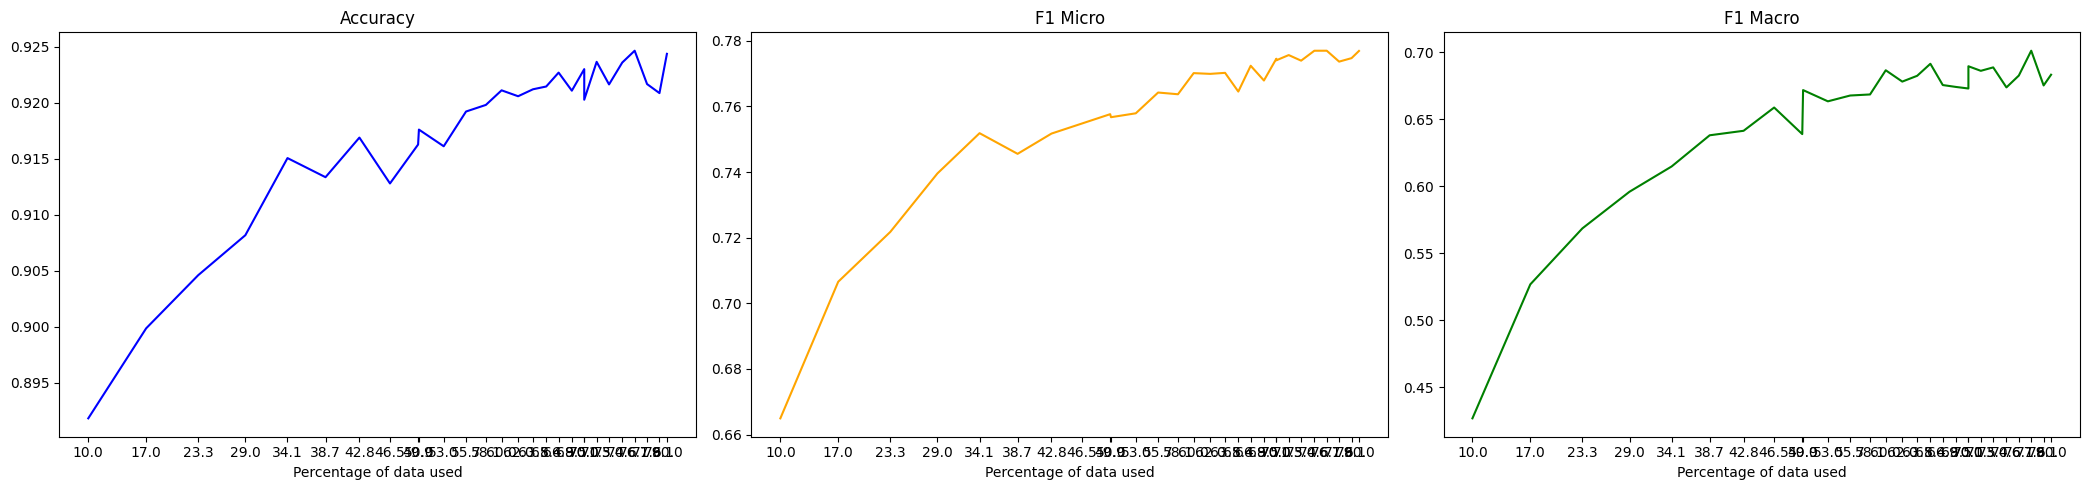

Result saved to results/hsd-random-init-10-1-results.csv


In [35]:
initial_train_size = int(0.1 * total_data)
active_learning(50, 0, 'random', 10)